# Загрузка и подготовка данных

In [211]:
import torch
print(torch.backends.mps.is_available())   # True, если GPU доступен
print(torch.backends.mps.is_built())  

True
True


In [212]:
# Chroma Change Embeddings Analysis
# Analysis of extracted embeddings from chroma_change dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [213]:
# Load embeddings and metadata
embeddings_dir = Path("data/embeddings/qwen2.5_7B/chroma_change")
dataset_manifest_path = Path("data/colors/chroma_change/manifest.json")
dataset_manifest_path = Path("data/colors/chroma_change/manifest.json")

# embeddings_dir = Path("data/embeddings/qwen2.5_7B/value_change")
# dataset_manifest_path = Path("data/colors/value_change/manifest.json")

# Load dataset manifest for color information
with open(dataset_manifest_path, 'r') as f:
    dataset_manifest = json.load(f)

# Create mapping from index to color metadata
index_to_color = {}
for chain in dataset_manifest['chains']:
    for item in chain['items']:
        idx = str(item['index'])
        index_to_color[idx] = {
            'notation': item['notation'],
            'xyY': item['xyY'],
            'H': item['H'],
            'C': item['C'],
            'V': item['V'],
            'chain_description': chain['description']
        }

print(f"Loaded metadata for {len(index_to_color)} color samples")
print("Sample color data:")
for i in range(1, 6):
    if str(i) in index_to_color:
        print(f"  {i}: {index_to_color[str(i)]['notation']} - {index_to_color[str(i)]['chain_description']}")


Loaded metadata for 32 color samples
Sample color data:
  1: N0 - chain fixed H=N C=0 V=None
  2: N1 - chain fixed H=N C=0 V=None
  3: 2.5R 5/0 - chain fixed H=2.5R C=None V=5
  4: 2.5R 5/2 - chain fixed H=2.5R C=None V=5
  5: 2.5R 5/4 - chain fixed H=2.5R C=None V=5


In [214]:
# Load all embeddings
def load_embeddings(embeddings_dir):
    """Load all embedding files and return organized data"""
    embeddings_data = {
        'lm_pooled_mean': [],
        'vision_pooled_mean': [],
        'visual_token_lens': [],
        'indices': [],
        'metadata': []
    }
    
    # Get all subdirectories (numbered folders)
    subdirs = sorted([d for d in embeddings_dir.iterdir() if d.is_dir() and d.name.isdigit()])
    
    for subdir in subdirs:
        idx = subdir.name
        
        # Load manifest for metadata
        manifest_path = subdir / 'manifest.json'
        if manifest_path.exists():
            with open(manifest_path, 'r') as f:
                manifest = json.load(f)
            embeddings_data['metadata'].append(manifest)
        else:
            embeddings_data['metadata'].append({})
        
        # Load embeddings
        lm_path = subdir / 'lm_pooled_mean.npy'
        vision_path = subdir / 'vision_pooled_mean.npy'
        lens_path = subdir / 'visual_token_lens.npy'
        
        if lm_path.exists():
            lm_emb = np.load(lm_path)
            embeddings_data['lm_pooled_mean'].append(lm_emb.flatten())
        else:
            embeddings_data['lm_pooled_mean'].append(None)
            
        if vision_path.exists():
            vision_emb = np.load(vision_path)
            embeddings_data['vision_pooled_mean'].append(vision_emb.flatten())
        else:
            embeddings_data['vision_pooled_mean'].append(None)
            
        if lens_path.exists():
            lens_emb = np.load(lens_path)
            embeddings_data['visual_token_lens'].append(lens_emb.flatten())
        else:
            embeddings_data['visual_token_lens'].append(None)
            
        embeddings_data['indices'].append(idx)
    
    return embeddings_data

# Load the data
embeddings_data = load_embeddings(embeddings_dir)
print(f"Loaded embeddings for {len(embeddings_data['indices'])} samples")

# Check embedding shapes
for emb_type in ['lm_pooled_mean', 'vision_pooled_mean', 'visual_token_lens']:
    valid_embs = [emb for emb in embeddings_data[emb_type] if emb is not None]
    if valid_embs:
        print(f"{emb_type}: {len(valid_embs)} samples, shape {valid_embs[0].shape}")
    else:
        print(f"{emb_type}: No valid embeddings found")


Loaded embeddings for 32 samples
lm_pooled_mean: 32 samples, shape (3584,)
vision_pooled_mean: 32 samples, shape (3584,)
visual_token_lens: 32 samples, shape (1,)


In [215]:
# Prepare data for analysis
def prepare_embedding_matrix(embeddings_list):
    """Convert list of embeddings to matrix, filtering out None values"""
    valid_embeddings = [emb for emb in embeddings_list if emb is not None]
    if not valid_embeddings:
        return None, []
    
    # Get valid indices
    valid_indices = [i for i, emb in enumerate(embeddings_list) if emb is not None]
    
    # Stack embeddings into matrix
    embedding_matrix = np.vstack(valid_embeddings)
    return embedding_matrix, valid_indices

# Prepare matrices for each embedding type
lm_matrix, lm_valid_indices = prepare_embedding_matrix(embeddings_data['lm_pooled_mean'])
vision_matrix, vision_valid_indices = prepare_embedding_matrix(embeddings_data['vision_pooled_mean'])
lens_matrix, lens_valid_indices = prepare_embedding_matrix(embeddings_data['visual_token_lens'])

print("Embedding matrices prepared:")
if lm_matrix is not None:
    print(f"  LM pooled mean: {lm_matrix.shape}")
if vision_matrix is not None:
    print(f"  Vision pooled mean: {vision_matrix.shape}")
if lens_matrix is not None:
    print(f"  Visual token lens: {lens_matrix.shape}")

# Create color metadata for valid samples
def get_color_metadata(valid_indices, embeddings_data, index_to_color):
    """Get color metadata for valid embedding samples"""
    color_metadata = []
    for i, orig_idx in enumerate(valid_indices):
        idx = embeddings_data['indices'][orig_idx]
        if idx in index_to_color:
            color_info = index_to_color[idx].copy()
            color_info['original_index'] = orig_idx
            color_info['embedding_index'] = i
            color_metadata.append(color_info)
        else:
            color_metadata.append({
                'notation': f'Unknown_{idx}',
                'original_index': orig_idx,
                'embedding_index': i
            })
    return color_metadata

lm_color_meta = get_color_metadata(lm_valid_indices, embeddings_data, index_to_color)
vision_color_meta = get_color_metadata(vision_valid_indices, embeddings_data, index_to_color)
lens_color_meta = get_color_metadata(lens_valid_indices, embeddings_data, index_to_color)


Embedding matrices prepared:
  LM pooled mean: (32, 3584)
  Vision pooled mean: (32, 3584)
  Visual token lens: (32, 1)


# Визуаьлный анализ структуры пространства эмбеддингов с помощью уменьшиния размерности (PCA / T-sne/ UMAP)

| Метод                                                    | Что делает                                                                                                    | Когда использовать                                                               | Что можно увидеть                                                                                             |
| -------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **PCA (Principal Component Analysis)**                   | Линейно уменьшает размерность, сохраняя максимум дисперсии данных.                                            | Для общей ориентации, глобальных трендов, грубых закономерностей.                | Видно, есть ли сильное разделение классов по главным компонентам, тенденции и шум.                            |
| **t-SNE (t-Distributed Stochastic Neighbor Embedding)**  | Нелинейно сжимает пространство, оптимизируя сохранение *локальных соседств*.                                  | Для кластеров и локальных структур. Хорошо видны “островки” похожих эмбеддингов. | Можно увидеть, какие группы данных (по H, C, V или типам модальностей) естественно образуют плотные кластеры. |
| **UMAP (Uniform Manifold Approximation and Projection)** | Похож на t-SNE, но с более стабильной геометрией и параметрами, даёт баланс локальной и глобальной структуры. | Для сравнения глобальных и локальных паттернов, построения интерактивных карт.   | Можно увидеть, как связаны разные модальности, насколько «склеиваются» кластеры разных цветов и направлений.  |


In [216]:
# PCA Analysis for all embedding types
def perform_pca_analysis(embedding_matrix, color_metadata, embedding_name):
    """Perform PCA analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(embedding_matrix_scaled)
    
    # Calculate explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Find number of components for different variance thresholds
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    
    print(f"\n=== PCA Analysis for {embedding_name} ===")
    print(f"Original dimensions: {embedding_matrix.shape[1]}")
    print(f"Number of samples: {embedding_matrix.shape[0]}")
    print(f"Components for 90% variance: {n_components_90}")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components for 99% variance: {n_components_99}")
    print(f"First 10 components explain {cumulative_variance[9]:.3f} of variance")
    
    return {
        'pca_result': pca_result,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'n_components_95': n_components_95,
        'n_components_99': n_components_99,
        'pca_model': pca,
        'scaler': scaler
    }

# Perform PCA for each embedding type
pca_results = {}
if lm_matrix is not None:
    pca_results['lm'] = perform_pca_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    pca_results['vision'] = perform_pca_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== PCA Analysis for LM Pooled Mean ===
Original dimensions: 3584
Number of samples: 32
Components for 90% variance: 5
Components for 95% variance: 7
Components for 99% variance: 11
First 10 components explain 0.986 of variance

=== PCA Analysis for Vision Pooled Mean ===
Original dimensions: 3584
Number of samples: 32
Components for 90% variance: 5
Components for 95% variance: 7
Components for 99% variance: 10
First 10 components explain 0.991 of variance


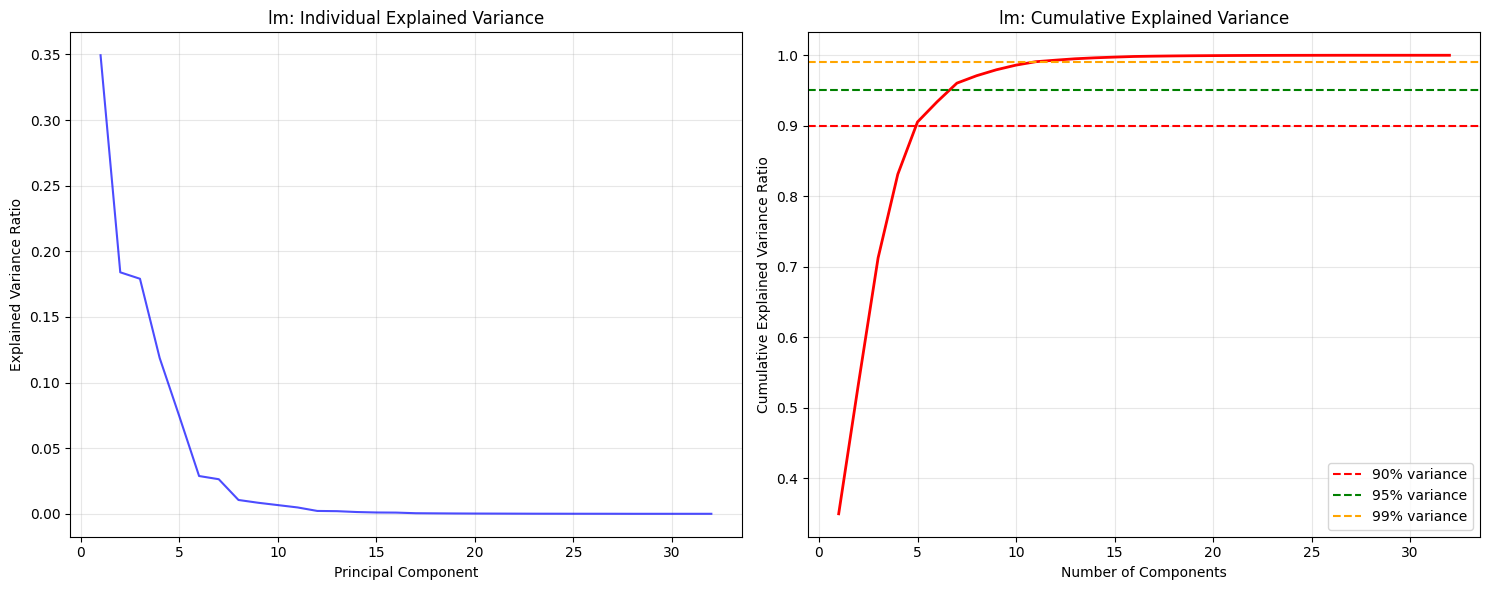

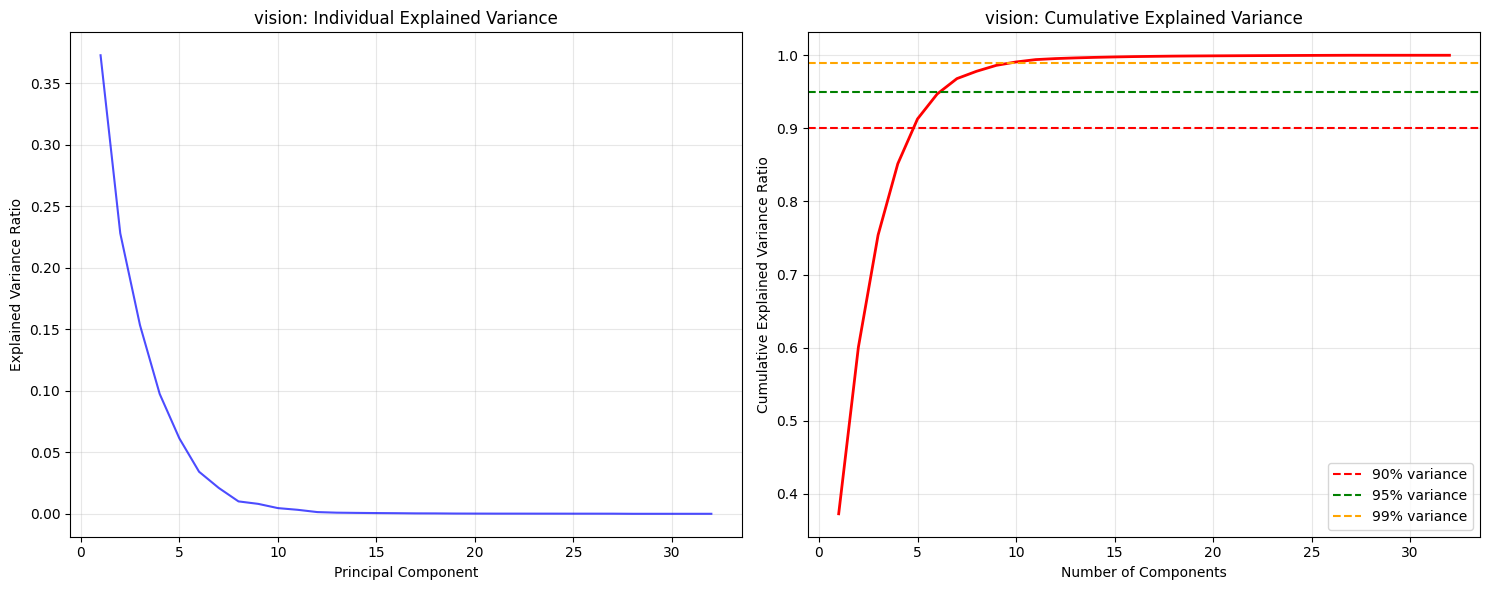

In [217]:

# Visualize PCA results
def plot_pca_variance(pca_results, embedding_name):
    """Plot explained variance for PCA"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    result = pca_results[embedding_name]
    explained_var = result['explained_variance_ratio']
    cumulative_var = result['cumulative_variance']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    ax1.plot(range(1, min(51, len(explained_var) + 1)), explained_var[:50], 'b-', alpha=0.7)
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title(f'{embedding_name}: Individual Explained Variance')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'r-', linewidth=2)
    ax2.axhline(y=0.90, color='red', linestyle='--', label='90% variance')
    ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
    ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title(f'{embedding_name}: Cumulative Explained Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA variance for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        plot_pca_variance(pca_results, emb_type)


In [218]:
# t-SNE Analysis for all embedding types
def perform_tsne_analysis(embedding_matrix, color_metadata, embedding_name, perplexity=7, n_iter=5000):
    """Perform t-SNE analysis and return results"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    print(f"\n=== t-SNE Analysis for {embedding_name} ===")
    print(f"Input shape: {embedding_matrix.shape}")
    print(f"Perplexity: {perplexity}")
    
    # Standardize the data
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=n_iter, random_state=42, verbose=1, min_grad_norm=1e-8, n_iter_without_progress=1000)
    tsne_result = tsne.fit_transform(embedding_matrix_scaled)
    
    print(f"t-SNE completed. Final KL divergence: {tsne.kl_divergence_:.3f}")
    
    return {
        'tsne_result': tsne_result,
        'tsne_model': tsne,
        'scaler': scaler
    }

# Perform t-SNE for each embedding type
tsne_results = {}
if lm_matrix is not None:
    tsne_results['lm'] = perform_tsne_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    tsne_results['vision'] = perform_tsne_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")



=== t-SNE Analysis for LM Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 7
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 33.724272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.176132
[t-SNE] KL divergence after 5000 iterations: 0.108445
t-SNE completed. Final KL divergence: 0.108

=== t-SNE Analysis for Vision Pooled Mean ===
Input shape: (32, 3584)
Perplexity: 7
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 34.178611
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.661358
[t-SNE] KL divergence after 2550 iterations: 0.167894
t-SNE completed. Final KL divergence: 0.168


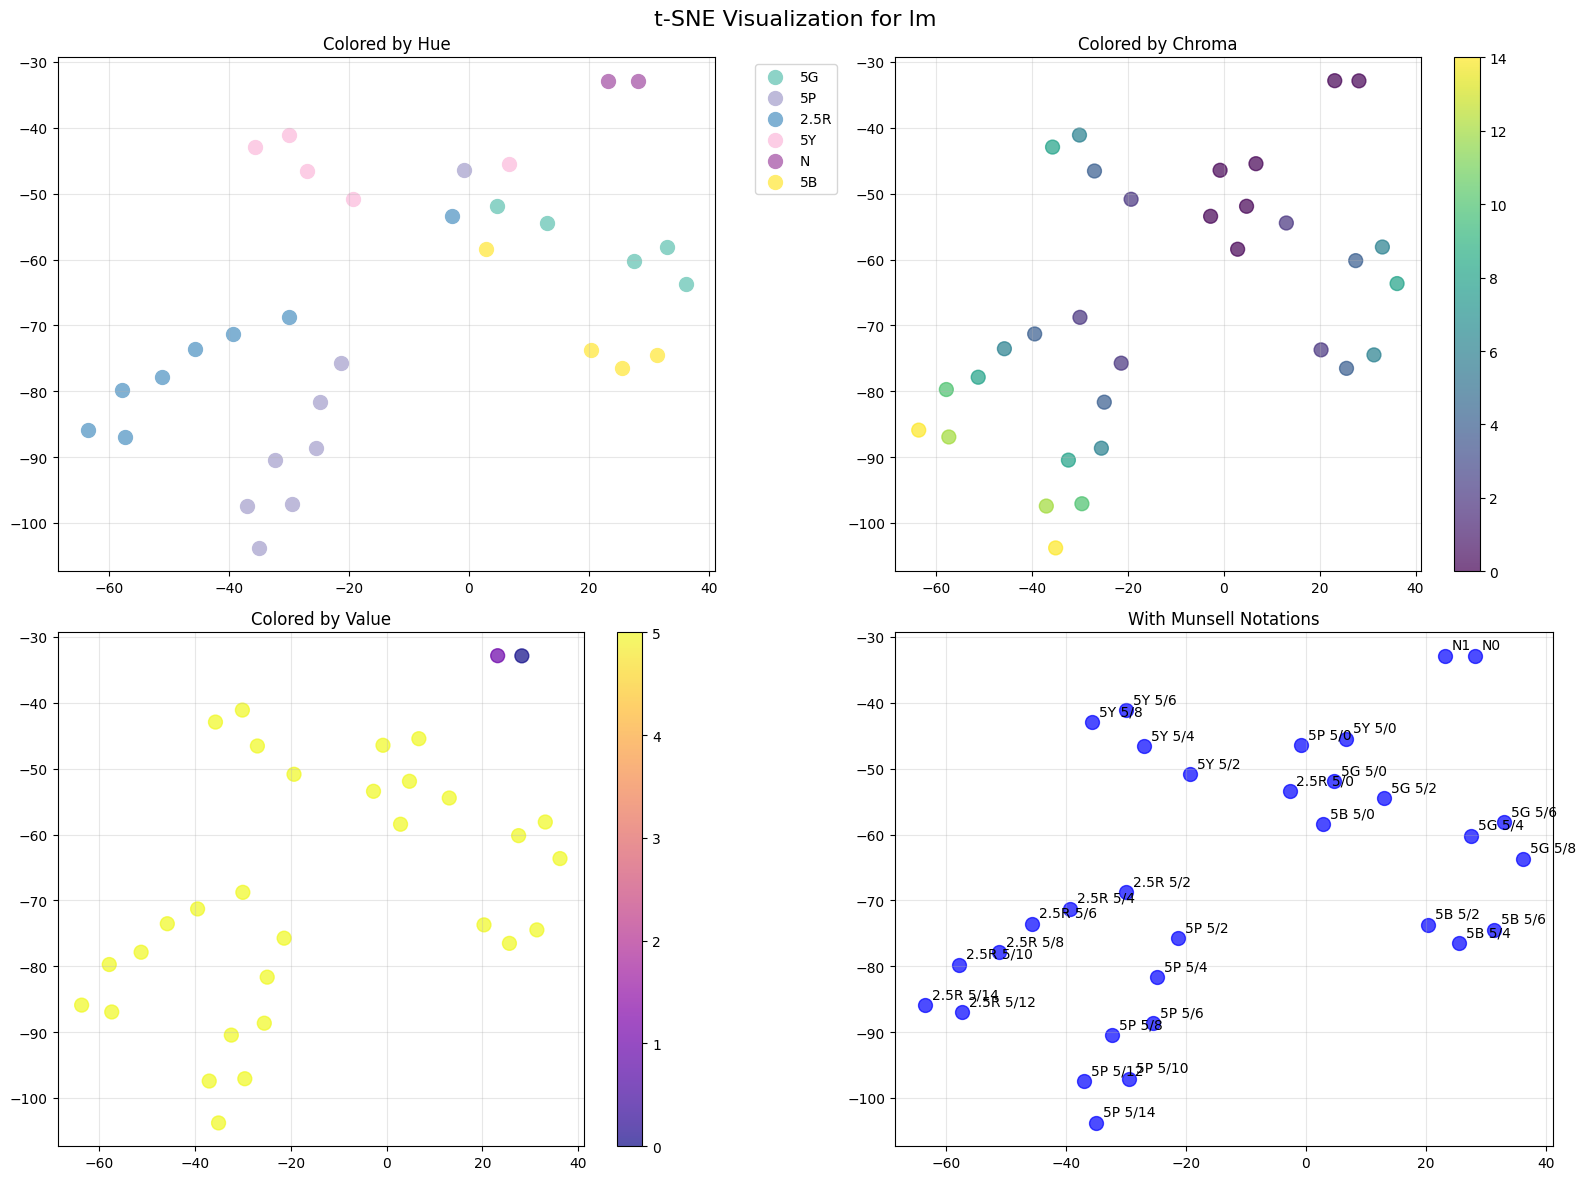

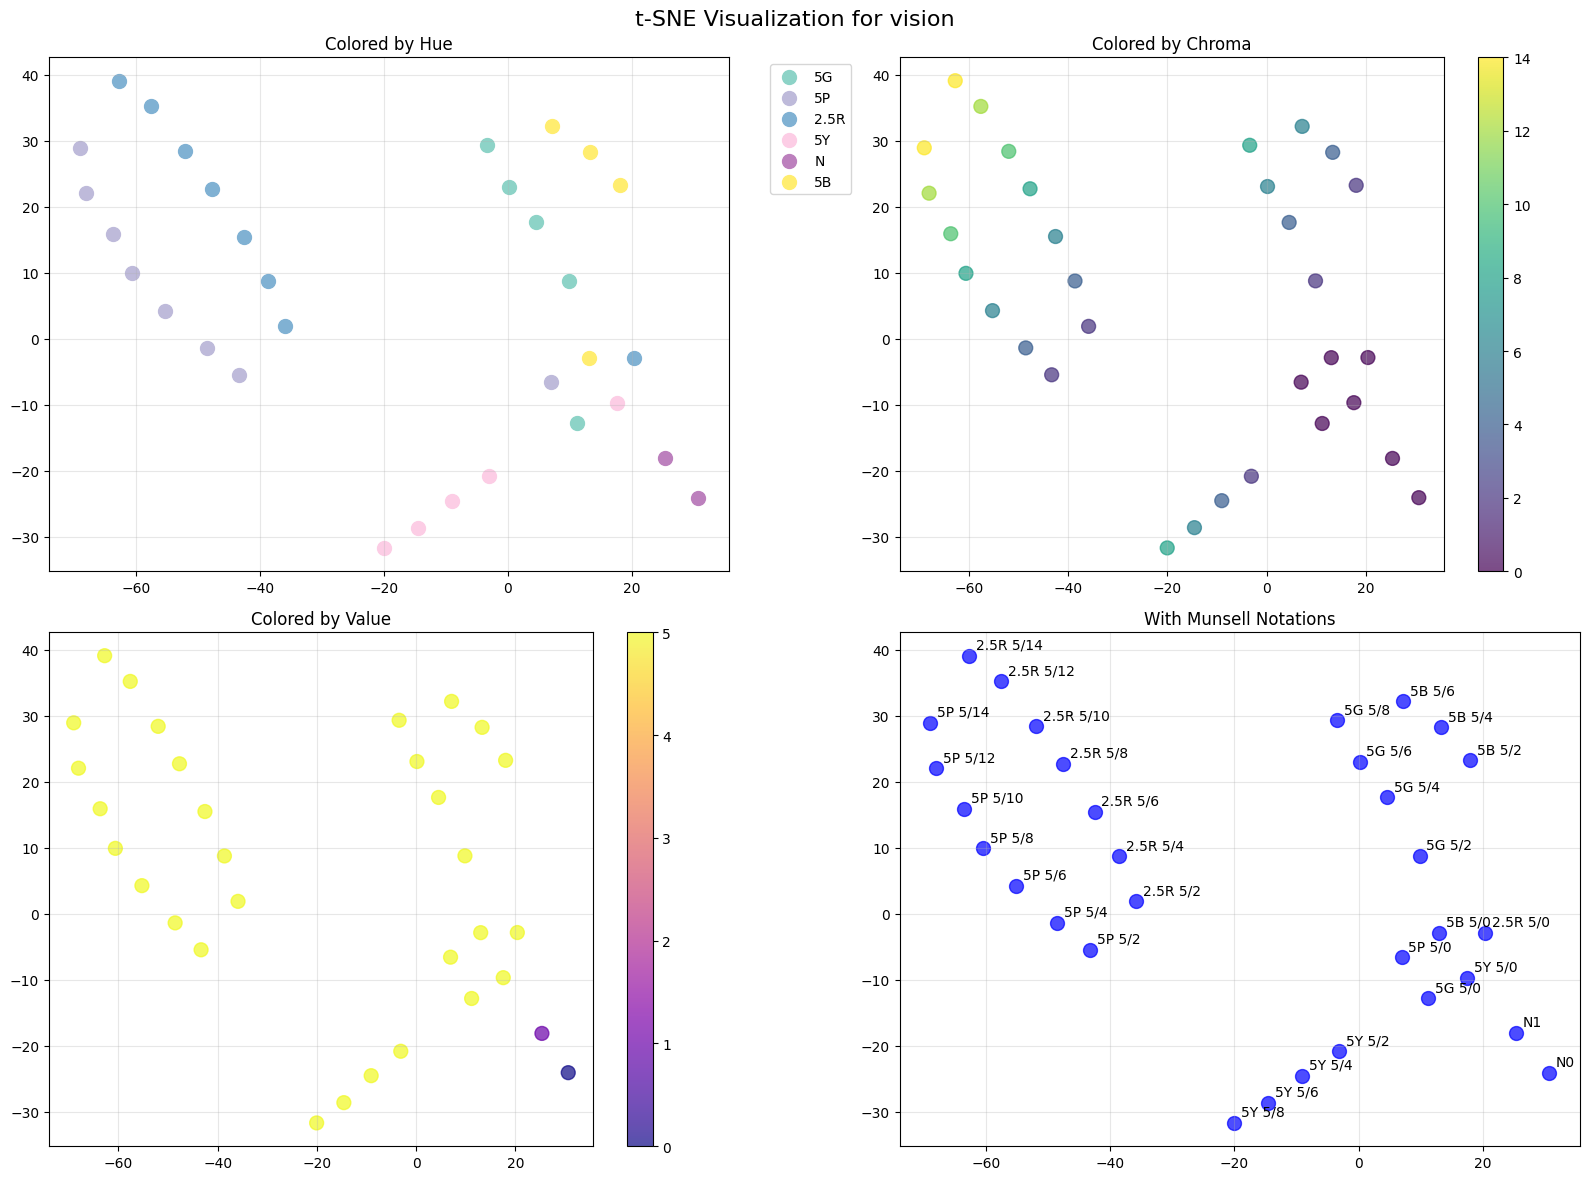

In [219]:
# Visualize t-SNE results with color information
def plot_tsne_results(tsne_results, color_metadata, embedding_name):
    """Plot t-SNE results colored by different color attributes"""
    if embedding_name not in tsne_results or tsne_results[embedding_name] is None:
        return
    
    tsne_result = tsne_results[embedding_name]['tsne_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f't-SNE Visualization for {embedding_name}', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=1, s=100)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=100)
    axes[0,1].set_title('Colored by Chroma')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=100)
    axes[1,0].set_title('Colored by Value')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c='blue', alpha=0.7, s=100)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (tsne_result[i, 0], tsne_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=10)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot t-SNE results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in tsne_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_tsne_results(tsne_results, color_meta, emb_type)



=== t-SNE Analysis for LM Pooled Mean ===
Input shape (before filtering): (32, 3584)
Filtered shape: (28, 3584)
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 36.060104
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.428810
[t-SNE] KL divergence after 1650 iterations: 0.081239
t-SNE completed. Final KL divergence: 0.081

=== t-SNE Analysis for Vision Pooled Mean ===
Input shape (before filtering): (32, 3584)
Filtered shape: (28, 3584)
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 36.603756
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.143684
[t-SNE] KL divergence after 2950 iterations: 0.137618
t-SN

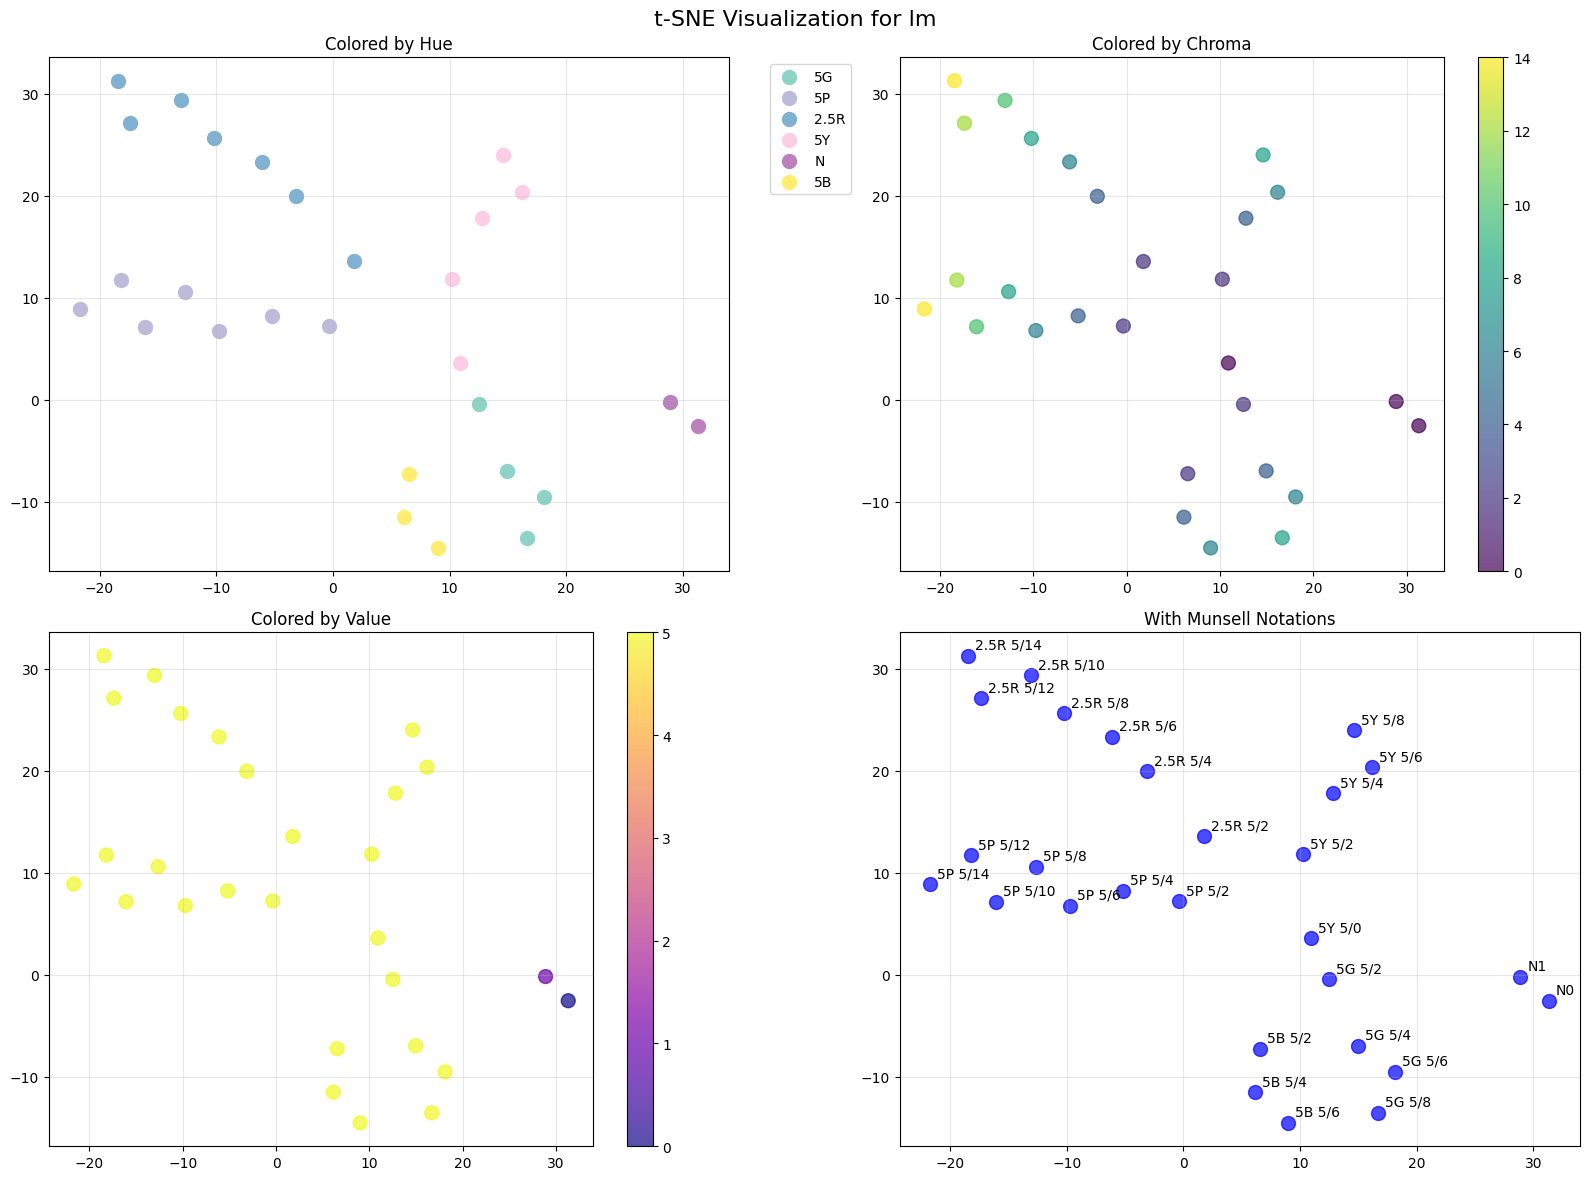

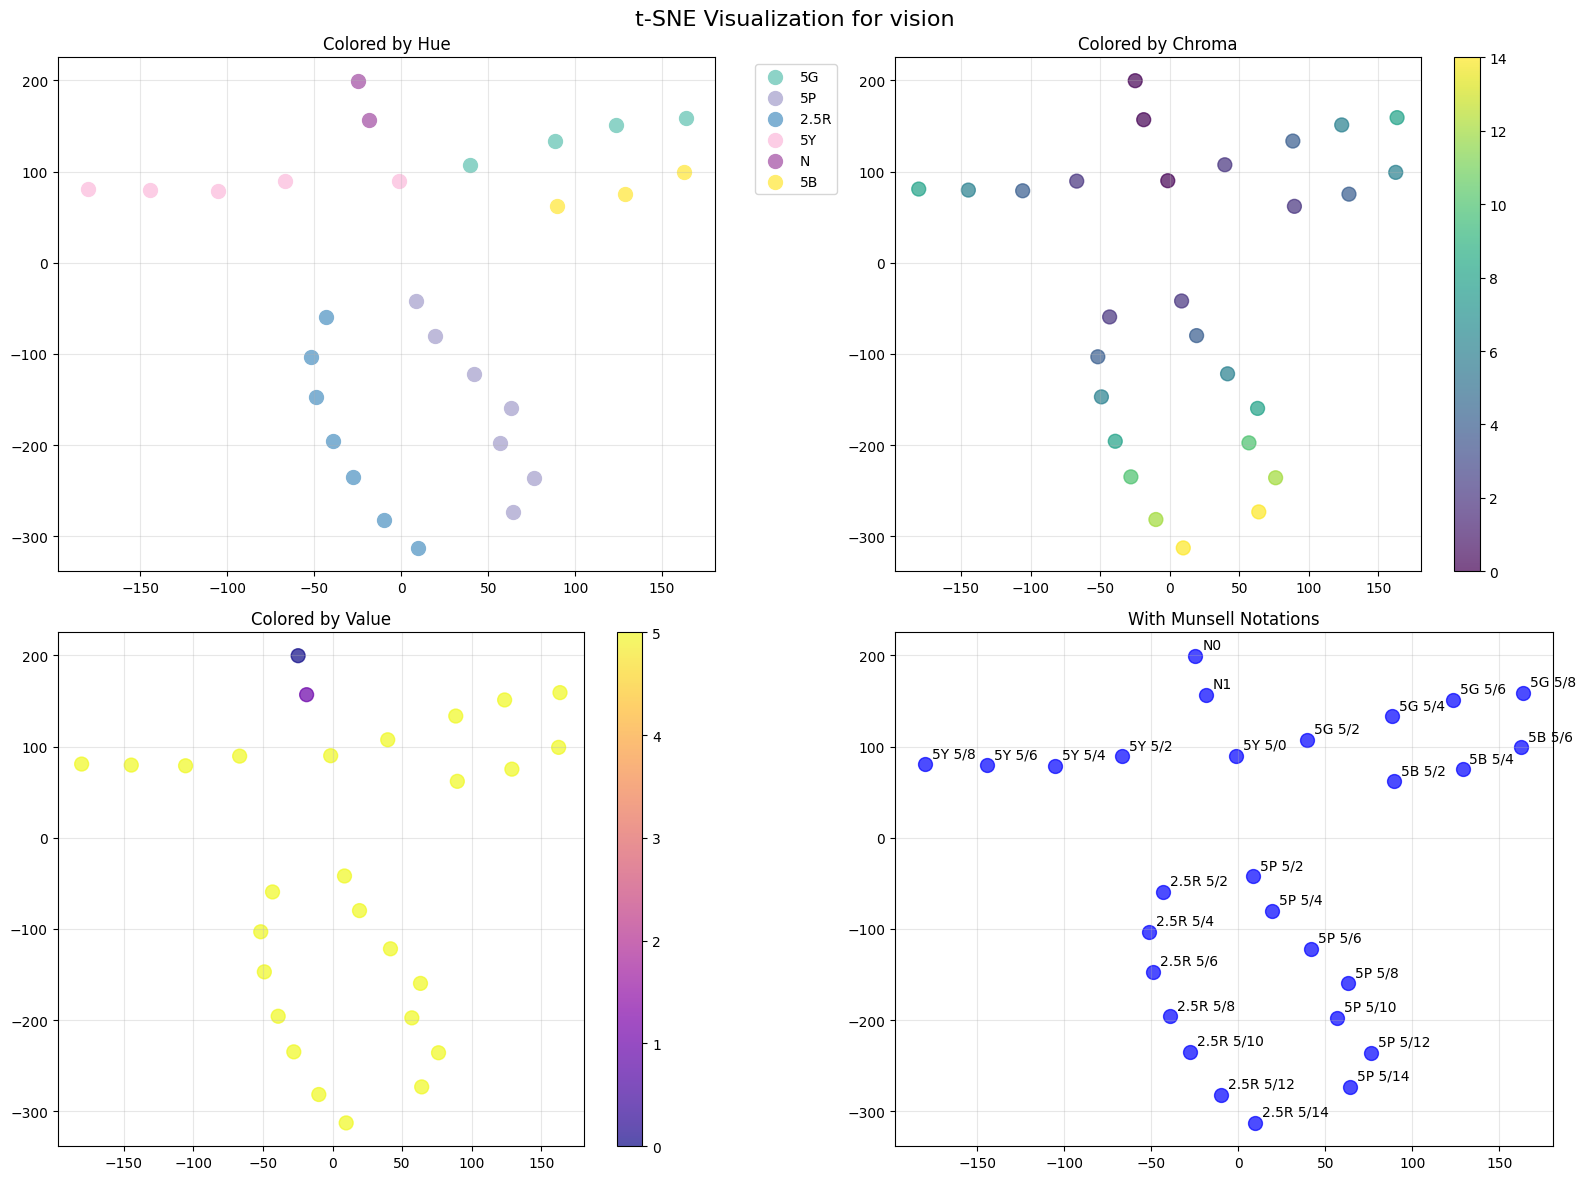

In [220]:
#My code
# t-SNE с фильтрацией (все C!=0 + по одной C=0 на V)
def perform_tsne_wo_gray_analysis(embedding_matrix, color_metadata, embedding_name, perplexity=7, n_iter=5000):
    """Perform t-SNE analysis with filtered gray samples (C=0)"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None

    print(f"\n=== t-SNE Analysis for {embedding_name} ===")
    print(f"Input shape (before filtering): {embedding_matrix.shape}")

    # Преобразуем color_metadata в DataFrame
    meta = pd.DataFrame(color_metadata)
    if 'V' not in meta.columns or 'C' not in meta.columns:
        raise ValueError("color_metadata must contain 'V' and 'C' columns")

    meta['idx'] = np.arange(len(meta))

    # Сохраняем все, где C != 0
    keep_indices = set(meta.loc[meta['C'] != 0, 'idx'].tolist())

    # Добавляем по одной точке с C=0 на каждое уникальное V
    for v_value, group in meta.groupby('V'):
        c0_rows = group[group['C'] == 0]
        if not c0_rows.empty:
            keep_indices.add(c0_rows.iloc[0]['idx'])

    keep_indices = sorted(keep_indices)

    # Применяем фильтрацию
    embedding_matrix_filtered = embedding_matrix[keep_indices]
    meta_filtered = meta.loc[meta['idx'].isin(keep_indices)].reset_index(drop=True)

    print(f"Filtered shape: {embedding_matrix_filtered.shape}")

    # Standardize
    scaler = StandardScaler()
    embedding_matrix_scaled = scaler.fit_transform(embedding_matrix_filtered)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=n_iter,
        random_state=42,
        verbose=1,
        min_grad_norm=1e-8,
        n_iter_without_progress=1000
    )
    tsne_result = tsne.fit_transform(embedding_matrix_scaled)

    print(f"t-SNE completed. Final KL divergence: {tsne.kl_divergence_:.3f}")

    return {
        'tsne_result': tsne_result,
        'tsne_model': tsne,
        'scaler': scaler,
        'meta_filtered': meta_filtered
    }


# Визуализация t-SNE с учетом фильтрованных метаданных
def plot_filter_tsne_results(tsne_results, embedding_name):
    """Plot t-SNE results using filtered metadata"""
    if embedding_name not in tsne_results or tsne_results[embedding_name] is None:
        return
    
    tsne_result = tsne_results[embedding_name]['tsne_result']
    meta = tsne_results[embedding_name]['meta_filtered']

    # Извлекаем данные для цветовой визуализации
    hues = meta.get('H', pd.Series(['Unknown'] * len(meta)))
    chromas = meta.get('C', pd.Series([0] * len(meta)))
    values = meta.get('V', pd.Series([0] * len(meta)))
    notations = meta.get('notation', pd.Series(['Unknown'] * len(meta)))

    # Фигура
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f't-SNE Visualization for {embedding_name}', fontsize=16)

    # --- 1. По Hue ---
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}

    for hue in unique_hues:
        mask = hues == hue
        axes[0,0].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                         c=[hue_color_map[hue]], label=hue, alpha=1, s=100)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)

    # --- 2. По Chroma ---
    sc1 = axes[0,1].scatter(tsne_result[:, 0], tsne_result[:, 1],
                            c=chromas, cmap='viridis', alpha=0.7, s=100)
    axes[0,1].set_title('Colored by Chroma')
    plt.colorbar(sc1, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)

    # --- 3. По Value ---
    sc2 = axes[1,0].scatter(tsne_result[:, 0], tsne_result[:, 1],
                            c=values, cmap='plasma', alpha=0.7, s=100)
    axes[1,0].set_title('Colored by Value')
    plt.colorbar(sc2, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)

    # --- 4. С подписями Munsell Notation ---
    axes[1,1].scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', alpha=0.7, s=100)
    for i, notation in enumerate(notations):
        axes[1,1].annotate(str(notation), (tsne_result[i, 0], tsne_result[i, 1]),
                           xytext=(5, 5), textcoords='offset points', fontsize=10)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# === Запуск анализа и визуализации ===
tsne_filtered_results = {}
if lm_matrix is not None:
    tsne_filtered_results['lm'] = perform_tsne_wo_gray_analysis(lm_matrix, lm_color_meta, "LM Pooled Mean")
if vision_matrix is not None:
    tsne_filtered_results['vision'] = perform_tsne_wo_gray_analysis(vision_matrix, vision_color_meta, "Vision Pooled Mean")

# Визуализация для фильтрованных результатов
for emb_type in ['lm', 'vision']:
    if emb_type in tsne_filtered_results:
        plot_filter_tsne_results(tsne_filtered_results, emb_type)


Filtered: kept 28 of 32 total points
Filtered: kept 28 of 32 total points

=== UMAP Analysis for LM Pooled Mean ===
Input shape: (28, 3584)
UMAP completed.
Output shape: (28, 2)

=== UMAP Analysis for Vision Pooled Mean ===
Input shape: (28, 3584)
UMAP completed.
Output shape: (28, 2)


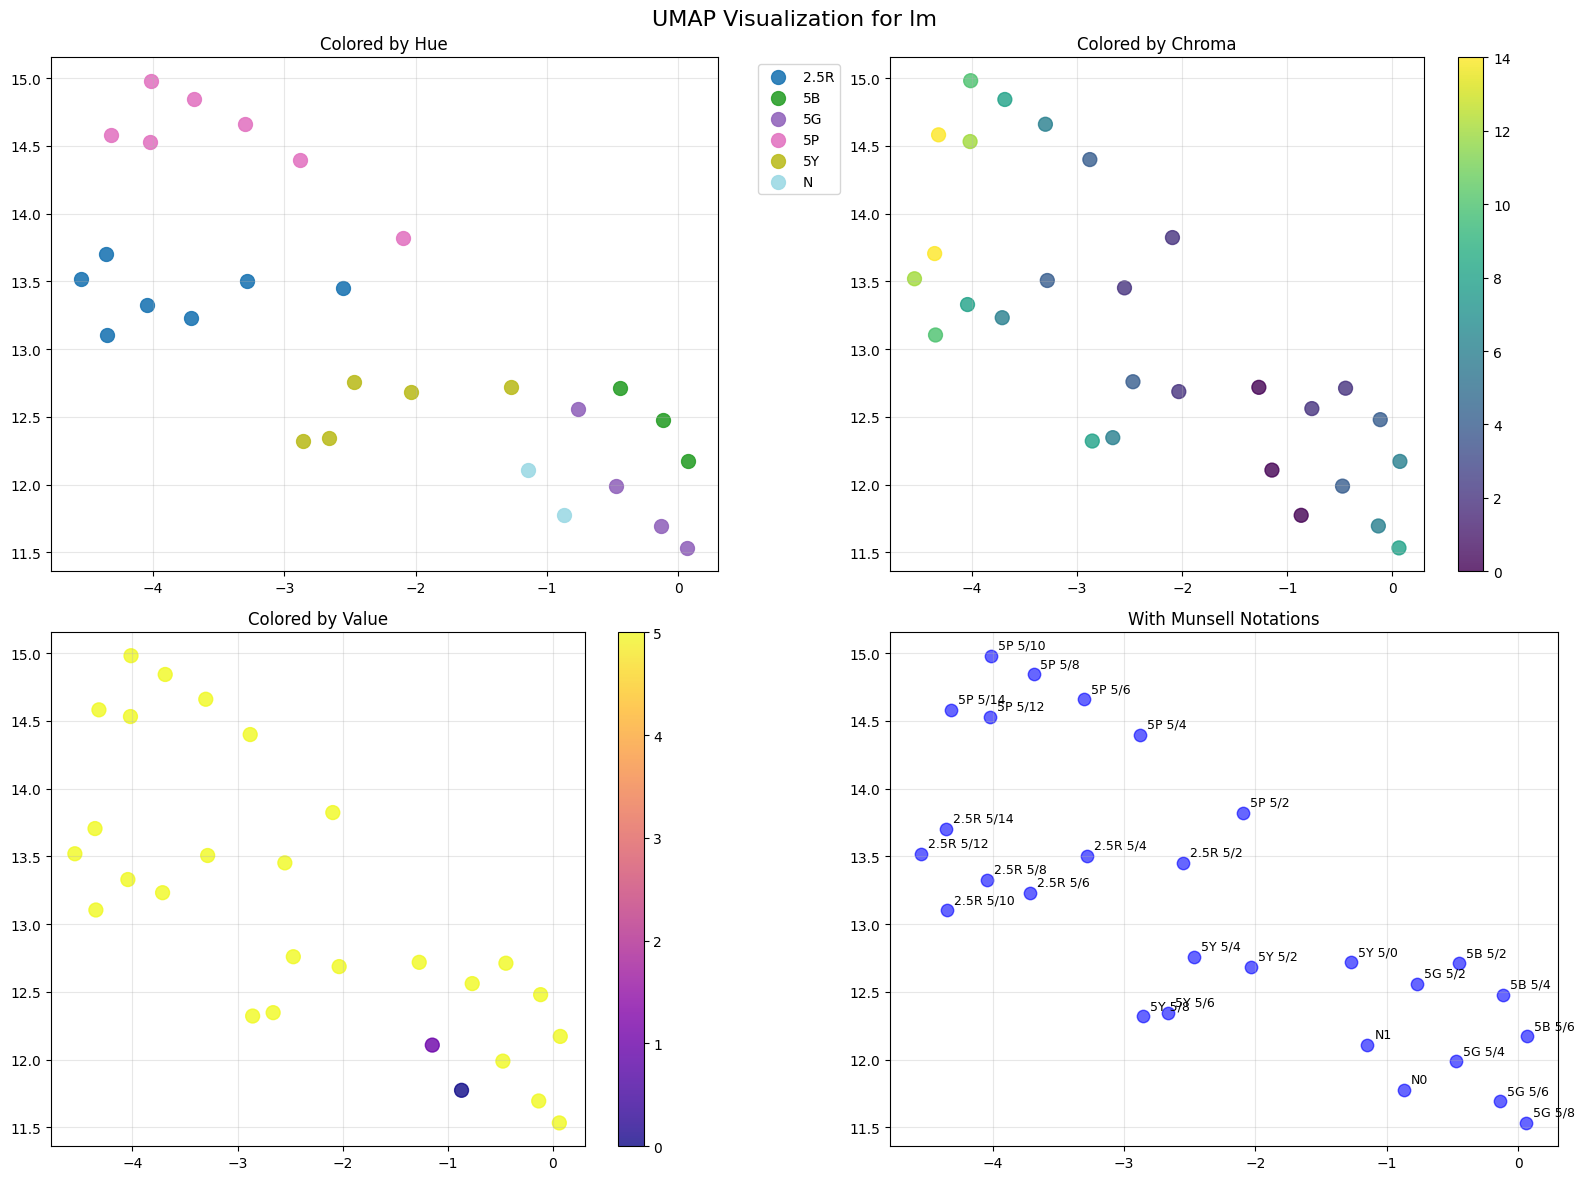

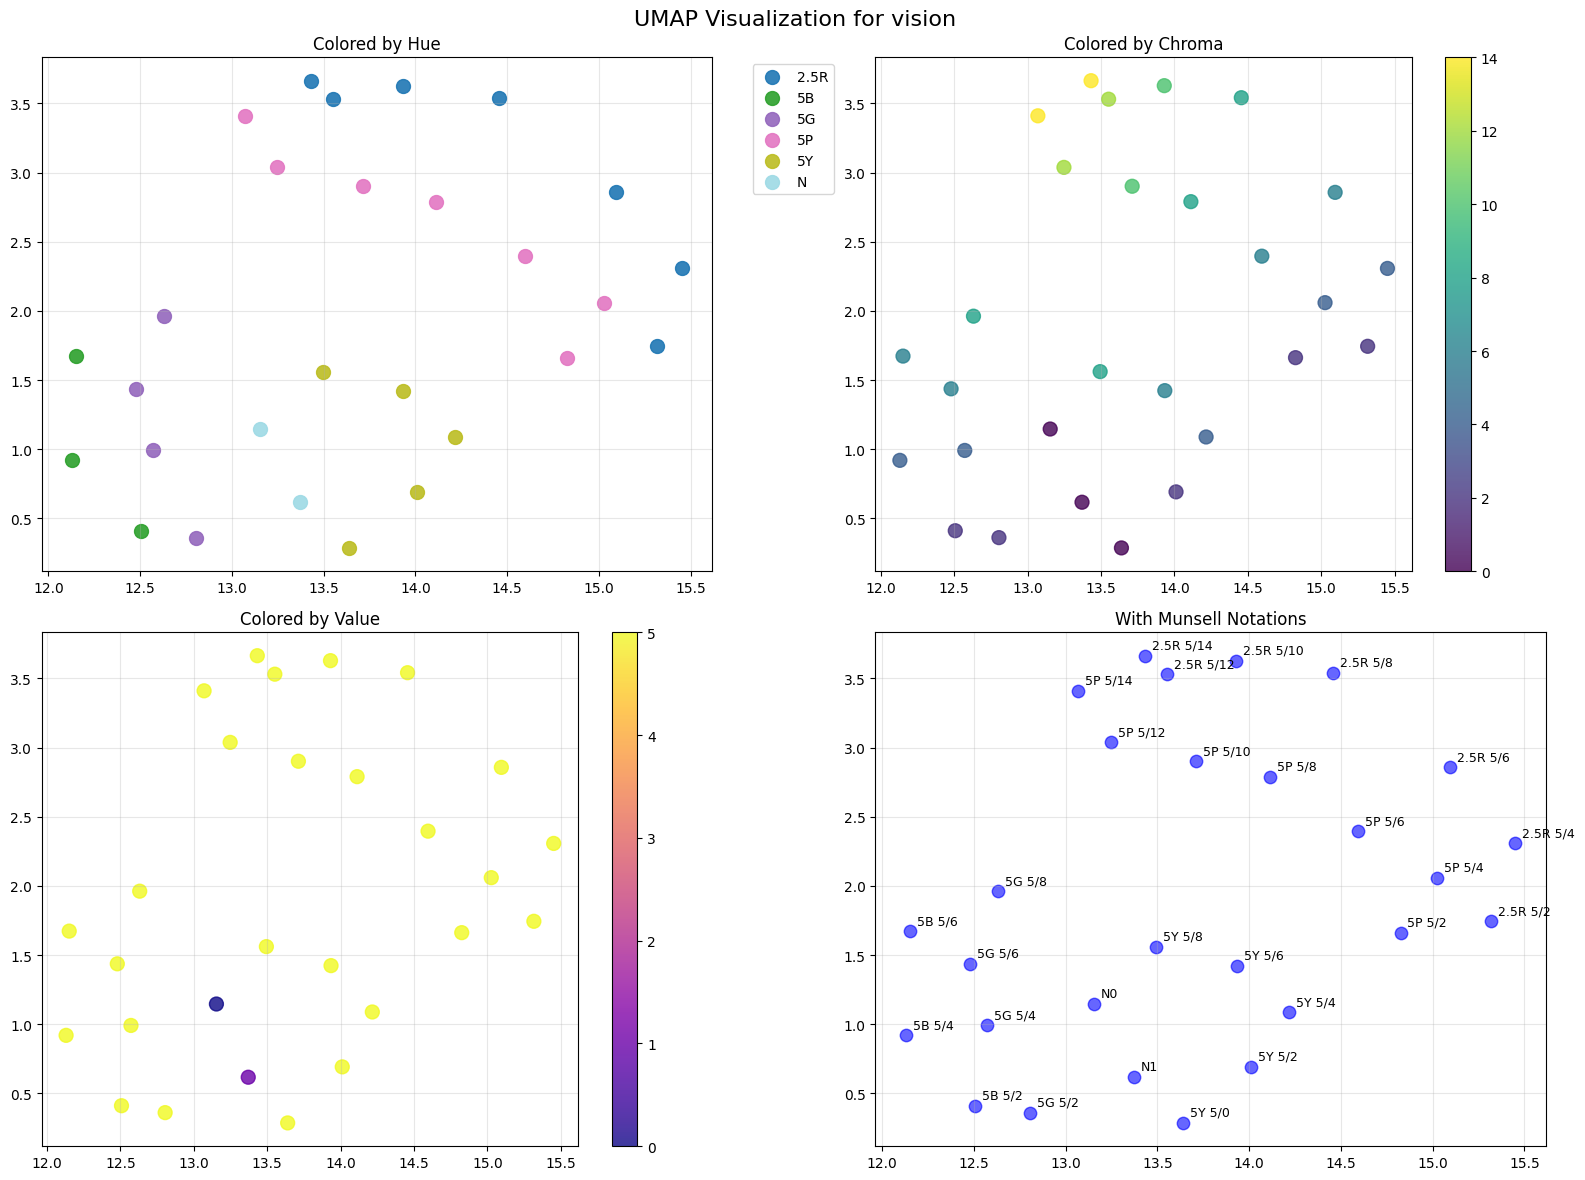

In [221]:
# === Фильтрация данных по цвету ===
def filter_by_chroma_and_value(embedding_matrix, color_metadata):
    """Оставляет все C != 0 + по одной точке с C=0 на каждое уникальное V"""
    if embedding_matrix is None or len(color_metadata) == 0:
        return embedding_matrix, color_metadata

    chromas = np.array([meta.get('C', 0) for meta in color_metadata])
    values = np.array([meta.get('V', 0) for meta in color_metadata])

    # Все C != 0
    non_gray_idx = np.where(chromas != 0)[0]

    # По одной C=0 для каждого уникального V
    gray_idx = []
    for v in np.unique(values[chromas == 0]):
        v_indices = np.where((chromas == 0) & (values == v))[0]
        if len(v_indices) > 0:
            gray_idx.append(v_indices[0])

    # Комбинируем
    selected_idx = np.sort(np.concatenate([non_gray_idx, gray_idx]))
    filtered_matrix = embedding_matrix[selected_idx]
    filtered_meta = [color_metadata[i] for i in selected_idx]

    print(f"Filtered: kept {len(selected_idx)} of {len(color_metadata)} total points")
    return filtered_matrix, filtered_meta


# === UMAP-анализ ===
def perform_umap_analysis(embedding_matrix, color_metadata, embedding_name,
                          n_neighbors=15, min_dist=0.01, metric='cosine'):
    """Perform UMAP dimensionality reduction (assumes input already filtered)"""
    if embedding_matrix is None:
        print(f"No data available for {embedding_name}")
        return None
    
    print(f"\n=== UMAP Analysis for {embedding_name} ===")
    print(f"Input shape: {embedding_matrix.shape}")

    scaler = StandardScaler()
    embedding_scaled = scaler.fit_transform(embedding_matrix)

    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    umap_result = reducer.fit_transform(embedding_scaled)

    print("UMAP completed.")
    print(f"Output shape: {umap_result.shape}")

    return {
        'umap_result': umap_result,
        'umap_model': reducer,
        'scaler': scaler,
        'filtered_meta': color_metadata
    }


# === Визуализация ===
def plot_umap_results(umap_results, embedding_name):
    """Plot UMAP results colored by H, C, V, and Munsell notation"""
    if embedding_name not in umap_results or umap_results[embedding_name] is None:
        return
    
    result_data = umap_results[embedding_name]
    umap_result = result_data['umap_result']
    color_metadata = result_data['filtered_meta']

    hues = np.array([meta.get('H', 'Unknown') for meta in color_metadata])
    chromas = np.array([meta.get('C', 0) for meta in color_metadata])
    values = np.array([meta.get('V', 0) for meta in color_metadata])
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'UMAP Visualization for {embedding_name}', fontsize=16)

    # === Hue ===
    unique_hues = sorted(set(hues))
    hue_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {h: hue_colors[i] for i, h in enumerate(unique_hues)}

    for hue in unique_hues:
        mask = hues == hue
        axes[0, 0].scatter(umap_result[mask, 0], umap_result[mask, 1],
                           c=[hue_color_map[hue]], label=hue, s=100, alpha=0.9)
    axes[0, 0].set_title('Colored by Hue')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)

    # === Chroma ===
    sc1 = axes[0, 1].scatter(umap_result[:, 0], umap_result[:, 1],
                             c=chromas, cmap='viridis', s=100, alpha=0.8)
    axes[0, 1].set_title('Colored by Chroma')
    plt.colorbar(sc1, ax=axes[0, 1])
    axes[0, 1].grid(True, alpha=0.3)

    # === Value ===
    sc2 = axes[1, 0].scatter(umap_result[:, 0], umap_result[:, 1],
                             c=values, cmap='plasma', s=100, alpha=0.8)
    axes[1, 0].set_title('Colored by Value')
    plt.colorbar(sc2, ax=axes[1, 0])
    axes[1, 0].grid(True, alpha=0.3)

    # === Notations ===
    axes[1, 1].scatter(umap_result[:, 0], umap_result[:, 1],
                       c='blue', alpha=0.6, s=80)
    for i, notation in enumerate(notations):
        axes[1, 1].annotate(notation, (umap_result[i, 0], umap_result[i, 1]),
                            xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1, 1].set_title('With Munsell Notations')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# === Применение ===
# Фильтруем данные один раз глобально
filtered_lm_matrix, filtered_lm_meta = filter_by_chroma_and_value(lm_matrix, lm_color_meta)
filtered_vision_matrix, filtered_vision_meta = filter_by_chroma_and_value(vision_matrix, vision_color_meta)

# Проводим UMAP-анализ
umap_results = {}
if filtered_lm_matrix is not None:
    umap_results['lm'] = perform_umap_analysis(filtered_lm_matrix, filtered_lm_meta, "LM Pooled Mean")

if filtered_vision_matrix is not None:
    umap_results['vision'] = perform_umap_analysis(filtered_vision_matrix, filtered_vision_meta, "Vision Pooled Mean")

# Визуализация
for emb_type in ['lm', 'vision']:
    if emb_type in umap_results:
        plot_umap_results(umap_results, emb_type)


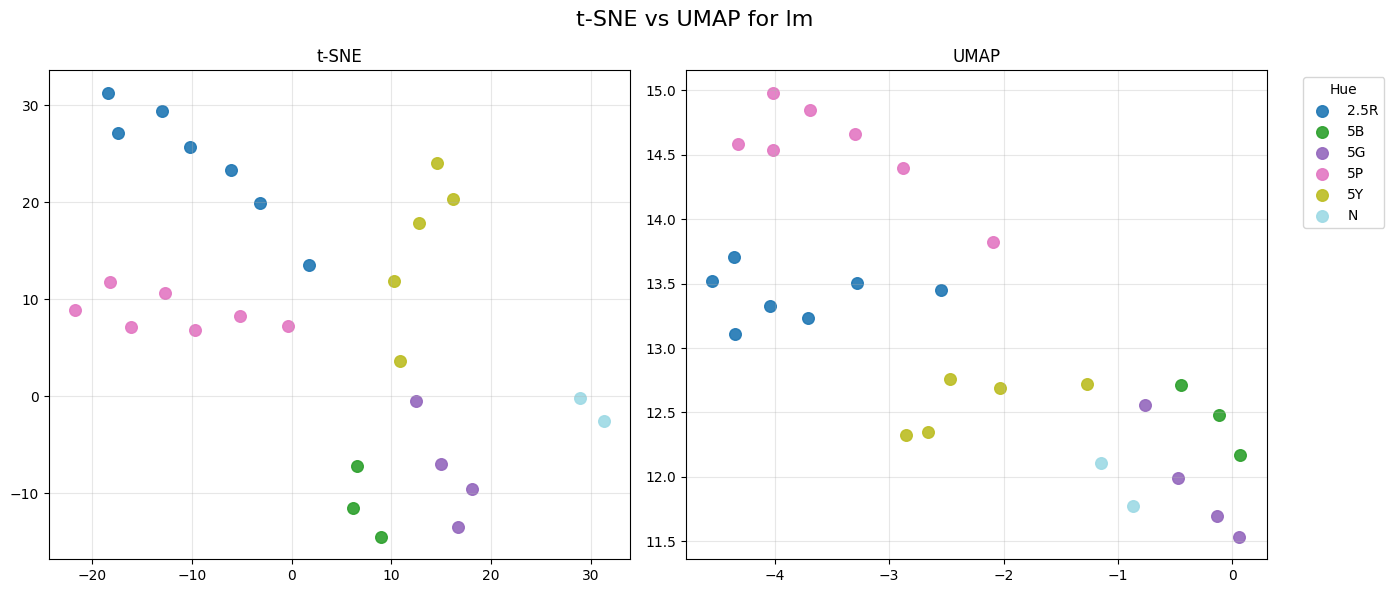

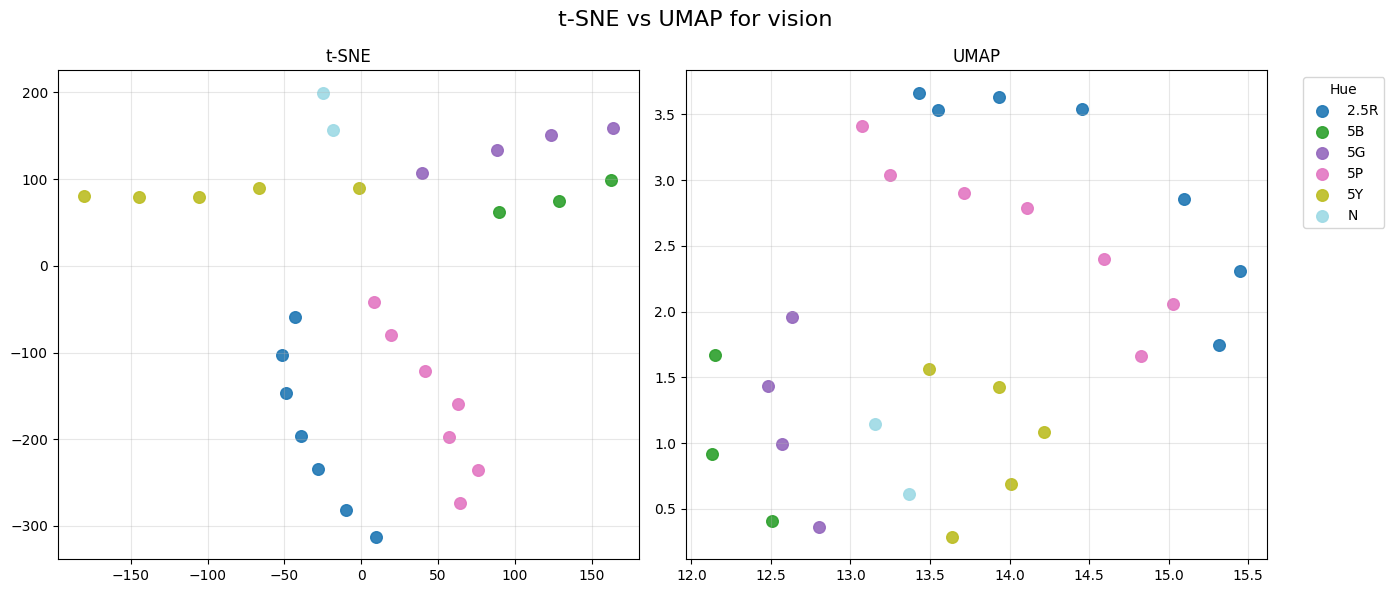

In [222]:
# Compare  tsne and umap results
def compare_tsne_umap(tsne_results, umap_results, color_metadata, embedding_name):
    """Compare t-SNE vs UMAP projections side by side"""
    if (embedding_name not in tsne_results) or (embedding_name not in umap_results):
        print(f"No results for {embedding_name}")
        return
    
    tsne_result = tsne_results[embedding_name]['tsne_result']
    umap_result = umap_results[embedding_name]['umap_result']
    
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    unique_hues = sorted(set(hues))
    hue_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f't-SNE vs UMAP for {embedding_name}', fontsize=16)
    
    # t-SNE
    for hue in unique_hues:
        mask = np.array(hues) == hue
        axes[0].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                        c=[hue_color_map[hue]], label=hue, alpha=0.9, s=70)
    axes[0].set_title('t-SNE')
    axes[0].grid(True, alpha=0.3)
    
    # UMAP
    for hue in unique_hues:
        mask = np.array(hues) == hue
        axes[1].scatter(umap_result[mask, 0], umap_result[mask, 1],
                        c=[hue_color_map[hue]], label=hue, alpha=0.9, s=70)
    axes[1].set_title('UMAP')
    axes[1].grid(True, alpha=0.3)
    
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Hue')
    plt.tight_layout()
    plt.show()


compare_tsne_umap(tsne_filtered_results, umap_results, filtered_lm_meta, 'lm')
compare_tsne_umap(tsne_filtered_results, umap_results, filtered_vision_meta, 'vision')

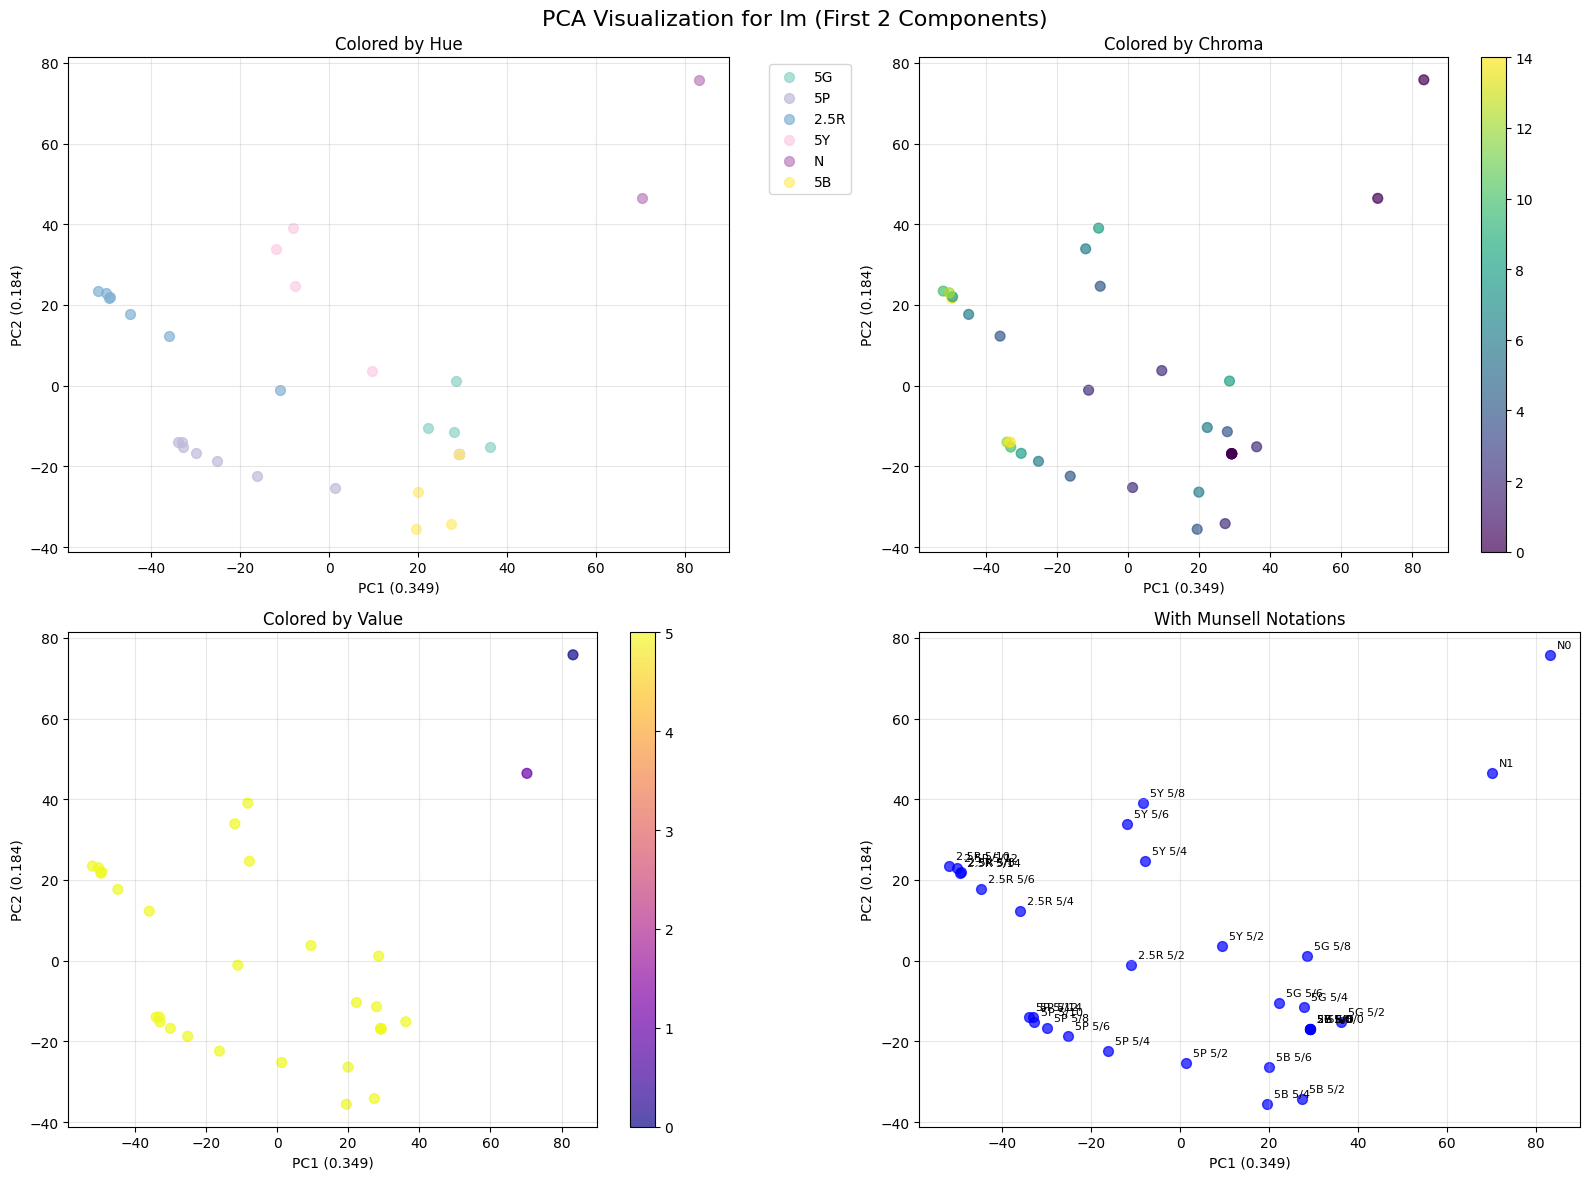

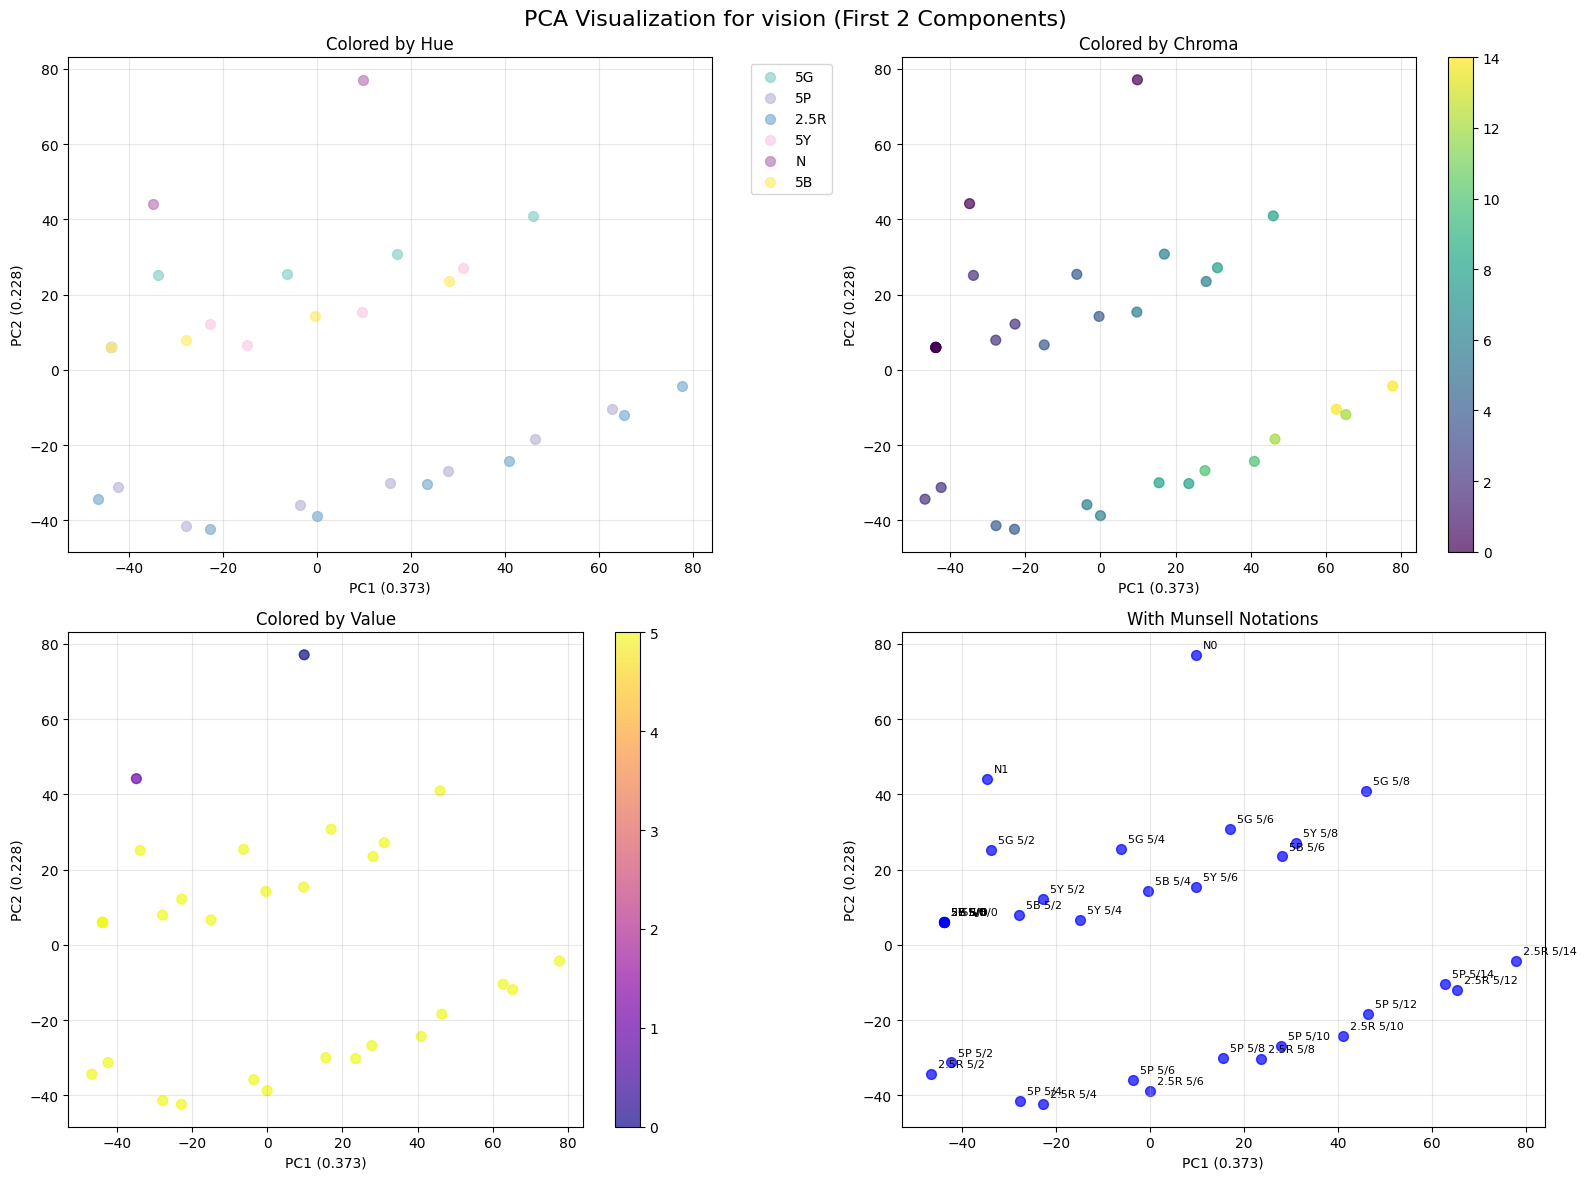

In [223]:
# Visualize PCA results in 2D
def plot_pca_2d(pca_results, color_metadata, embedding_name):
    """Plot first 2 PCA components colored by color attributes"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    pca_result = pca_results[embedding_name]['pca_result']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'PCA Visualization for {embedding_name} (First 2 Components)', fontsize=16)
    
    # Extract color information
    hues = [meta.get('H', 'Unknown') for meta in color_metadata]
    chromas = [meta.get('C', 0) for meta in color_metadata]
    values = [meta.get('V', 0) for meta in color_metadata]
    notations = [meta.get('notation', 'Unknown') for meta in color_metadata]
    
    # Plot 1: Colored by Hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[0,0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    axes[0,0].set_title('Colored by Hue')
    axes[0,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Colored by Chroma
    scatter = axes[0,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=chromas, cmap='viridis', alpha=0.7, s=50)
    axes[0,1].set_title('Colored by Chroma')
    axes[0,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[0,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[0,1])
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Colored by Value
    scatter = axes[1,0].scatter(pca_result[:, 0], pca_result[:, 1], 
                               c=values, cmap='plasma', alpha=0.7, s=50)
    axes[1,0].set_title('Colored by Value')
    axes[1,0].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,0].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    plt.colorbar(scatter, ax=axes[1,0])
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All points with notation labels
    axes[1,1].scatter(pca_result[:, 0], pca_result[:, 1], 
                     c='blue', alpha=0.7, s=50)
    # Add notation labels
    for i, notation in enumerate(notations):
        axes[1,1].annotate(notation, (pca_result[i, 0], pca_result[i, 1]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_title('With Munsell Notations')
    axes[1,1].set_xlabel(f'PC1 ({pca_results[embedding_name]["explained_variance_ratio"][0]:.3f})')
    axes[1,1].set_ylabel(f'PC2 ({pca_results[embedding_name]["explained_variance_ratio"][1]:.3f})')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot PCA 2D results for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_pca_2d(pca_results, color_meta, emb_type)


In [224]:
# Summary and comparison of results
def print_analysis_summary(pca_results, tsne_results):
    """Print summary of analysis results"""
    print("=" * 80)
    print("EMBEDDING ANALYSIS SUMMARY")
    print("=" * 80)
    
    for emb_type in ['lm', 'vision', 'lens']:
        emb_name = {'lm': 'LM Pooled Mean', 'vision': 'Vision Pooled Mean', 'lens': 'Visual Token Lens'}[emb_type]
        
        print(f"\n{emb_name.upper()}:")
        print("-" * 40)
        
        if emb_type in pca_results and pca_results[emb_type] is not None:
            pca = pca_results[emb_type]
            print(f"PCA Results:")
            print(f"  - Components for 95% variance: {pca['n_components_95']}")
            print(f"  - Components for 99% variance: {pca['n_components_99']}")
            print(f"  - First 2 components explain: {pca['cumulative_variance'][1]:.3f} of variance")
            print(f"  - First 5 components explain: {pca['cumulative_variance'][4]:.3f} of variance")
        else:
            print("  - PCA: No data available")
            
        if emb_type in tsne_results and tsne_results[emb_type] is not None:
            tsne = tsne_results[emb_type]
            print(f"t-SNE Results:")
            print(f"  - Final KL divergence: {tsne['tsne_model'].kl_divergence_:.3f}")
            print(f"  - Perplexity used: {tsne['tsne_model'].perplexity}")
        else:
            print("  - t-SNE: No data available")

print_analysis_summary(pca_results, tsne_results)

# Additional analysis: Compare embedding types
print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS")
print("=" * 80)

# Compare PCA effectiveness across embedding types
print("\nPCA Effectiveness Comparison:")
print("Embedding Type | 95% Var Components | 99% Var Components | PC1+PC2 Var")
print("-" * 70)

for emb_type in ['lm', 'vision', 'lens']:
    emb_name = {'lm': 'LM Pooled Mean', 'vision': 'Vision Pooled Mean', 'lens': 'Visual Token Lens'}[emb_type]
    if emb_type in pca_results and pca_results[emb_type] is not None:
        pca = pca_results[emb_type]
        pc1_pc2_var = pca['cumulative_variance'][1]
        print(f"{emb_name:15} | {pca['n_components_95']:18} | {pca['n_components_99']:18} | {pc1_pc2_var:.3f}")
    else:
        print(f"{emb_name:15} | {'N/A':18} | {'N/A':18} | N/A")


EMBEDDING ANALYSIS SUMMARY

LM POOLED MEAN:
----------------------------------------
PCA Results:
  - Components for 95% variance: 7
  - Components for 99% variance: 11
  - First 2 components explain: 0.533 of variance
  - First 5 components explain: 0.905 of variance
t-SNE Results:
  - Final KL divergence: 0.108
  - Perplexity used: 7

VISION POOLED MEAN:
----------------------------------------
PCA Results:
  - Components for 95% variance: 7
  - Components for 99% variance: 10
  - First 2 components explain: 0.601 of variance
  - First 5 components explain: 0.913 of variance
t-SNE Results:
  - Final KL divergence: 0.168
  - Perplexity used: 7

VISUAL TOKEN LENS:
----------------------------------------
  - PCA: No data available
  - t-SNE: No data available

COMPARATIVE ANALYSIS

PCA Effectiveness Comparison:
Embedding Type | 95% Var Components | 99% Var Components | PC1+PC2 Var
----------------------------------------------------------------------
LM Pooled Mean  |                  

# Анализ корреляции эмбеддингов визуальнового и языкового слоя

## Проверить, сохраняют ли эмбеддинги (визуальные и языковые) информацию о цветовых характеристиках объектов (Hue, Chroma, Value).
Если модель действительно захватывает смысловую или визуальную семантику, то направления или расстояния в эмбеддинговом пространстве должны коррелировать с координатами H, C и V.

In [225]:
import scipy
from scipy.stats import pearsonr

# Additional analysis: Chroma progression analysis
def analyze_chroma_progression(pca_results, tsne_results, color_metadata, embedding_name):
    """Analyze how chroma progression is captured in embeddings"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Chroma Progression Analysis for {embedding_name} ===")
    
    # Group by hue and analyze chroma progression
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        chroma = meta.get('C', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, chroma, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by chroma
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # Analyze t-SNE progression
    if embedding_name in tsne_results and tsne_results[embedding_name] is not None:
        tsne_result = tsne_results[embedding_name]['tsne_result']
        print("\nt-SNE Chroma Progression:")
        for hue, samples in hue_groups.items():
            if len(samples) > 1:
                indices = [s[0] for s in samples]
                chromas = [s[1] for s in samples]
                tsne_x = tsne_result[indices, 0]
                tsne_y = tsne_result[indices, 1]
                
                # Calculate distance progression
                distances = []
                cosine_distances = []
                chromas_dist = []
                
                # Get the original embeddings for cosine distance calculation
                if embedding_name == 'lm':
                    embeddings = lm_matrix[indices]
                elif embedding_name == 'vision':
                    embeddings = vision_matrix[indices]
                else:
                    embeddings = None
                
                for i in range(len(indices) - 1):
                    # Euclidean distance in t-SNE space
                    dist = np.sqrt((tsne_x[i+1] - tsne_x[i])**2 + (tsne_y[i+1] - tsne_y[i])**2)
                    distances.append(dist)
                    
                    # Cosine distance in original embedding space
                    if embeddings is not None:
                        # Normalize vectors
                        vec_i = embeddings[i] / np.linalg.norm(embeddings[i])
                        vec_j = embeddings[i+1] / np.linalg.norm(embeddings[i+1])
                        # Calculate cosine similarity, then convert to distance
                        cosine_sim = np.dot(vec_i, vec_j)
                        cosine_dist = 1 - cosine_sim  # Convert similarity to distance
                        cosine_distances.append(cosine_dist)
                    
                    chromas_dist.append(chromas[i+1] - chromas[i])
                    
                if len(distances) < 2: continue
                
                print(f"  {hue}: Average step distance = {np.mean(distances):.3f}")
                print(f"    Chroma steps: {chromas_dist}")
                print(f"    Step distances (Euclidean): {distances}")
                print(f"    Variation (Euclidean): {np.std(distances) / np.mean(distances):.3f}")
                
                if cosine_distances:
                    print(f"    Cosine distances: {cosine_distances}")
                    print(f"    Average cosine distance: {np.mean(cosine_distances):.6f}")
                    print(f"    Variation (Cosine): {np.std(cosine_distances) / np.mean(cosine_distances):.3f}")
                    
                    # Calculate correlation between Euclidean and cosine distances
                    if len(distances) > 1 and len(cosine_distances) > 1:
                        correlation = pearsonr(distances, cosine_distances)
                        print(f"    Euclidean vs Cosine correlation: {correlation.statistic:.4f} (p={correlation.pvalue:.4f})")

# Perform chroma progression analysis for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        analyze_chroma_progression(pca_results, tsne_results, color_meta, emb_type)



=== Chroma Progression Analysis for lm ===

t-SNE Chroma Progression:
  2.5R: Average step distance = 10.739
    Chroma steps: [2, 2, 2, 2, 2, 2, 2]
    Step distances (Euclidean): [31.259516, 9.7655277, 6.7008309, 6.9645143, 6.9018149, 7.2213464, 6.3615384]
    Variation (Euclidean): 0.786
    Cosine distances: [0.024610996, 0.0095114708, 0.0028918982, 0.0033715963, 0.0025461912, 0.002715528, 0.0017143488]
    Average cosine distance: 0.006766
    Variation (Cosine): 1.134
    Euclidean vs Cosine correlation: 0.9802 (p=0.0001)
  5Y: Average step distance = 11.881
    Chroma steps: [2, 2, 2, 2]
    Step distances (Euclidean): [26.582401, 8.7574615, 6.2866564, 5.8994565]
    Variation (Euclidean): 0.720
    Cosine distances: [0.01499337, 0.011190057, 0.0032765865, 0.0035960078]
    Average cosine distance: 0.008264
    Variation (Cosine): 0.607
    Euclidean vs Cosine correlation: 0.8486 (p=0.1514)
  5B: Average step distance = 11.742
    Chroma steps: [2, 2, 2]
    Step distances (Euc


=== Step Distance vs Embedding Distance Analysis for lm ===


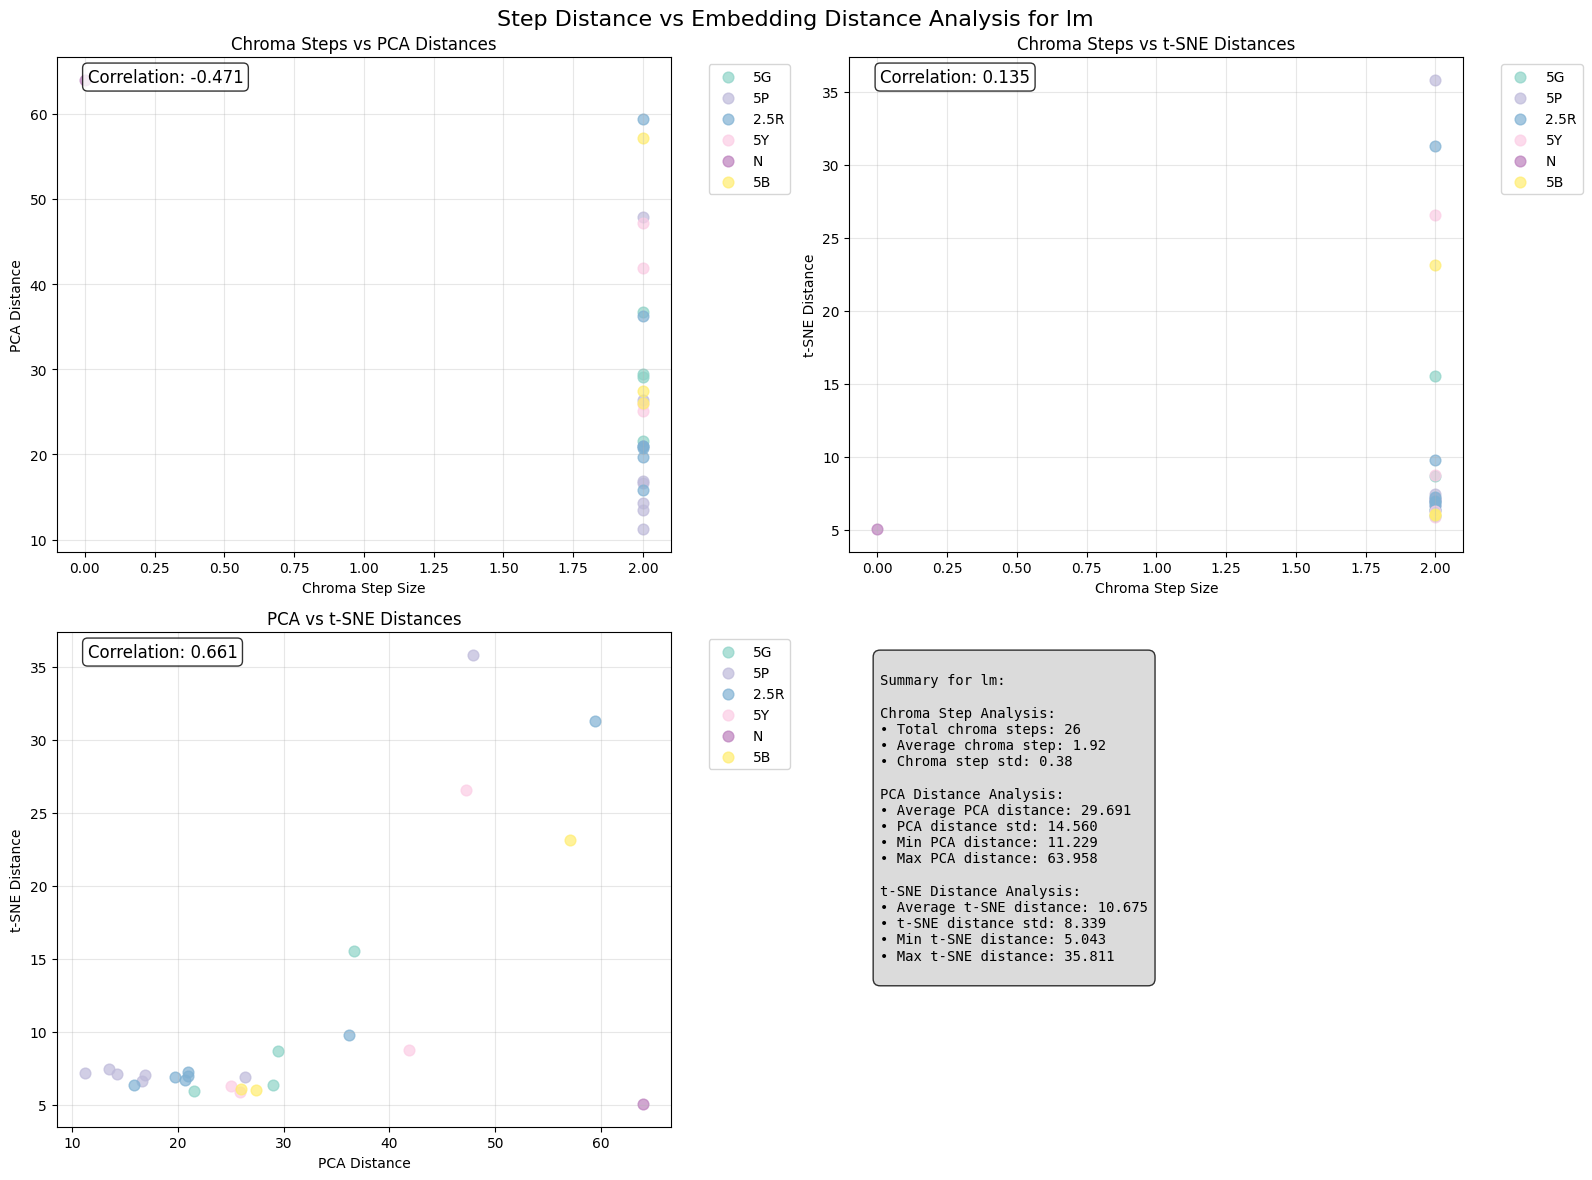


Detailed Correlation Analysis:
Chroma Steps vs PCA Distance: -0.471
Chroma Steps vs t-SNE Distance: 0.135
PCA Distance vs t-SNE Distance: 0.661

=== Step Distance vs Embedding Distance Analysis for vision ===


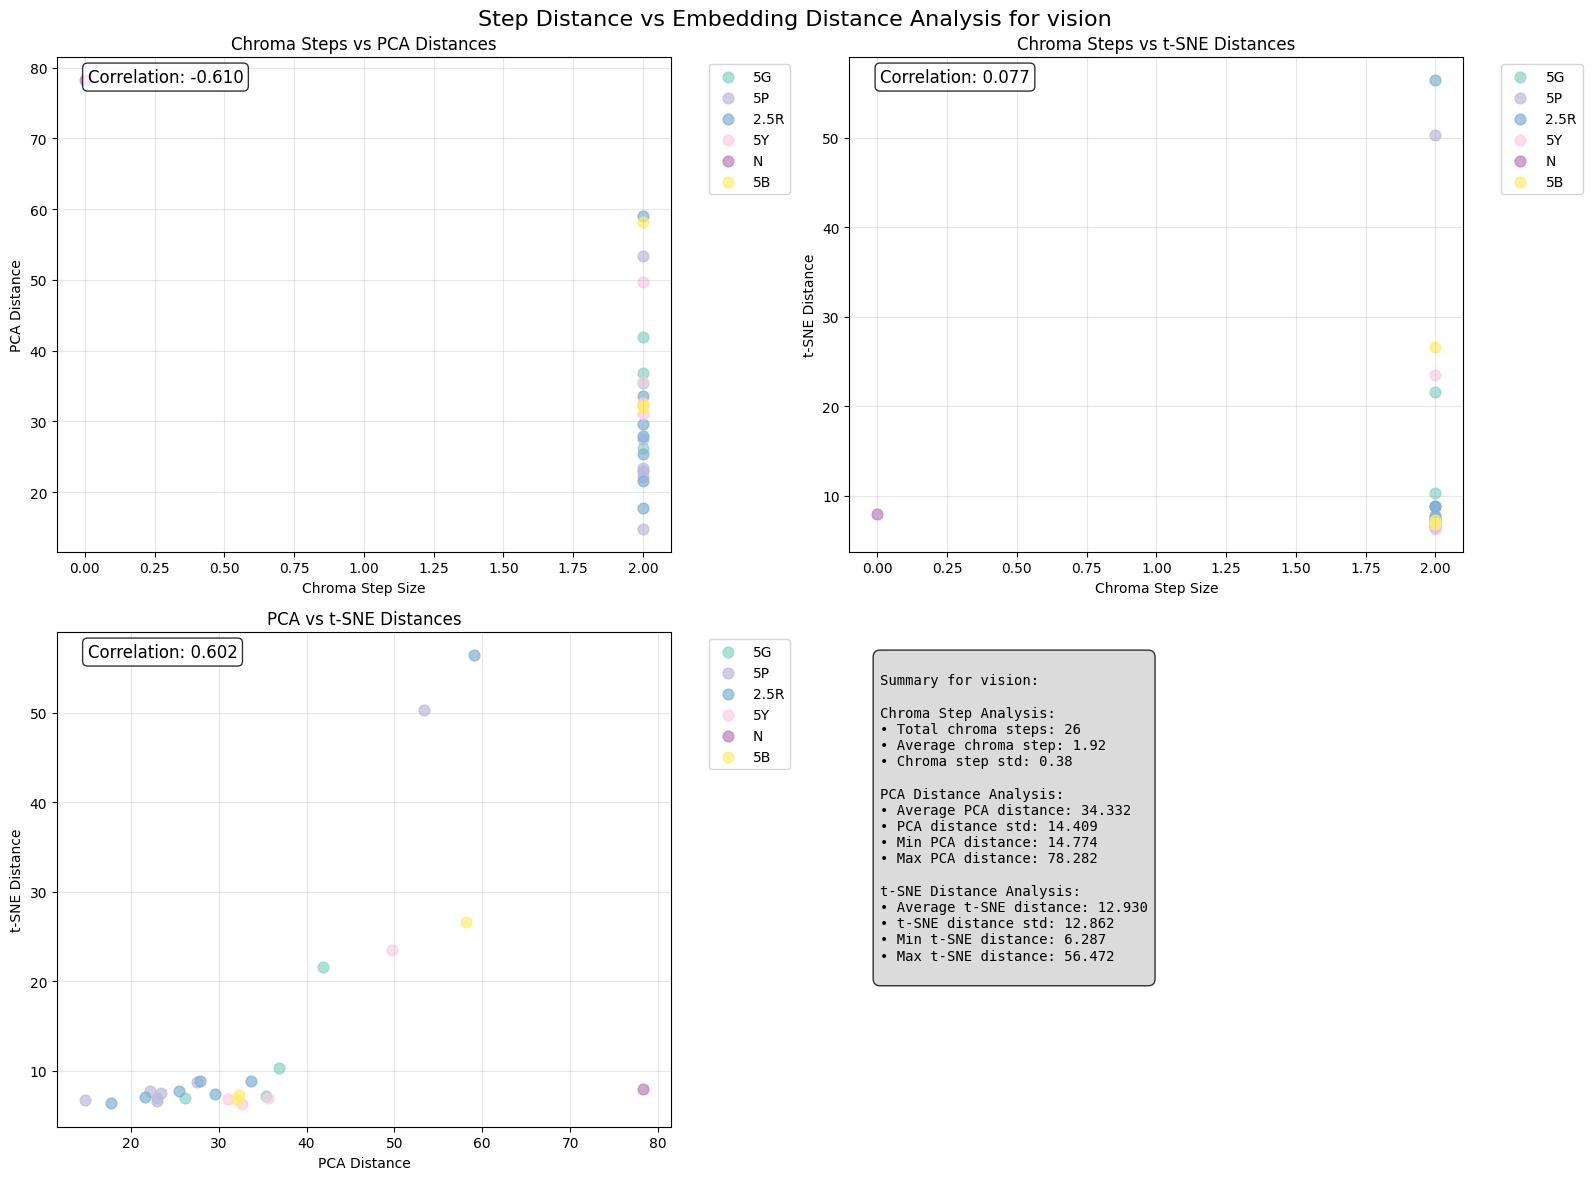


Detailed Correlation Analysis:
Chroma Steps vs PCA Distance: -0.610
Chroma Steps vs t-SNE Distance: 0.077
PCA Distance vs t-SNE Distance: 0.602


In [226]:
# Plot step distance vs PCA/t-SNE distance analysis
def plot_step_vs_embedding_distance(pca_results, tsne_results, color_metadata, embedding_name):
    """Plot step distances (chroma progression) vs PCA/t-SNE distances"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Step Distance vs Embedding Distance Analysis for {embedding_name} ===")
    
    # Group by hue and analyze chroma progression
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        chroma = meta.get('C', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, chroma, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by chroma
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # Collect data for plotting
    chroma_steps = []
    pca_distances = []
    tsne_distances = []
    hue_labels = []
    
    pca_result = pca_results[embedding_name]['pca_result']
    tsne_result = tsne_results[embedding_name]['tsne_result'] if embedding_name in tsne_results else None
    
    for hue, samples in hue_groups.items():
        if len(samples) > 1:  # Only analyze hues with multiple chroma levels
            indices = [s[0] for s in samples]
            chromas = [s[1] for s in samples]
            
            # Calculate chroma step sizes
            chroma_steps_hue = []
            for i in range(len(chromas) - 1):
                chroma_steps_hue.append(chromas[i+1] - chromas[i])
            
            # Calculate PCA distances
            pca_distances_hue = []
            for i in range(len(indices) - 1):
                pca_dist = np.linalg.norm(pca_result[indices[i+1]] - pca_result[indices[i]])
                pca_distances_hue.append(pca_dist)
            
            # Calculate t-SNE distances
            tsne_distances_hue = []
            if tsne_result is not None:
                for i in range(len(indices) - 1):
                    tsne_dist = np.linalg.norm(tsne_result[indices[i+1]] - tsne_result[indices[i]])
                    tsne_distances_hue.append(tsne_dist)
            
            # Store data
            chroma_steps.extend(chroma_steps_hue)
            pca_distances.extend(pca_distances_hue)
            if tsne_result is not None:
                tsne_distances.extend(tsne_distances_hue)
            hue_labels.extend([hue] * len(chroma_steps_hue))
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Step Distance vs Embedding Distance Analysis for {embedding_name}', fontsize=16)
    
    # Plot 1: Chroma steps vs PCA distances
    unique_hues = list(set(hue_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hue_labels]
        hue_chroma_steps = [chroma_steps[i] for i, m in enumerate(mask) if m]
        hue_pca_distances = [pca_distances[i] for i, m in enumerate(mask) if m]
        
        axes[0,0].scatter(hue_chroma_steps, hue_pca_distances, 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=60)
    
    axes[0,0].set_xlabel('Chroma Step Size')
    axes[0,0].set_ylabel('PCA Distance')
    axes[0,0].set_title('Chroma Steps vs PCA Distances')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # Calculate and display correlation
    if len(chroma_steps) > 1:
        pca_correlation = np.corrcoef(chroma_steps, pca_distances)[0, 1]
        axes[0,0].text(0.05, 0.95, f'Correlation: {pca_correlation:.3f}', 
                      transform=axes[0,0].transAxes, fontsize=12, 
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Plot 2: Chroma steps vs t-SNE distances
    if tsne_result is not None and len(tsne_distances) > 0:
        for hue in unique_hues:
            mask = [h == hue for h in hue_labels]
            hue_chroma_steps = [chroma_steps[i] for i, m in enumerate(mask) if m]
            hue_tsne_distances = [tsne_distances[i] for i, m in enumerate(mask) if m]
            
            axes[0,1].scatter(hue_chroma_steps, hue_tsne_distances, 
                             c=[hue_color_map[hue]], label=hue, alpha=0.7, s=60)
        
        axes[0,1].set_xlabel('Chroma Step Size')
        axes[0,1].set_ylabel('t-SNE Distance')
        axes[0,1].set_title('Chroma Steps vs t-SNE Distances')
        axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,1].grid(True, alpha=0.3)
        
        # Calculate and display correlation
        if len(chroma_steps) > 1:
            tsne_correlation = np.corrcoef(chroma_steps, tsne_distances)[0, 1]
            axes[0,1].text(0.05, 0.95, f'Correlation: {tsne_correlation:.3f}', 
                          transform=axes[0,1].transAxes, fontsize=12, 
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        axes[0,1].text(0.5, 0.5, 'No t-SNE data available', 
                      transform=axes[0,1].transAxes, ha='center', va='center', fontsize=14)
        axes[0,1].set_title('Chroma Steps vs t-SNE Distances')
    
    # Plot 3: PCA vs t-SNE distances
    if tsne_result is not None and len(tsne_distances) > 0:
        for hue in unique_hues:
            mask = [h == hue for h in hue_labels]
            hue_pca_distances = [pca_distances[i] for i, m in enumerate(mask) if m]
            hue_tsne_distances = [tsne_distances[i] for i, m in enumerate(mask) if m]
            
            axes[1,0].scatter(hue_pca_distances, hue_tsne_distances, 
                             c=[hue_color_map[hue]], label=hue, alpha=0.7, s=60)
        
        axes[1,0].set_xlabel('PCA Distance')
        axes[1,0].set_ylabel('t-SNE Distance')
        axes[1,0].set_title('PCA vs t-SNE Distances')
        axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1,0].grid(True, alpha=0.3)
        
        # Calculate and display correlation
        if len(pca_distances) > 1:
            pca_tsne_correlation = np.corrcoef(pca_distances, tsne_distances)[0, 1]
            axes[1,0].text(0.05, 0.95, f'Correlation: {pca_tsne_correlation:.3f}', 
                          transform=axes[1,0].transAxes, fontsize=12, 
                          bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        axes[1,0].text(0.5, 0.5, 'No t-SNE data available', 
                      transform=axes[1,0].transAxes, ha='center', va='center', fontsize=14)
        axes[1,0].set_title('PCA vs t-SNE Distances')
    
    # Plot 4: Summary statistics
    axes[1,1].axis('off')
    summary_text = f"""
Summary for {embedding_name}:

Chroma Step Analysis:
• Total chroma steps: {len(chroma_steps)}
• Average chroma step: {np.mean(chroma_steps):.2f}
• Chroma step std: {np.std(chroma_steps):.2f}

PCA Distance Analysis:
• Average PCA distance: {np.mean(pca_distances):.3f}
• PCA distance std: {np.std(pca_distances):.3f}
• Min PCA distance: {np.min(pca_distances):.3f}
• Max PCA distance: {np.max(pca_distances):.3f}
"""
    
    if tsne_result is not None and len(tsne_distances) > 0:
        summary_text += f"""
t-SNE Distance Analysis:
• Average t-SNE distance: {np.mean(tsne_distances):.3f}
• t-SNE distance std: {np.std(tsne_distances):.3f}
• Min t-SNE distance: {np.min(tsne_distances):.3f}
• Max t-SNE distance: {np.max(tsne_distances):.3f}
"""
    
    axes[1,1].text(0.05, 0.95, summary_text, transform=axes[1,1].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed correlation analysis
    print(f"\nDetailed Correlation Analysis:")
    if len(chroma_steps) > 1:
        pca_correlation = np.corrcoef(chroma_steps, pca_distances)[0, 1]
        print(f"Chroma Steps vs PCA Distance: {pca_correlation:.3f}")
        
        if tsne_result is not None and len(tsne_distances) > 0:
            tsne_correlation = np.corrcoef(chroma_steps, tsne_distances)[0, 1]
            pca_tsne_correlation = np.corrcoef(pca_distances, tsne_distances)[0, 1]
            print(f"Chroma Steps vs t-SNE Distance: {tsne_correlation:.3f}")
            print(f"PCA Distance vs t-SNE Distance: {pca_tsne_correlation:.3f}")

# Plot step distance analysis for all embedding types
for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {'lm': lm_color_meta, 'vision': vision_color_meta, 'lens': lens_color_meta}[emb_type]
        plot_step_vs_embedding_distance(pca_results, tsne_results, color_meta, emb_type)



=== Cumulative Distance Analysis for lm ===


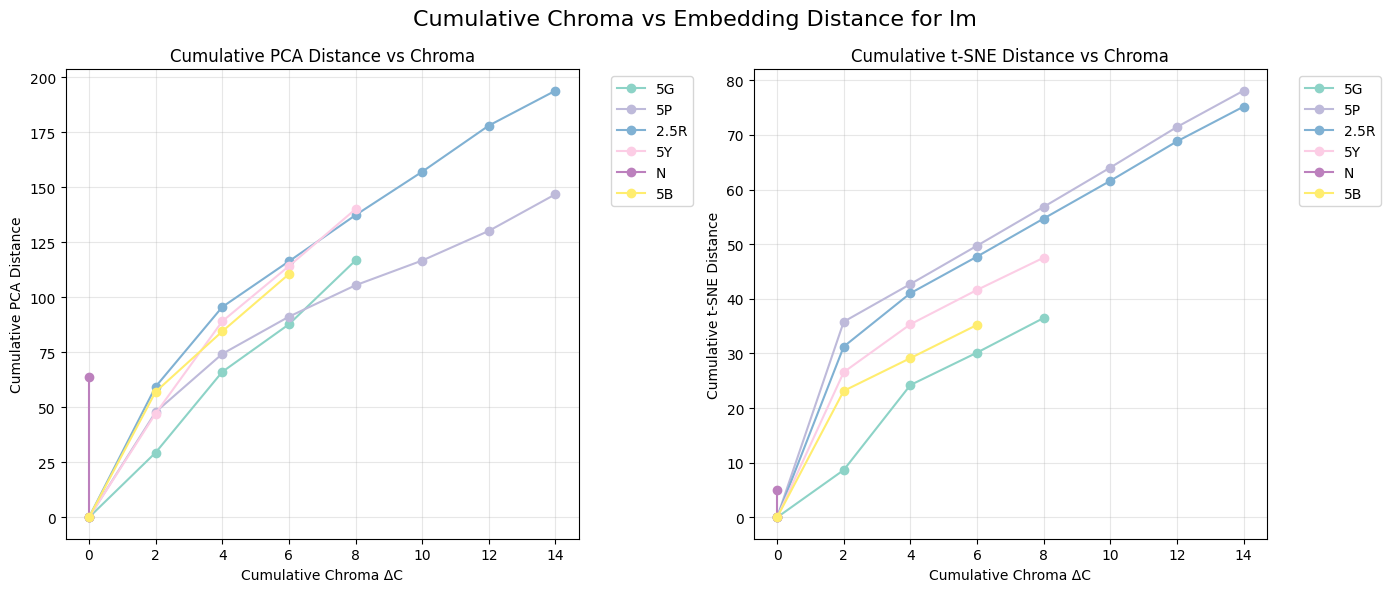

Cumulative Chroma vs PCA Distance corr = 0.929
Cumulative Chroma vs t-SNE Distance corr = 0.943

=== Cumulative Distance Analysis for vision ===


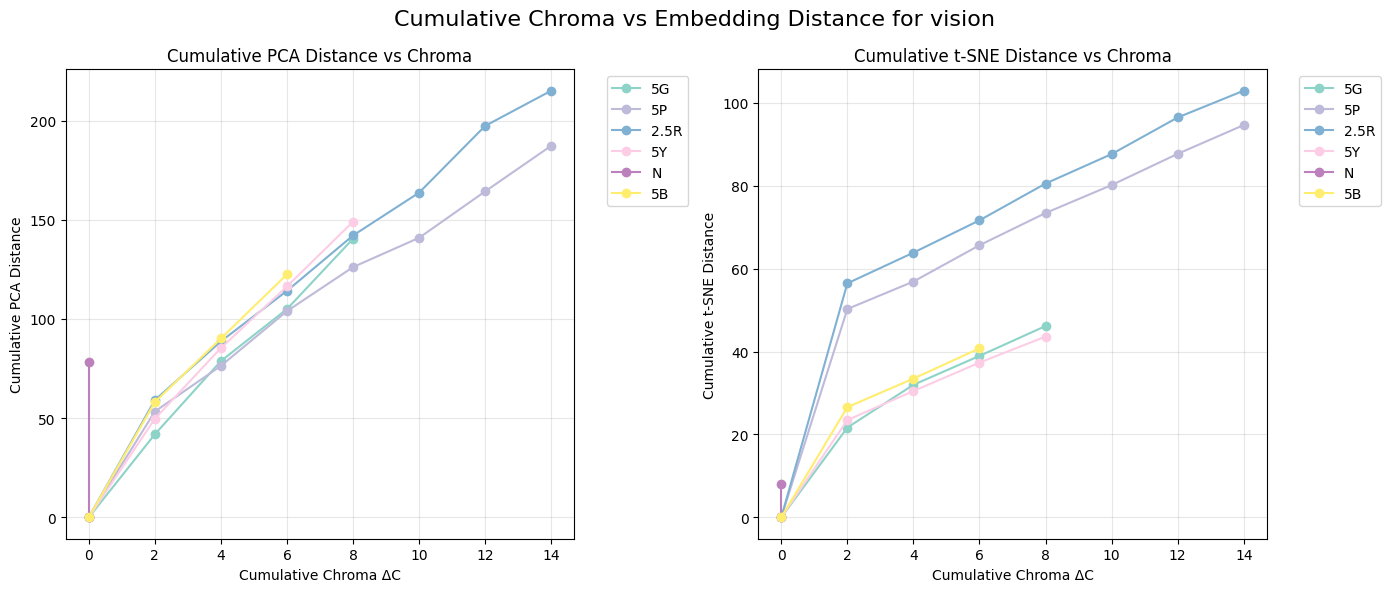

Cumulative Chroma vs PCA Distance corr = 0.959
Cumulative Chroma vs t-SNE Distance corr = 0.903


In [227]:
def plot_cumulative_chroma_vs_embedding_distance(pca_results, tsne_results, color_metadata, embedding_name):
    """Plot cumulative chroma (C) progression vs cumulative PCA/t-SNE distances"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Cumulative Distance Analysis for {embedding_name} ===")
    
    # Group by hue
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        chroma = meta.get('C', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, chroma, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by chroma
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # Collect data
    chroma_cum = []
    pca_cum = []
    tsne_cum = []
    hue_labels = []
    
    pca_result = pca_results[embedding_name]['pca_result']
    tsne_result = tsne_results.get(embedding_name, {}).get('tsne_result', None)
    
    for hue, samples in hue_groups.items():
        if len(samples) > 1:
            indices = [s[0] for s in samples]
            chromas = [s[1] for s in samples]
            
            # Cumulative chroma (normalized to start at 0)
            chroma_cumsum = np.array(chromas) - chromas[0]
            
            # Cumulative PCA distance
            pca_dists = [np.linalg.norm(pca_result[indices[i+1]] - pca_result[indices[i]]) 
                         for i in range(len(indices) - 1)]
            pca_cumsum = np.insert(np.cumsum(pca_dists), 0, 0)
            
            # Cumulative t-SNE distance
            if tsne_result is not None:
                tsne_dists = [np.linalg.norm(tsne_result[indices[i+1]] - tsne_result[indices[i]]) 
                              for i in range(len(indices) - 1)]
                tsne_cumsum = np.insert(np.cumsum(tsne_dists), 0, 0)
            else:
                tsne_cumsum = None
            
            # Store data
            chroma_cum.extend(chroma_cumsum)
            pca_cum.extend(pca_cumsum)
            if tsne_cumsum is not None:
                tsne_cum.extend(tsne_cumsum)
            hue_labels.extend([hue] * len(chroma_cumsum))
    
    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Cumulative Chroma vs Embedding Distance for {embedding_name}', fontsize=16)
    
    unique_hues = list(set(hue_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: colors[i] for i, hue in enumerate(unique_hues)}
    
    # Plot cumulative PCA distance
    for hue in unique_hues:
        mask = np.array(hue_labels) == hue
        axes[0].plot(np.array(chroma_cum)[mask], np.array(pca_cum)[mask],
                     marker='o', c=hue_color_map[hue], label=hue)
    axes[0].set_xlabel('Cumulative Chroma ΔC')
    axes[0].set_ylabel('Cumulative PCA Distance')
    axes[0].set_title('Cumulative PCA Distance vs Chroma')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot cumulative t-SNE distance
    if tsne_result is not None and len(tsne_cum) > 0:
        for hue in unique_hues:
            mask = np.array(hue_labels) == hue
            axes[1].plot(np.array(chroma_cum)[mask], np.array(tsne_cum)[mask],
                         marker='o', c=hue_color_map[hue], label=hue)
        axes[1].set_xlabel('Cumulative Chroma ΔC')
        axes[1].set_ylabel('Cumulative t-SNE Distance')
        axes[1].set_title('Cumulative t-SNE Distance vs Chroma')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[1].text(0.5, 0.5, 'No t-SNE data available', 
                     transform=axes[1].transAxes, ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation of cumulative distances
    if len(chroma_cum) > 2:
        pca_corr = np.corrcoef(chroma_cum, pca_cum)[0, 1]
        print(f"Cumulative Chroma vs PCA Distance corr = {pca_corr:.3f}")
        if tsne_result is not None and len(tsne_cum) > 0:
            tsne_corr = np.corrcoef(chroma_cum, tsne_cum)[0, 1]
            print(f"Cumulative Chroma vs t-SNE Distance corr = {tsne_corr:.3f}")

# plot_cumulative_chroma_vs_embedding_distance(
#     pca_results=pca_results,
#     tsne_results=tsne_results,
#     color_metadata=lm_color_meta,
#     embedding_name='lm'
# )

for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {
            'lm': lm_color_meta,
            'vision': vision_color_meta,
            'lens': lens_color_meta
        }[emb_type]
        
        plot_cumulative_chroma_vs_embedding_distance(
            pca_results=pca_results,
            tsne_results=tsne_results,
            color_metadata=color_meta,
            embedding_name=emb_type
        )


=== Cumulative Value Distance Analysis for lm ===


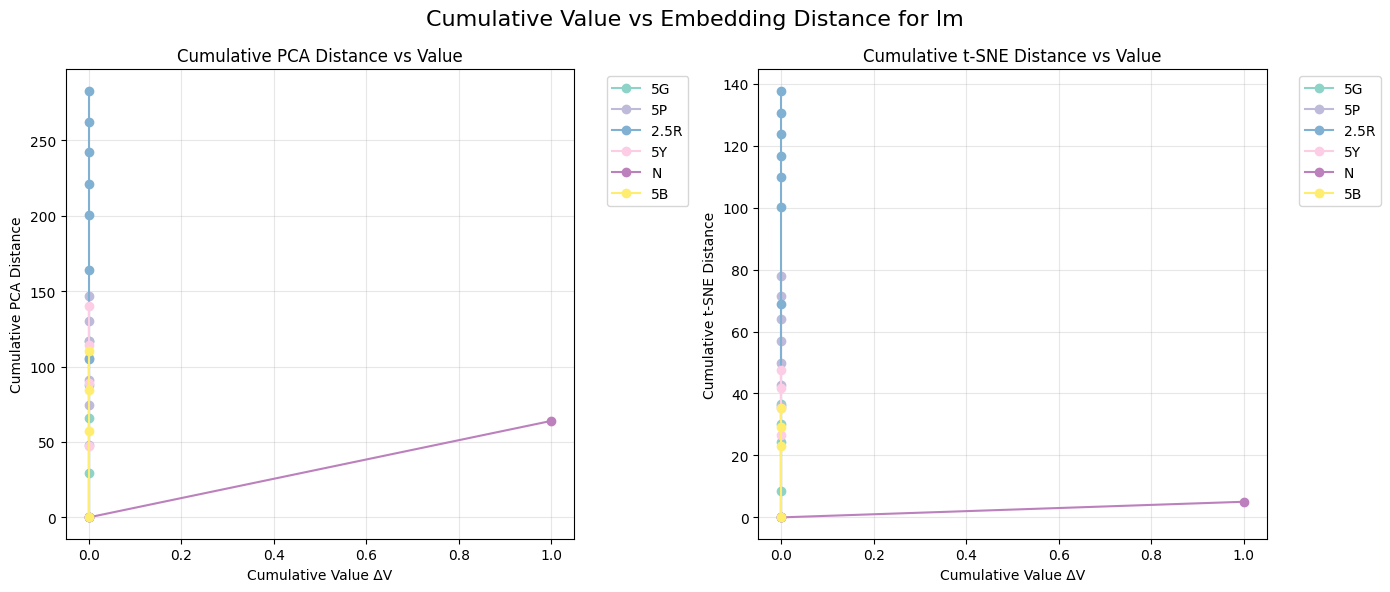

Cumulative Value vs PCA Distance corr = -0.084
Cumulative Value vs t-SNE Distance corr = -0.186

=== Cumulative Value Distance Analysis for vision ===


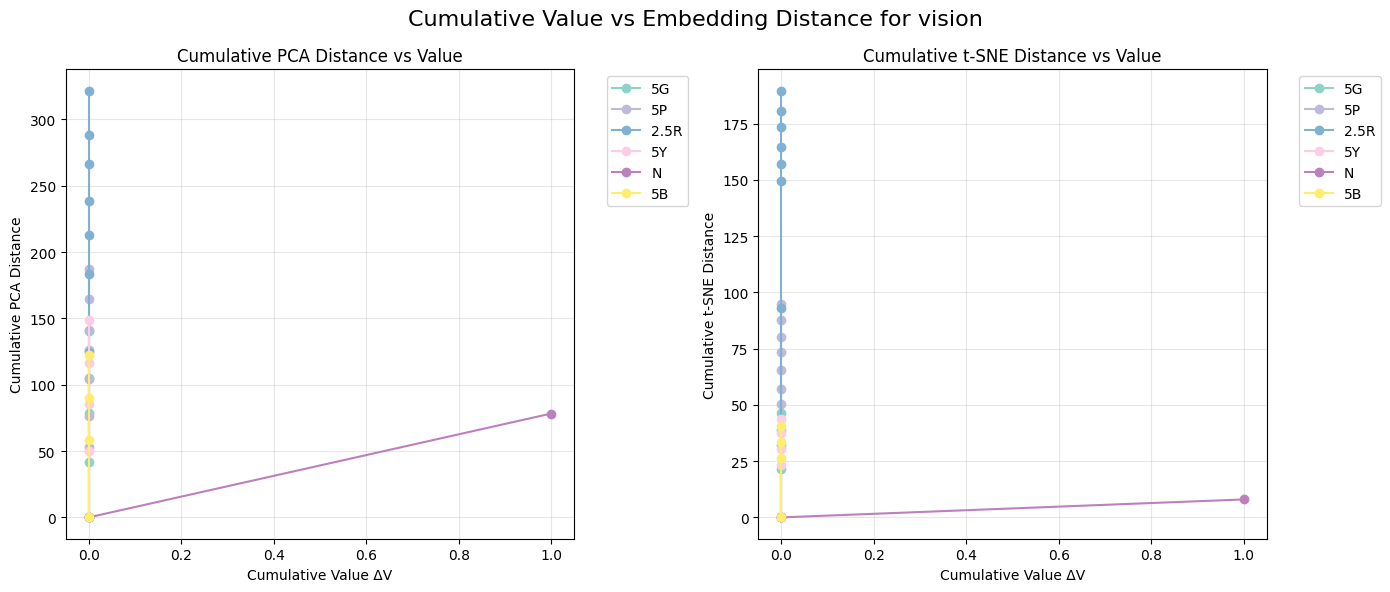

Cumulative Value vs PCA Distance corr = -0.072
Cumulative Value vs t-SNE Distance corr = -0.168


In [228]:
def plot_cumulative_value_vs_embedding_distance(pca_results, tsne_results, color_metadata, embedding_name):
    """Plot cumulative Value (V) progression vs cumulative PCA/t-SNE distances"""
    if embedding_name not in pca_results or pca_results[embedding_name] is None:
        return
    
    print(f"\n=== Cumulative Value Distance Analysis for {embedding_name} ===")
    
    # --- Group by hue ---
    hue_groups = {}
    for i, meta in enumerate(color_metadata):
        hue = meta.get('H', 'Unknown')
        value = meta.get('V', 0)
        if hue not in hue_groups:
            hue_groups[hue] = []
        hue_groups[hue].append((i, value, meta.get('notation', 'Unknown')))
    
    # Sort each hue group by Value (V)
    for hue in hue_groups:
        hue_groups[hue].sort(key=lambda x: x[1])
    
    # --- Collect cumulative data ---
    value_cum = []
    pca_cum = []
    tsne_cum = []
    hue_labels = []
    
    pca_result = pca_results[embedding_name]['pca_result']
    tsne_result = tsne_results.get(embedding_name, {}).get('tsne_result', None)
    
    for hue, samples in hue_groups.items():
        if len(samples) > 1:
            indices = [s[0] for s in samples]
            values = [s[1] for s in samples]
            
            # Cumulative Value (normalized from 0)
            value_cumsum = np.array(values) - values[0]
            
            # Cumulative PCA distance
            pca_dists = [np.linalg.norm(pca_result[indices[i+1]] - pca_result[indices[i]]) 
                         for i in range(len(indices) - 1)]
            pca_cumsum = np.insert(np.cumsum(pca_dists), 0, 0)
            
            # Cumulative t-SNE distance
            if tsne_result is not None:
                tsne_dists = [np.linalg.norm(tsne_result[indices[i+1]] - tsne_result[indices[i]]) 
                              for i in range(len(indices) - 1)]
                tsne_cumsum = np.insert(np.cumsum(tsne_dists), 0, 0)
            else:
                tsne_cumsum = None
            
            # Store results
            value_cum.extend(value_cumsum)
            pca_cum.extend(pca_cumsum)
            if tsne_cumsum is not None:
                tsne_cum.extend(tsne_cumsum)
            hue_labels.extend([hue] * len(value_cumsum))
    
    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Cumulative Value vs Embedding Distance for {embedding_name}', fontsize=16)
    
    unique_hues = list(set(hue_labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: colors[i] for i, hue in enumerate(unique_hues)}
    
    # Plot cumulative PCA distance
    for hue in unique_hues:
        mask = np.array(hue_labels) == hue
        axes[0].plot(np.array(value_cum)[mask], np.array(pca_cum)[mask],
                     marker='o', c=hue_color_map[hue], label=hue)
    axes[0].set_xlabel('Cumulative Value ΔV')
    axes[0].set_ylabel('Cumulative PCA Distance')
    axes[0].set_title('Cumulative PCA Distance vs Value')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot cumulative t-SNE distance
    if tsne_result is not None and len(tsne_cum) > 0:
        for hue in unique_hues:
            mask = np.array(hue_labels) == hue
            axes[1].plot(np.array(value_cum)[mask], np.array(tsne_cum)[mask],
                         marker='o', c=hue_color_map[hue], label=hue)
        axes[1].set_xlabel('Cumulative Value ΔV')
        axes[1].set_ylabel('Cumulative t-SNE Distance')
        axes[1].set_title('Cumulative t-SNE Distance vs Value')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[1].text(0.5, 0.5, 'No t-SNE data available', 
                     transform=axes[1].transAxes, ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # --- Correlation ---
    if len(value_cum) > 2:
        pca_corr = np.corrcoef(value_cum, pca_cum)[0, 1]
        print(f"Cumulative Value vs PCA Distance corr = {pca_corr:.3f}")
        if tsne_result is not None and len(tsne_cum) > 0:
            tsne_corr = np.corrcoef(value_cum, tsne_cum)[0, 1]
            print(f"Cumulative Value vs t-SNE Distance corr = {tsne_corr:.3f}")

for emb_type in ['lm', 'vision', 'lens']:
    if emb_type in pca_results:
        color_meta = {
            'lm': lm_color_meta,
            'vision': vision_color_meta,
            'lens': lens_color_meta
        }[emb_type]
        
        plot_cumulative_value_vs_embedding_distance(
            pca_results=pca_results,
            tsne_results=tsne_results,
            color_metadata=color_meta,
            embedding_name=emb_type
        )


In [229]:
vector_lm = embeddings_data['lm_pooled_mean'][0]
vector_v = embeddings_data['vision_pooled_mean'][0]

vector_lm /= np.linalg.norm(vector_lm, 2)
vector_v /= np.linalg.norm(vector_v, 2)

print(vector_lm @ vector_v)

0.0307042


In [230]:
vector_v

array([-0.0447949 ,  0.00206865,  0.00407509, ..., -0.0148072 ,
        0.004915  , -0.01816682], dtype=float32)

In [231]:
vector_lm

array([ 0.02879288,  0.02175462,  0.01079733, ...,  0.0003874 ,
        0.00543866,  0.00379906], dtype=float32)


CROSS-EMBEDDING CORRELATION ANALYSIS (Vision vs LM)


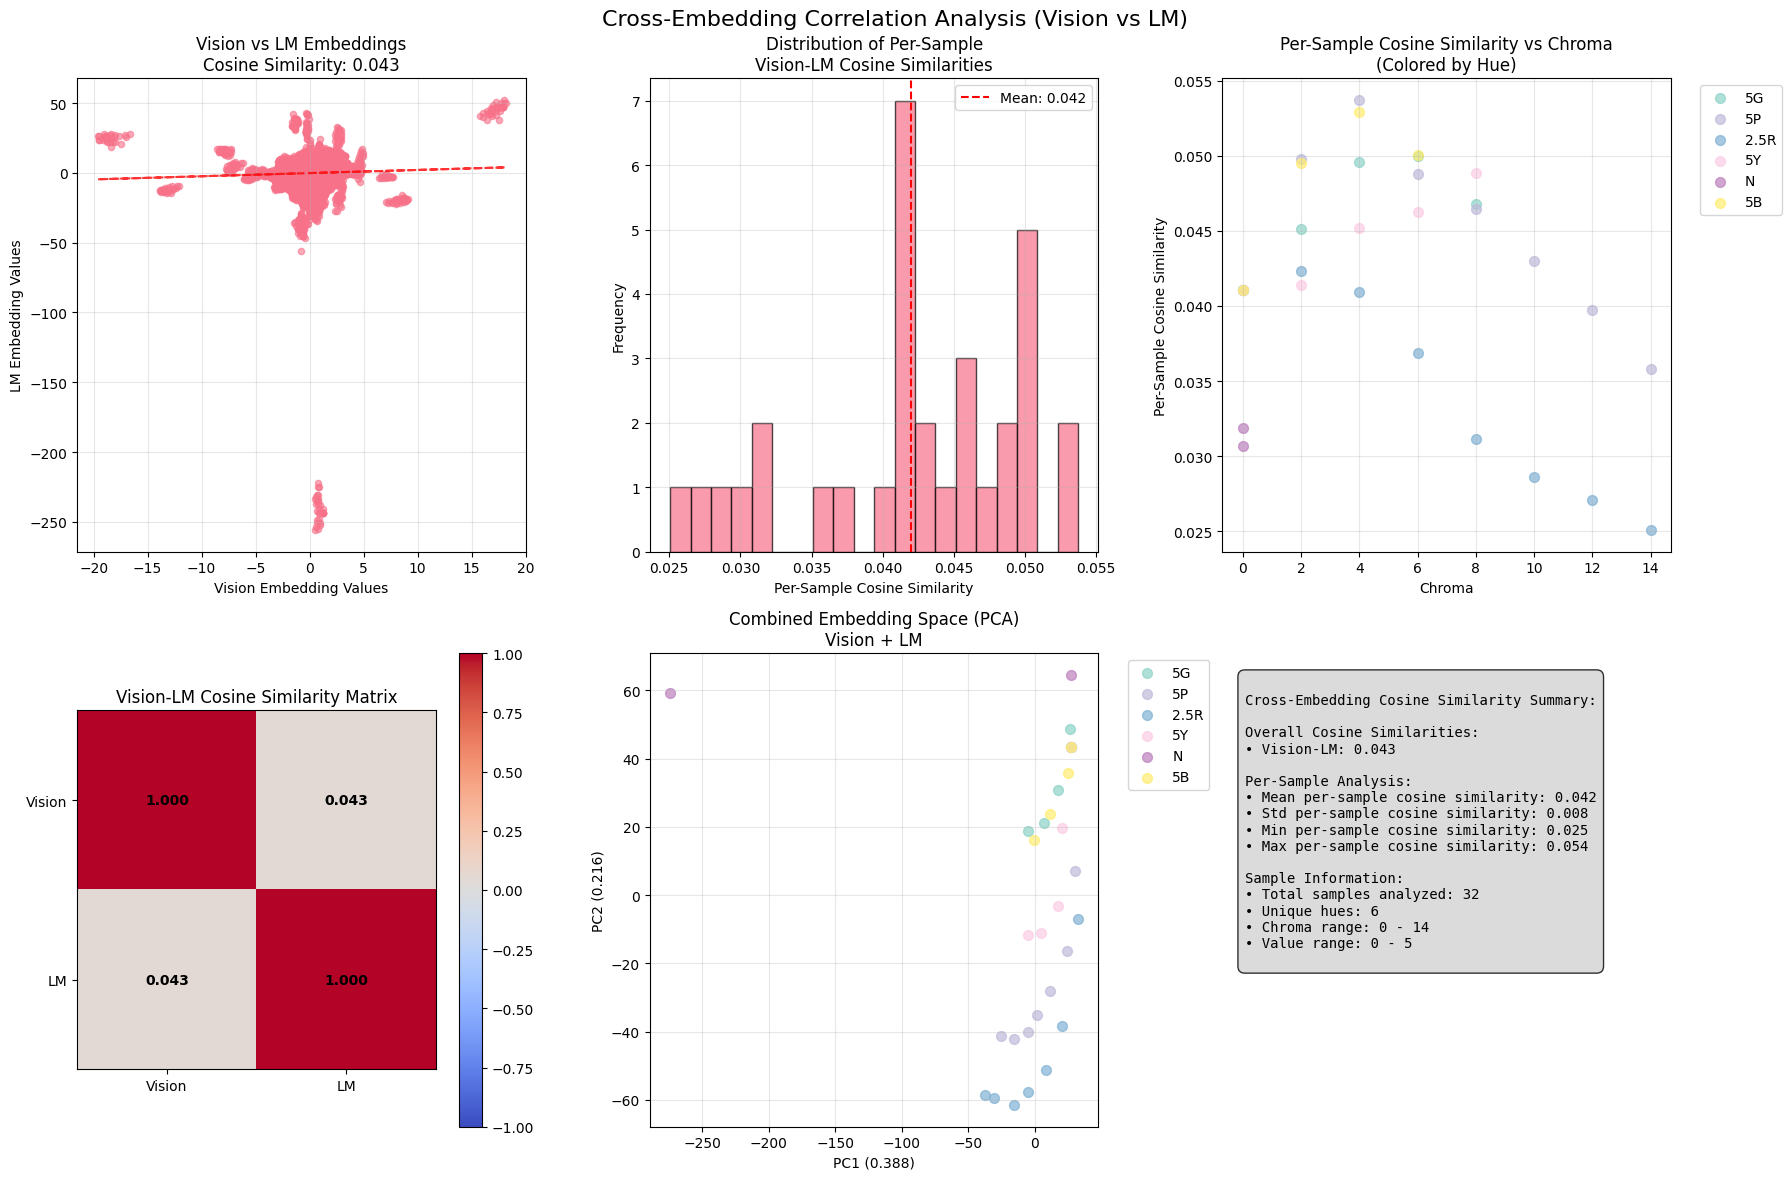


Detailed Cross-Embedding Analysis:
Vision-LM Cosine Similarity: 0.043
Average Cosine Similarity: 0.042

Per-Sample Cosine Similarity Statistics:
  Mean: 0.042
  Std:  0.008
  Min:  0.025
  Max:  0.054

Per-Sample Cosine Similarity by Hue:
  5G: 0.046 ± 0.003 (n=5)
  5P: 0.045 ± 0.006 (n=8)
  2.5R: 0.034 ± 0.007 (n=8)
  5Y: 0.045 ± 0.003 (n=5)
  N: 0.031 ± 0.001 (n=2)
  5B: 0.048 ± 0.004 (n=4)


In [232]:
# Cross-embedding correlation analysis (Vision vs LM only)
def analyze_cross_embedding_correlations(embeddings_data, color_metadata):
    """Analyze correlations between Vision and LM embeddings for the same colors"""
    print("\n" + "=" * 80)
    print("CROSS-EMBEDDING CORRELATION ANALYSIS (Vision vs LM)")
    print("=" * 80)
    
    # Prepare embedding matrices (only Vision and LM)
    lm_matrix, lm_valid_indices = prepare_embedding_matrix(embeddings_data['lm_pooled_mean'])
    vision_matrix, vision_valid_indices = prepare_embedding_matrix(embeddings_data['vision_pooled_mean'])
    
    if lm_matrix is None or vision_matrix is None:
        print("Cannot perform cross-embedding analysis: missing LM or Vision embeddings")
        return
    
    # Find common indices between Vision and LM
    common_indices = set(lm_valid_indices) & set(vision_valid_indices)
    
    if len(common_indices) < 2:
        print("Not enough common samples for correlation analysis")
        return
    
    # Sort common indices to maintain order
    common_indices = sorted(list(common_indices))
    
    # Extract embeddings for common samples
    lm_common = lm_matrix[[lm_valid_indices.index(i) for i in common_indices]]
    vision_common = vision_matrix[[vision_valid_indices.index(i) for i in common_indices]]
    
    # Get color metadata for common samples
    common_color_meta = []
    for i in common_indices:
        idx = embeddings_data['indices'][i]
        if idx in index_to_color:
            common_color_meta.append(index_to_color[idx])
        else:
            common_color_meta.append({'notation': f'Unknown_{idx}', 'H': 'Unknown', 'C': 0, 'V': 0})
    
    # Calculate cosine similarities (cosine of angle between vectors)
    def cosine_similarity(a, b):
        """Calculate cosine similarity between two vectors"""
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    correlations = {}
    
    # 1. Overall Vision vs LM cosine similarity (flattened)
    vision_lm_cosine = cosine_similarity(vision_common.flatten(), lm_common.flatten())
    correlations['Vision-LM'] = vision_lm_cosine
    
    # 2. Per-sample cosine similarities (between individual embedding vectors)
    per_sample_cosines = []
    for i in range(len(common_indices)):
        cosine_sim = cosine_similarity(vision_common[i], lm_common[i])
        per_sample_cosines.append(cosine_sim)
    
    # 3. Average cosine similarity across all samples
    avg_cosine_similarity = np.mean(per_sample_cosines)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cross-Embedding Correlation Analysis (Vision vs LM)', fontsize=16)
    
    # Plot 1: Vision vs LM scatter plot
    axes[0,0].scatter(vision_common.flatten(), lm_common.flatten(), alpha=0.6, s=20)
    axes[0,0].set_xlabel('Vision Embedding Values')
    axes[0,0].set_ylabel('LM Embedding Values')
    axes[0,0].set_title(f'Vision vs LM Embeddings\nCosine Similarity: {vision_lm_cosine:.3f}')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(vision_common.flatten(), lm_common.flatten(), 1)
    p = np.poly1d(z)
    axes[0,0].plot(vision_common.flatten(), p(vision_common.flatten()), "r--", alpha=0.8)
    
    # Plot 2: Per-sample cosine similarity distribution
    axes[0,1].hist(per_sample_cosines, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(avg_cosine_similarity, color='red', linestyle='--', 
                     label=f'Mean: {avg_cosine_similarity:.3f}')
    axes[0,1].set_xlabel('Per-Sample Cosine Similarity')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Per-Sample\nVision-LM Cosine Similarities')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Correlation by color attributes
    hues = [meta.get('H', 'Unknown') for meta in common_color_meta]
    chromas = [meta.get('C', 0) for meta in common_color_meta]
    values = [meta.get('V', 0) for meta in common_color_meta]
    
    # Color by hue
    unique_hues = list(set(hues))
    hue_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_hues)))
    hue_color_map = {hue: hue_colors[i] for i, hue in enumerate(unique_hues)}
    
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        hue_cosines = [per_sample_cosines[i] for i, m in enumerate(mask) if m]
        hue_chromas = [chromas[i] for i, m in enumerate(mask) if m]
        
        axes[0,2].scatter(hue_chromas, hue_cosines, 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    
    axes[0,2].set_xlabel('Chroma')
    axes[0,2].set_ylabel('Per-Sample Cosine Similarity')
    axes[0,2].set_title('Per-Sample Cosine Similarity vs Chroma\n(Colored by Hue)')
    axes[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Cosine similarity matrix heatmap (Vision vs LM only)
    cosine_matrix = np.array([
        [1.0, correlations['Vision-LM']],
        [correlations['Vision-LM'], 1.0]
    ])
    
    im = axes[1,0].imshow(cosine_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1,0].set_xticks([0, 1])
    axes[1,0].set_yticks([0, 1])
    axes[1,0].set_xticklabels(['Vision', 'LM'])
    axes[1,0].set_yticklabels(['Vision', 'LM'])
    axes[1,0].set_title('Vision-LM Cosine Similarity Matrix')
    
    # Add cosine similarity values to heatmap
    for i in range(2):
        for j in range(2):
            text = axes[1,0].text(j, i, f'{cosine_matrix[i, j]:.3f}',
                                ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=axes[1,0])
    
    # Plot 5: Embedding space comparison (first 2 PCA components)
    # Apply PCA to combined embeddings (Vision + LM only)
    combined_embeddings = np.hstack([vision_common, lm_common])
    
    pca_combined = PCA(n_components=2)
    pca_result_combined = pca_combined.fit_transform(StandardScaler().fit_transform(combined_embeddings))
    
    # Color by hue
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        axes[1,1].scatter(pca_result_combined[mask, 0], pca_result_combined[mask, 1], 
                         c=[hue_color_map[hue]], label=hue, alpha=0.7, s=50)
    
    axes[1,1].set_xlabel(f'PC1 ({pca_combined.explained_variance_ratio_[0]:.3f})')
    axes[1,1].set_ylabel(f'PC2 ({pca_combined.explained_variance_ratio_[1]:.3f})')
    axes[1,1].set_title('Combined Embedding Space (PCA)\nVision + LM')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics
    axes[1,2].axis('off')
    summary_text = f"""
Cross-Embedding Cosine Similarity Summary:

Overall Cosine Similarities:
• Vision-LM: {correlations['Vision-LM']:.3f}

Per-Sample Analysis:
• Mean per-sample cosine similarity: {avg_cosine_similarity:.3f}
• Std per-sample cosine similarity: {np.std(per_sample_cosines):.3f}
• Min per-sample cosine similarity: {np.min(per_sample_cosines):.3f}
• Max per-sample cosine similarity: {np.max(per_sample_cosines):.3f}

Sample Information:
• Total samples analyzed: {len(common_indices)}
• Unique hues: {len(unique_hues)}
• Chroma range: {min(chromas)} - {max(chromas)}
• Value range: {min(values)} - {max(values)}
"""
    
    axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes, 
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\nDetailed Cross-Embedding Analysis:")
    print(f"Vision-LM Cosine Similarity: {correlations['Vision-LM']:.3f}")
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.3f}")
    
    print(f"\nPer-Sample Cosine Similarity Statistics:")
    print(f"  Mean: {avg_cosine_similarity:.3f}")
    print(f"  Std:  {np.std(per_sample_cosines):.3f}")
    print(f"  Min:  {np.min(per_sample_cosines):.3f}")
    print(f"  Max:  {np.max(per_sample_cosines):.3f}")
    
    # Analyze by hue
    print(f"\nPer-Sample Cosine Similarity by Hue:")
    for hue in unique_hues:
        mask = [h == hue for h in hues]
        hue_cosines = [per_sample_cosines[i] for i, m in enumerate(mask) if m]
        if len(hue_cosines) > 0:
            print(f"  {hue}: {np.mean(hue_cosines):.3f} ± {np.std(hue_cosines):.3f} (n={len(hue_cosines)})")

# Run the cross-embedding correlation analysis
analyze_cross_embedding_correlations(embeddings_data, index_to_color)


In [233]:
color_meta
print(vision_matrix.shape, lm_matrix.shape)
sorted(color_meta, key=lambda c: (c['H'], c['C'], c['V']))

(32, 3584) (32, 3584)


[{'notation': '2.5R 5/0',
  'xyY': {'x': 0.31006, 'y': 0.31616, 'Y': 0.19271843750000003},
  'H': '2.5R',
  'C': 0,
  'V': 5,
  'chain_description': 'chain fixed H=2.5R C=None V=5',
  'original_index': 22,
  'embedding_index': 22},
 {'notation': '2.5R 5/2',
  'xyY': {'x': 0.336, 'y': 0.3158, 'Y': 0.19271843750000003},
  'H': '2.5R',
  'C': 2,
  'V': 5,
  'chain_description': 'chain fixed H=2.5R C=None V=5',
  'original_index': 26,
  'embedding_index': 26},
 {'notation': '2.5R 5/4',
  'xyY': {'x': 0.366, 'y': 0.3148, 'Y': 0.19271843750000003},
  'H': '2.5R',
  'C': 4,
  'V': 5,
  'chain_description': 'chain fixed H=2.5R C=None V=5',
  'original_index': 27,
  'embedding_index': 27},
 {'notation': '2.5R 5/6',
  'xyY': {'x': 0.396, 'y': 0.313, 'Y': 0.19271843750000003},
  'H': '2.5R',
  'C': 6,
  'V': 5,
  'chain_description': 'chain fixed H=2.5R C=None V=5',
  'original_index': 28,
  'embedding_index': 28},
 {'notation': '2.5R 5/8',
  'xyY': {'x': 0.4252, 'y': 0.3101, 'Y': 0.1927184375000

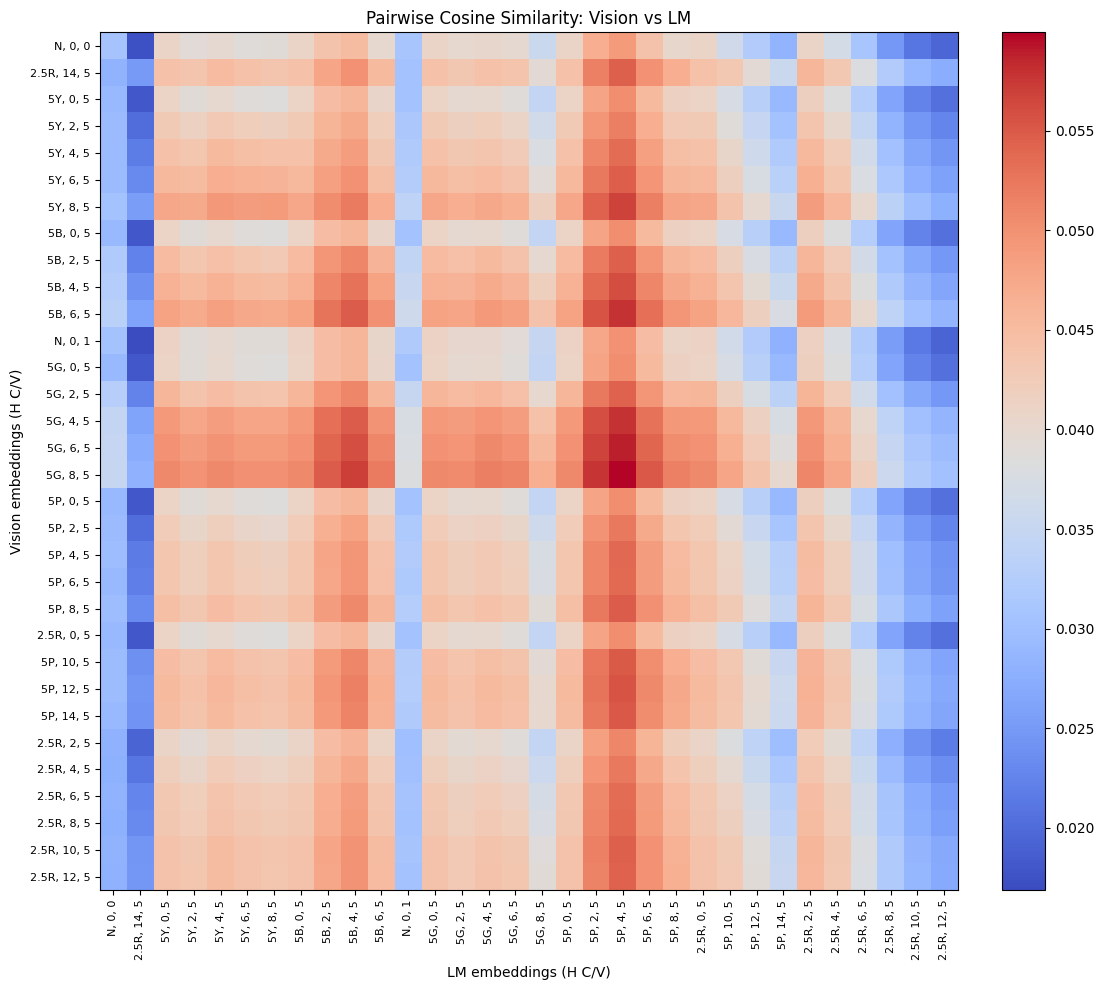

In [234]:
# -----------------------------
# Попарная матрица косинусных сходств Vision × LM с H, C, V на осях
# -----------------------------
def cross_cosine_matrix_hcv(vision_embeddings, lm_embeddings, color_meta):
    """
    vision_embeddings: np.array, shape [N, D]
    lm_embeddings: np.array, shape [N, D]
    color_meta: список словарей с info о цвете (H/C/V)
    """
    N = vision_embeddings.shape[0]

    # Нормализация векторов
    vision_norm = vision_embeddings / np.linalg.norm(vision_embeddings, axis=1, keepdims=True)
    lm_norm = lm_embeddings / np.linalg.norm(lm_embeddings, axis=1, keepdims=True)

    # Попарная матрица косинусного сходства
    cosine_mat = vision_norm @ lm_norm.T  # shape [N, N]

    # Создание подписей по H/C/V
    labels = [f"{meta['H']}, {meta['C']}, {meta['V']}" for meta in color_meta]

    # Визуализация
    plt.figure(figsize=(12, 10))
    im = plt.imshow(cosine_mat, cmap='coolwarm', vmin=cosine_mat.min(), vmax=cosine_mat.max())
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Pairwise Cosine Similarity: Vision vs LM')
    plt.xlabel('LM embeddings (H C/V)')
    plt.ylabel('Vision embeddings (H C/V)')
    plt.xticks(range(N), labels, rotation=90, fontsize=8)
    plt.yticks(range(N), labels, fontsize=8)
    plt.tight_layout()
    plt.show()

    return cosine_mat

cos_mat_hcv = cross_cosine_matrix_hcv(
    vision_embeddings=vision_matrix,
    lm_embeddings=lm_matrix,
    color_meta=color_meta
)


## Analyze embeddings of similar grey color.

In [235]:

# Analysis of Same Colors (C=0, V=5)
# All colors with C=0 and V=5 are the same grey color but with different hues
# We want to analyze the variance and cosine angles of their embeddings

print("=" * 80)
print("SAME COLOR ANALYSIS (C=0, V=5)")
print("=" * 80)

# Identify same color samples (C=0, V=5)
same_color_indices = []
same_color_metadata = []

for i, meta in enumerate(lm_color_meta):
    if meta.get('C') == 0 and meta.get('V') == 5:
        same_color_indices.append(i)
        same_color_metadata.append(meta)
        print(f"Found same color: {meta.get('notation', 'Unknown')} (H={meta.get('H', 'Unknown')})")

print(f"\nTotal same color samples found: {len(same_color_indices)}")

if len(same_color_indices) < 2:
    print("Not enough same color samples for analysis")
else:
    # Extract embeddings for same color samples
    same_color_lm = lm_matrix[same_color_indices]
    same_color_vision = vision_matrix[same_color_indices]
    
    print(same_color_lm[0][1]*1000, same_color_lm[1][1]*1000)
    
    print(f"\nSame color embedding shapes:")
    print(f"  LM embeddings: {same_color_lm.shape}")
    print(f"  Vision embeddings: {same_color_vision.shape}")
    
    # Calculate variance within same color embeddings
    def calculate_embedding_variance(embeddings, embedding_name):
        """Calculate variance statistics for embeddings"""
        print(f"\n=== {embedding_name} Variance Analysis ===")
        
        # Calculate variance across samples (axis=0)
        sample_variance = np.var(same_color_lm, axis=0)
        mean_variance = np.mean(sample_variance)
        std_variance = np.std(sample_variance)
        
        # Calculate pairwise distances between all samples
        pairwise_distances = []
        for i in range(len(same_color_indices)):
            for j in range(i+1, len(same_color_indices)):
                dist = np.linalg.norm(embeddings[i] - embeddings[j])
                pairwise_distances.append(dist)
        
        pairwise_distances = np.array(pairwise_distances)
        
        # Calculate cosine similarities between all samples
        cosine_similarities = []
        for i in range(len(same_color_indices)):
            for j in range(i+1, len(same_color_indices)):
                # Normalize vectors
                vec_i = embeddings[i] / np.linalg.norm(embeddings[i])
                vec_j = embeddings[j] / np.linalg.norm(embeddings[j])
                cosine_sim = np.dot(vec_i, vec_j)
                cosine_similarities.append(cosine_sim)
        
        cosine_similarities = np.array(cosine_similarities)
        
        print(f"Variance Statistics:")
        print(f"  Mean variance across dimensions: {mean_variance:.6f}")
        print(f"  Std variance across dimensions: {std_variance:.6f}")
        print(f"  Min variance: {np.min(sample_variance):.6f}")
        print(f"  Max variance: {np.max(sample_variance):.6f}")
        
        print(f"\nPairwise Distance Statistics:")
        print(f"  Mean pairwise distance: {np.mean(pairwise_distances):.6f}")
        print(f"  Std pairwise distance: {np.std(pairwise_distances):.6f}")
        print(f"  Min pairwise distance: {np.min(pairwise_distances):.6f}")
        print(f"  Max pairwise distance: {np.max(pairwise_distances):.6f}")
        
        print(f"\nCosine Similarity Statistics:")
        print(f"  Mean cosine similarity: {np.mean(cosine_similarities):.6f}")
        print(f"  Std cosine similarity: {np.std(cosine_similarities):.6f}")
        print(f"  Min cosine similarity: {np.min(cosine_similarities):.6f}")
        print(f"  Max cosine similarity: {np.max(cosine_similarities):.6f}")
        
        # Calculate angles in degrees
        angles_degrees = np.arccos(np.clip(cosine_similarities, -1, 1)) * 180 / np.pi
        print(f"\nAngle Statistics (degrees):")
        print(f"  Mean angle: {np.mean(angles_degrees):.2f}°")
        print(f"  Std angle: {np.std(angles_degrees):.2f}°")
        print(f"  Min angle: {np.min(angles_degrees):.2f}°")
        print(f"  Max angle: {np.max(angles_degrees):.2f}°")
        
        return {
            'sample_variance': sample_variance,
            'mean_variance': mean_variance,
            'pairwise_distances': pairwise_distances,
            'cosine_similarities': cosine_similarities,
            'angles_degrees': angles_degrees
        }
    
    # Analyze LM embeddings
    lm_variance_stats = calculate_embedding_variance(same_color_lm, "LM Pooled Mean")
    
    # Analyze Vision embeddings  
    vision_variance_stats = calculate_embedding_variance(same_color_vision, "Vision Pooled Mean")


SAME COLOR ANALYSIS (C=0, V=5)
Found same color: 5Y 5/0 (H=5Y)
Found same color: 5B 5/0 (H=5B)
Found same color: 5G 5/0 (H=5G)
Found same color: 5P 5/0 (H=5P)
Found same color: 2.5R 5/0 (H=2.5R)

Total same color samples found: 5
7187.5 7187.5

Same color embedding shapes:
  LM embeddings: (5, 3584)
  Vision embeddings: (5, 3584)

=== LM Pooled Mean Variance Analysis ===
Variance Statistics:
  Mean variance across dimensions: 0.000000
  Std variance across dimensions: 0.000000
  Min variance: 0.000000
  Max variance: 0.000000

Pairwise Distance Statistics:
  Mean pairwise distance: 0.000000
  Std pairwise distance: 0.000000
  Min pairwise distance: 0.000000
  Max pairwise distance: 0.000000

Cosine Similarity Statistics:
  Mean cosine similarity: 1.000000
  Std cosine similarity: 0.000000
  Min cosine similarity: 1.000000
  Max cosine similarity: 1.000000

Angle Statistics (degrees):
  Mean angle: 0.00°
  Std angle: 0.00°
  Min angle: 0.00°
  Max angle: 0.00°

=== Vision Pooled Mean Va

# Проверка возможности калибровки цветового простраснтво модели до человечекого перцептивного пространства с помощью линейноого преобразвоания

In [236]:
color_meta
colors_xyY = np.array([
    [item['xyY']['x'], item['xyY']['y'], item['xyY']['Y']]
    for item in color_meta
], dtype=float)

print(colors_xyY.shape)
print(colors_xyY[:5])

(32, 3)
[[ 0.31006     0.31616     0.        ]
 [ 0.5047      0.295       0.19271844]
 [ 0.31006     0.31616     0.19271844]
 [ 0.35        0.362       0.19271844]
 [ 0.3915      0.4057      0.19271844]]


LM layer: Converted to CAM16-LCD shape: (32, 3)
LM layer: R² = 0.9839, RMSE = 1.7027
LM layer:
  Pearson(dist_true, dist_pred) = 0.9968 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9965 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.8072 (p = 3.48e-115)
  Spearman(dist_emb, dist_true)  = 0.8605 (p = 9.01e-147)
  Pearson(dist_emb, dist_pred)   = 0.8155 (p = 2.17e-119)


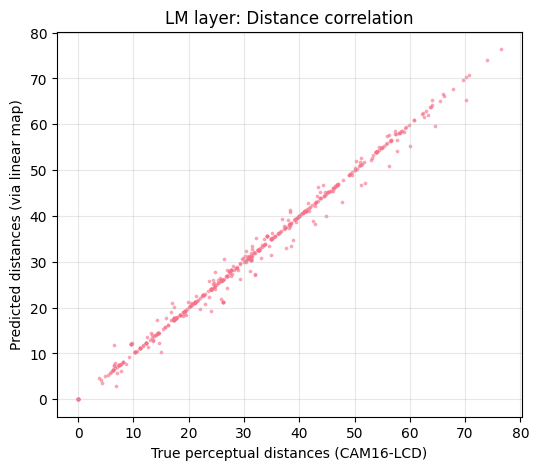

LM layer: Matrix W shape = (3, 3584), Bias b shape = (3,)
Vision layer: Converted to CAM16-LCD shape: (32, 3)
Vision layer: R² = 0.9832, RMSE = 1.7425
Vision layer:
  Pearson(dist_true, dist_pred) = 0.9902 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9897 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.7915 (p = 1.09e-107)
  Spearman(dist_emb, dist_true)  = 0.8077 (p = 2.00e-115)
  Pearson(dist_emb, dist_pred)   = 0.7935 (p = 1.32e-108)


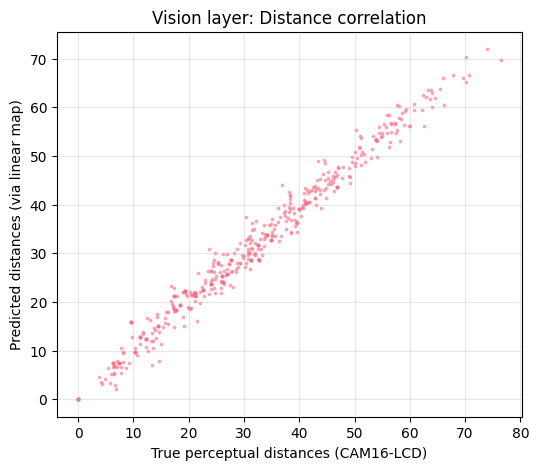

Vision layer: Matrix W shape = (3, 3584), Bias b shape = (3,)
Correlation between LM and Vision predicted colors:
  Pearson = 0.9991
  Spearman = 0.9934


In [237]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, pairwise_distances
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ
from colour.models import XYZ_to_CAM16LCD

def linear_color_mapping(embeddings, colors_xyY, layer_name="LM"):
    # Преобразуем xyY → CAM16-LCD (векторизованно)
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    print(f"{layer_name} layer: Converted to CAM16-LCD shape: {colors_cam.shape}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, colors_cam, test_size=0.2, random_state=42
    )

    # Линейное отображение
    reg = Ridge(alpha=1.0)
    reg.fit(X_train, y_train)
    y_pred_test = reg.predict(X_test)
    y_pred_all = reg.predict(embeddings)

    # Оценка точности
    r2 = r2_score(y_test, y_pred_test, multioutput='variance_weighted')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"{layer_name} layer: R² = {r2:.4f}, RMSE = {rmse:.4f}")

    # Глобальный анализ через pairwise distances
    D_emb = pairwise_distances(embeddings, metric='cosine')
    D_true = pairwise_distances(colors_cam, metric='euclidean')
    D_pred = pairwise_distances(y_pred_all, metric='euclidean')

    n = embeddings.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    v_emb = D_emb[triu_idx]
    v_true = D_true[triu_idx]
    v_pred = D_pred[triu_idx]

    # pearson_true_pred = pearsonr(v_true, v_pred)[0]
    # spearman_true_pred = spearmanr(v_true, v_pred).correlation
    # pearson_emb_true = pearsonr(v_emb, v_true)[0]
    # spearman_emb_true = spearmanr(v_emb, v_true)[0]
    # pearson_emb_pred = pearsonr(v_emb, v_pred)[0]


    # print(f"{layer_name} layer:")
    # print(f"  Pearson(dist_true, dist_pred) = {pearson_true_pred:.4f}")
    # print(f"  Spearman(dist_true, dist_pred) = {spearman_true_pred:.4f}")
    # print(f"  Pearson(dist_emb, dist_true)   = {pearson_emb_true:.4f}")
    # print(f"  Spearman(dist_emb, dist_true)   = {spearman_emb_true:.4f}")
    # print(f"  Pearson(dist_emb, dist_pred)   = {pearson_emb_pred:.4f}")

    # ...
    pearson_r, pearson_p = pearsonr(v_true, v_pred)
    spearman_res = spearmanr(v_true, v_pred)
    spearman_r = getattr(spearman_res, 'correlation', spearman_res.statistic)
    spearman_p = spearman_res.pvalue

    emb_true_pr, emb_true_pp = pearsonr(v_emb, v_true)
    emb_true_sr = spearmanr(v_emb, v_true)
    emb_true_sr_r = getattr(emb_true_sr, 'correlation', emb_true_sr.statistic)
    emb_true_sr_p = emb_true_sr.pvalue

    emb_pred_pr, emb_pred_pp = pearsonr(v_emb, v_pred)

    print(f"{layer_name} layer:")
    print(f"  Pearson(dist_true, dist_pred) = {pearson_r:.4f} (p = {pearson_p:.2e})")
    print(f"  Spearman(dist_true, dist_pred) = {spearman_r:.4f} (p = {spearman_p:.2e})")
    print(f"  Pearson(dist_emb, dist_true)   = {emb_true_pr:.4f} (p = {emb_true_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_true)  = {emb_true_sr_r:.4f} (p = {emb_true_sr_p:.2e})")
    print(f"  Pearson(dist_emb, dist_pred)   = {emb_pred_pr:.4f} (p = {emb_pred_pp:.2e})")


    # Визуализация согласованности расстояний
    plt.figure(figsize=(6,5))
    plt.scatter(v_true, v_pred, s=3, alpha=0.5)
    plt.xlabel('True perceptual distances (CAM16-LCD)')
    plt.ylabel('Predicted distances (via linear map)')
    plt.title(f'{layer_name} layer: Distance correlation')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Матрица линейного преобразования и bias
    W = reg.coef_
    b = reg.intercept_
    print(f"{layer_name} layer: Matrix W shape = {W.shape}, Bias b shape = {b.shape}")

    return y_pred_all, W, b

# === LM layer ===
y_pred_lm, W_lm, b_lm = linear_color_mapping(lm_matrix, colors_xyY, layer_name="LM")

# === Vision layer ===
y_pred_vl, W_vl, b_vl = linear_color_mapping(vision_matrix, colors_xyY, layer_name="Vision")

# === Корреляция между предсказанными цветами двух слоёв ===
pearson_between_layers = pearsonr(
    y_pred_lm.flatten(), y_pred_vl.flatten()
)[0]
spearman_between_layers = spearmanr(
    y_pred_lm.flatten(), y_pred_vl.flatten()
).correlation

print(f"Correlation between LM and Vision predicted colors:")
print(f"  Pearson = {pearson_between_layers:.4f}")
print(f"  Spearman = {spearman_between_layers:.4f}")


# Аналгично для подвектора эмбедддингов (составляющее основную долю дисперсии)

In [238]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr, spearmanr

emb = lm_matrix
colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
M = emb.shape[0]

D_true_mat = pairwise_distances(colors_cam, metric='euclidean')   # (M, M)
D_emb_cos_mat = pairwise_distances(emb, metric='cosine')          # если нужно (M, M)

# верхний треугольник -> вектор
i_triu, j_triu = np.triu_indices(M, k=1)
dist_true = D_true_mat[i_triu, j_triu]   # (M_pairs,)

# 2. Нормализация эмбеддингов и PCA по всем компонентам
scaler = StandardScaler()
emb_norm = scaler.fit_transform(emb)  # (M, D)

pca = PCA()
emb_pca = pca.fit_transform(emb_norm)  # (M, D)

explained_var = np.cumsum(pca.explained_variance_ratio_)
print("Explained variance cumulative (first 20):")
for idx, v in enumerate(explained_var[:20], start=1):
    print(f"{idx:2d} dims -> {v:.4f}")

def build_pairwise_features(X):
    """
    X: (M, k) - точки
    Returns: X_pairs (M_pairs, k) where each row = |X[i] - X[j]| for i<j
    """
    M = X.shape[0]
    i, j = np.triu_indices(M, k=1)
    X_pairs = np.abs(X[i] - X[j])  # (M_pairs, k)
    return X_pairs


def eval_pca_distance_method(k):
    """
    Метод A: вычислить попарные евклидовы расстояния в PCA-k пространстве,
              затем коррелировать с dist_true.
    """
    Xk = emb_pca[:, :k]
    D_pred_mat = pairwise_distances(Xk, metric='euclidean')
    dist_pred = D_pred_mat[i_triu, j_triu]
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred

def eval_pca_regression(k):
    """
    Метод B: создать по-парам признаки |pca_i - pca_j| и линейную регрессию
              dist_true ~ w * |pca_i - pca_j| + b
    """
    Xk = emb_pca[:, :k]
    X_pairs = build_pairwise_features(Xk)   # (M_pairs, k)
    reg = LinearRegression().fit(X_pairs, dist_true)
    dist_pred = reg.predict(X_pairs)
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred, reg


k_list = [8, 13, 18]
results = {}

print("\nPCA (euclidean distances in PCA-k) performance (method A):")
for k in k_list:
    pear_a, spear_a, _ = eval_pca_distance_method(k)
    print(f"k={k:2d}  -> Pearson={pear_a:.4f}, Spearman={spear_a:.4f}")

print("\nPCA + linear regression on pairwise features (method B):")
for k in k_list:
    pear_b, spear_b, _, _ = eval_pca_regression(k)
    results[k] = (pear_b, spear_b)
    print(f"k={k:2d}  -> Pearson={pear_b:.4f}, Spearman={spear_b:.4f}")



best_k = max(results, key=lambda kk: results[kk][0])
print(f"\nBest k by Pearson (method B): {best_k} -> Pearson={results[best_k][0]:.4f}, Spearman={results[best_k][1]:.4f}")



Explained variance cumulative (first 20):
 1 dims -> 0.3494
 2 dims -> 0.5334
 3 dims -> 0.7124
 4 dims -> 0.8311
 5 dims -> 0.9053
 6 dims -> 0.9341
 7 dims -> 0.9605
 8 dims -> 0.9710
 9 dims -> 0.9794
10 dims -> 0.9860
11 dims -> 0.9909
12 dims -> 0.9930
13 dims -> 0.9950
14 dims -> 0.9964
15 dims -> 0.9974
16 dims -> 0.9983
17 dims -> 0.9987
18 dims -> 0.9991
19 dims -> 0.9993
20 dims -> 0.9995

PCA (euclidean distances in PCA-k) performance (method A):
k= 8  -> Pearson=0.8499, Spearman=0.8603
k=13  -> Pearson=0.8497, Spearman=0.8622
k=18  -> Pearson=0.8496, Spearman=0.8620

PCA + linear regression on pairwise features (method B):
k= 8  -> Pearson=0.8590, Spearman=0.8547
k=13  -> Pearson=0.8638, Spearman=0.8634
k=18  -> Pearson=0.8693, Spearman=0.8671

Best k by Pearson (method B): 18 -> Pearson=0.8693, Spearman=0.8671


In [239]:
emb = vision_matrix
colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
M = emb.shape[0]

D_true_mat = pairwise_distances(colors_cam, metric='euclidean')   # (M, M)
D_emb_cos_mat = pairwise_distances(emb, metric='cosine')          # если нужно (M, M)

# верхний треугольник -> вектор
i_triu, j_triu = np.triu_indices(M, k=1)
dist_true = D_true_mat[i_triu, j_triu]   # (M_pairs,)

# 2. Нормализация эмбеддингов и PCA по всем компонентам
scaler = StandardScaler()
emb_norm = scaler.fit_transform(emb)  # (M, D)

pca = PCA()
emb_pca = pca.fit_transform(emb_norm)  # (M, D)

explained_var = np.cumsum(pca.explained_variance_ratio_)
print("Explained variance cumulative (first 20):")
for idx, v in enumerate(explained_var[:20], start=1):
    print(f"{idx:2d} dims -> {v:.4f}")

def build_pairwise_features(X):
    """
    X: (M, k) - точки
    Returns: X_pairs (M_pairs, k) where each row = |X[i] - X[j]| for i<j
    """
    M = X.shape[0]
    i, j = np.triu_indices(M, k=1)
    X_pairs = np.abs(X[i] - X[j])  # (M_pairs, k)
    return X_pairs


def eval_pca_distance_method(k):
    """
    Метод A: вычислить попарные евклидовы расстояния в PCA-k пространстве,
              затем коррелировать с dist_true.
    """
    Xk = emb_pca[:, :k]
    D_pred_mat = pairwise_distances(Xk, metric='euclidean')
    dist_pred = D_pred_mat[i_triu, j_triu]
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred

def eval_pca_regression(k):
    """
    Метод B: создать по-парам признаки |pca_i - pca_j| и линейную регрессию
              dist_true ~ w * |pca_i - pca_j| + b
    """
    Xk = emb_pca[:, :k]
    X_pairs = build_pairwise_features(Xk)   # (M_pairs, k)
    reg = LinearRegression().fit(X_pairs, dist_true)
    dist_pred = reg.predict(X_pairs)
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred, reg


k_list = [8, 13, 18]
results = {}

print("\nPCA (euclidean distances in PCA-k) performance (method A):")
for k in k_list:
    pear_a, spear_a, _ = eval_pca_distance_method(k)
    print(f"k={k:2d}  -> Pearson={pear_a:.4f}, Spearman={spear_a:.4f}")

print("\nPCA + linear regression on pairwise features (method B):")
for k in k_list:
    pear_b, spear_b, _, _ = eval_pca_regression(k)
    results[k] = (pear_b, spear_b)
    print(f"k={k:2d}  -> Pearson={pear_b:.4f}, Spearman={spear_b:.4f}")



best_k = max(results, key=lambda kk: results[kk][0])
print(f"\nBest k by Pearson (method B): {best_k} -> Pearson={results[best_k][0]:.4f}, Spearman={results[best_k][1]:.4f}")



Explained variance cumulative (first 20):
 1 dims -> 0.3727
 2 dims -> 0.6007
 3 dims -> 0.7541
 4 dims -> 0.8516
 5 dims -> 0.9129
 6 dims -> 0.9470
 7 dims -> 0.9680
 8 dims -> 0.9781
 9 dims -> 0.9862
10 dims -> 0.9908
11 dims -> 0.9941
12 dims -> 0.9955
13 dims -> 0.9964
14 dims -> 0.9971
15 dims -> 0.9977
16 dims -> 0.9982
17 dims -> 0.9985
18 dims -> 0.9988
19 dims -> 0.9990
20 dims -> 0.9992

PCA (euclidean distances in PCA-k) performance (method A):
k= 8  -> Pearson=0.7574, Spearman=0.7642
k=13  -> Pearson=0.7551, Spearman=0.7620
k=18  -> Pearson=0.7549, Spearman=0.7620

PCA + linear regression on pairwise features (method B):
k= 8  -> Pearson=0.7971, Spearman=0.7947
k=13  -> Pearson=0.7998, Spearman=0.7997
k=18  -> Pearson=0.8077, Spearman=0.8097

Best k by Pearson (method B): 18 -> Pearson=0.8077, Spearman=0.8097


Explained variance cumulative (first 20):
 1 dims -> 0.3494
 2 dims -> 0.5334
 3 dims -> 0.7124
 4 dims -> 0.8311
 5 dims -> 0.9053
 6 dims -> 0.9341
 7 dims -> 0.9605
 8 dims -> 0.9710
 9 dims -> 0.9794
10 dims -> 0.9860
11 dims -> 0.9909
12 dims -> 0.9930
13 dims -> 0.9950
14 dims -> 0.9964
15 dims -> 0.9974
16 dims -> 0.9983
17 dims -> 0.9987
18 dims -> 0.9991
19 dims -> 0.9993
20 dims -> 0.9995

PCA (euclidean distances in PCA-k) performance (method A):
k= 9  -> Pearson=0.8487, Spearman=0.8602
k=14  -> Pearson=0.8496, Spearman=0.8620
k=33  -> Pearson=0.8498, Spearman=0.8620

PCA + linear regression on pairwise features (method B):
k= 9  -> Pearson=0.8603, Spearman=0.8571
k=14  -> Pearson=0.8643, Spearman=0.8647
k=33  -> Pearson=0.8883, Spearman=0.8925

Best k by Pearson (method B): 33 -> Pearson=0.8883, Spearman=0.8925


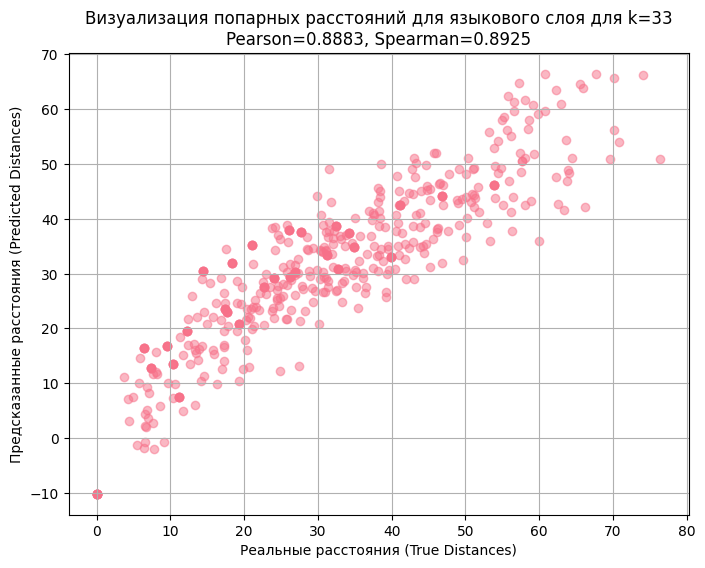

In [240]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

emb = lm_matrix
colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
M = emb.shape[0]

D_true_mat = pairwise_distances(colors_cam, metric='euclidean')   # (M, M)
D_emb_cos_mat = pairwise_distances(emb, metric='cosine')          # если нужно (M, M)

# верхний треугольник -> вектор
i_triu, j_triu = np.triu_indices(M, k=1)
dist_true = D_true_mat[i_triu, j_triu]   # (M_pairs,)

# 2. Нормализация эмбеддингов и PCA по всем компонентам
scaler = StandardScaler()
emb_norm = scaler.fit_transform(emb)  # (M, D)

pca = PCA()
emb_pca = pca.fit_transform(emb_norm)  # (M, D)

explained_var = np.cumsum(pca.explained_variance_ratio_)
print("Explained variance cumulative (first 20):")
for idx, v in enumerate(explained_var[:20], start=1):
    print(f"{idx:2d} dims -> {v:.4f}")

def build_pairwise_features(X):
    """
    X: (M, k) - точки
    Returns: X_pairs (M_pairs, k) where each row = |X[i] - X[j]| for i<j
    """
    M = X.shape[0]
    i, j = np.triu_indices(M, k=1)
    X_pairs = np.abs(X[i] - X[j])  # (M_pairs, k)
    return X_pairs


def eval_pca_distance_method(k):
    """
    Метод A: вычислить попарные евклидовы расстояния в PCA-k пространстве,
              затем коррелировать с dist_true.
    """
    Xk = emb_pca[:, :k]
    D_pred_mat = pairwise_distances(Xk, metric='euclidean')
    dist_pred = D_pred_mat[i_triu, j_triu]
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred

def eval_pca_regression(k):
    """
    Метод B: создать по-парам признаки |pca_i - pca_j| и линейную регрессию
              dist_true ~ w * |pca_i - pca_j| + b
    """
    Xk = emb_pca[:, :k]
    X_pairs = build_pairwise_features(Xk)   # (M_pairs, k)
    reg = LinearRegression().fit(X_pairs, dist_true)
    dist_pred = reg.predict(X_pairs)
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred, reg


k_list = [9, 14, 33]
results = {}

print("\nPCA (euclidean distances in PCA-k) performance (method A):")
for k in k_list:
    pear_a, spear_a, _ = eval_pca_distance_method(k)
    print(f"k={k:2d}  -> Pearson={pear_a:.4f}, Spearman={spear_a:.4f}")

print("\nPCA + linear regression on pairwise features (method B):")
for k in k_list:
    pear_b, spear_b, _, _ = eval_pca_regression(k)
    results[k] = (pear_b, spear_b)
    print(f"k={k:2d}  -> Pearson={pear_b:.4f}, Spearman={spear_b:.4f}")



best_k = max(results, key=lambda kk: results[kk][0])
print(f"\nBest k by Pearson (method B): {best_k} -> Pearson={results[best_k][0]:.4f}, Spearman={results[best_k][1]:.4f}")

# Визуализация для лучшего k (метод B)
pear_b, spear_b, dist_pred, reg = eval_pca_regression(best_k)

plt.figure(figsize=(8, 6))
plt.scatter(dist_true, dist_pred, alpha=0.5)
plt.xlabel('Реальные расстояния (True Distances)')
plt.ylabel('Предсказанные расстояния (Predicted Distances)')
plt.title(f'Визуализация попарных расстояний для языкового слоя для k={best_k}\nPearson={pear_b:.4f}, Spearman={spear_b:.4f}')
plt.grid(True)
plt.show()

Explained variance cumulative (first 20):
 1 dims -> 0.3727
 2 dims -> 0.6007
 3 dims -> 0.7541
 4 dims -> 0.8516
 5 dims -> 0.9129
 6 dims -> 0.9470
 7 dims -> 0.9680
 8 dims -> 0.9781
 9 dims -> 0.9862
10 dims -> 0.9908
11 dims -> 0.9941
12 dims -> 0.9955
13 dims -> 0.9964
14 dims -> 0.9971
15 dims -> 0.9977
16 dims -> 0.9982
17 dims -> 0.9985
18 dims -> 0.9988
19 dims -> 0.9990
20 dims -> 0.9992

PCA (euclidean distances in PCA-k) performance (method A):
k= 6  -> Pearson=0.7435, Spearman=0.7478
k= 9  -> Pearson=0.7562, Spearman=0.7628
k=19  -> Pearson=0.7549, Spearman=0.7621

PCA + linear regression on pairwise features (method B):
k= 6  -> Pearson=0.7696, Spearman=0.7626
k= 9  -> Pearson=0.7971, Spearman=0.7940
k=19  -> Pearson=0.8093, Spearman=0.8106

Best k by Pearson (method B): 19 -> Pearson=0.8093, Spearman=0.8106


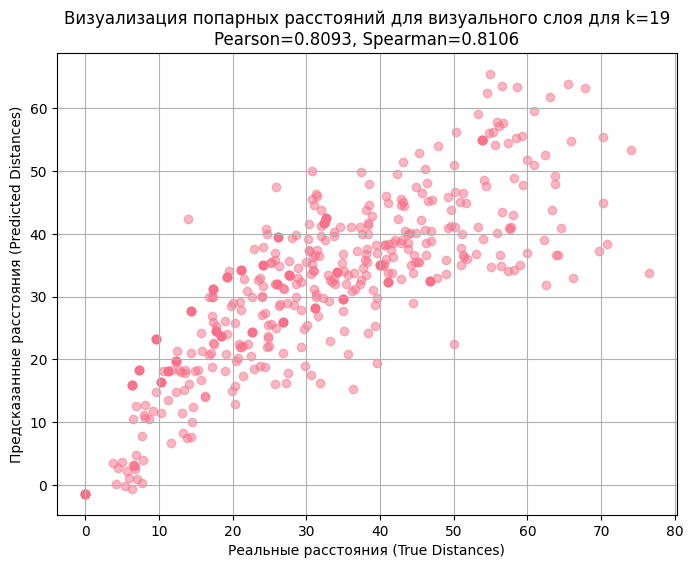

In [241]:
emb = vision_matrix
colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
M = emb.shape[0]

D_true_mat = pairwise_distances(colors_cam, metric='euclidean')   # (M, M)
D_emb_cos_mat = pairwise_distances(emb, metric='cosine')          # если нужно (M, M)

# верхний треугольник -> вектор
i_triu, j_triu = np.triu_indices(M, k=1)
dist_true = D_true_mat[i_triu, j_triu]   # (M_pairs,)

# 2. Нормализация эмбеддингов и PCA по всем компонентам
scaler = StandardScaler()
emb_norm = scaler.fit_transform(emb)  # (M, D)

pca = PCA()
emb_pca = pca.fit_transform(emb_norm)  # (M, D)

explained_var = np.cumsum(pca.explained_variance_ratio_)
print("Explained variance cumulative (first 20):")
for idx, v in enumerate(explained_var[:20], start=1):
    print(f"{idx:2d} dims -> {v:.4f}")

def build_pairwise_features(X):
    """
    X: (M, k) - точки
    Returns: X_pairs (M_pairs, k) where each row = |X[i] - X[j]| for i<j
    """
    M = X.shape[0]
    i, j = np.triu_indices(M, k=1)
    X_pairs = np.abs(X[i] - X[j])  # (M_pairs, k)
    return X_pairs


def eval_pca_distance_method(k):
    """
    Метод A: вычислить попарные евклидовы расстояния в PCA-k пространстве,
              затем коррелировать с dist_true.
    """
    Xk = emb_pca[:, :k]
    D_pred_mat = pairwise_distances(Xk, metric='euclidean')
    dist_pred = D_pred_mat[i_triu, j_triu]
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred

def eval_pca_regression(k):
    """
    Метод B: создать по-парам признаки |pca_i - pca_j| и линейную регрессию
              dist_true ~ w * |pca_i - pca_j| + b
    """
    Xk = emb_pca[:, :k]
    X_pairs = build_pairwise_features(Xk)   # (M_pairs, k)
    reg = LinearRegression().fit(X_pairs, dist_true)
    dist_pred = reg.predict(X_pairs)
    pear = pearsonr(dist_true, dist_pred)[0]
    spear = spearmanr(dist_true, dist_pred)[0]
    return pear, spear, dist_pred, reg


k_list = [6, 9, 19]
results = {}

print("\nPCA (euclidean distances in PCA-k) performance (method A):")
for k in k_list:
    pear_a, spear_a, _ = eval_pca_distance_method(k)
    print(f"k={k:2d}  -> Pearson={pear_a:.4f}, Spearman={spear_a:.4f}")

print("\nPCA + linear regression on pairwise features (method B):")
for k in k_list:
    pear_b, spear_b, _, _ = eval_pca_regression(k)
    results[k] = (pear_b, spear_b)
    print(f"k={k:2d}  -> Pearson={pear_b:.4f}, Spearman={spear_b:.4f}")



best_k = max(results, key=lambda kk: results[kk][0])
print(f"\nBest k by Pearson (method B): {best_k} -> Pearson={results[best_k][0]:.4f}, Spearman={results[best_k][1]:.4f}")

# Визуализация для лучшего k (метод B)
pear_b, spear_b, dist_pred, reg = eval_pca_regression(best_k)

plt.figure(figsize=(8, 6))
plt.scatter(dist_true, dist_pred, alpha=0.5)
plt.xlabel('Реальные расстояния (True Distances)')
plt.ylabel('Предсказанные расстояния (Predicted Distances)')
plt.title(f'Визуализация попарных расстояний для визуального слоя для k={best_k}\nPearson={pear_b:.4f}, Spearman={spear_b:.4f}')
plt.grid(True)
plt.show()

# Аналогичные эксперименты на всех данных

In [242]:
from utils.analyze.munsell_analyze import MunsellEmbeddingsAnalyzer
import pandas as  pd
import numpy as np

In [243]:
analyzer = MunsellEmbeddingsAnalyzer('data/embeddings/qwen2.5_7B/munsell_colors_describe', 'data/colors/munsell_colors/munsell_manifest.csv')
data = analyzer.chain_loader.get_all_available_embeddings()
lm_matrix_all = data['lm_pooled']
vision_matrix_all = data['vl_pooled']
color_meta_all = data['metadata']
lm_matrix_all.shape, vision_matrix_all.shape

((1755, 3584), (1755, 3584))

In [244]:
color_meta_all["1"]

{'embedding_index': '1',
 'xyY': {'x': 0.31, 'y': 0.316, 'Y': 1.21},
 'RGB': {'R': 0.116215867179, 'G': 0.110852802516, 'B': 0.11955448237},
 'image_path': 'data/munsell_colors/pics/1.png',
 'answer': 'system\nYou are a helpful assistant.\nuser\nDescribe the color.\n addCriterion\nThe image you provided is completely black, with no discernible colors or variations in shade. It appears to be a solid black rectangle.',
 'prompt': 'Describe the color.'}

In [245]:
keys = sorted(color_meta_all.keys(), key=lambda k: int(k))

colors_xyY_all = np.array([
    [color_meta_all[k]['xyY']['x'],
    color_meta_all[k]['xyY']['y'],
    color_meta_all[k]['xyY']['Y']]
    for k in keys
    ], dtype=float)

print(colors_xyY_all.shape) 

(1755, 3)


LM layer: Converted to CAM16-LCD shape: (1755, 3)
LM layer: R² = 0.9996, RMSE = 0.9017
LM layer:
  Pearson(dist_true, dist_pred) = 0.9998 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9998 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5157 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.5596 (p = 0.00e+00)
  Pearson(dist_emb, dist_pred)   = 0.5159 (p = 0.00e+00)


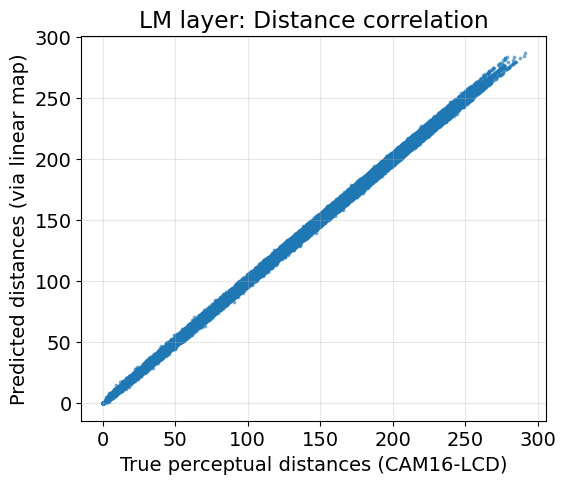

LM layer: Matrix W shape = (3, 3584), Bias b shape = (3,)
Vision layer: Converted to CAM16-LCD shape: (1755, 3)
Vision layer: R² = 0.9989, RMSE = 1.4439
Vision layer:
  Pearson(dist_true, dist_pred) = 0.9986 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9986 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5288 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.6081 (p = 0.00e+00)
  Pearson(dist_emb, dist_pred)   = 0.5277 (p = 0.00e+00)


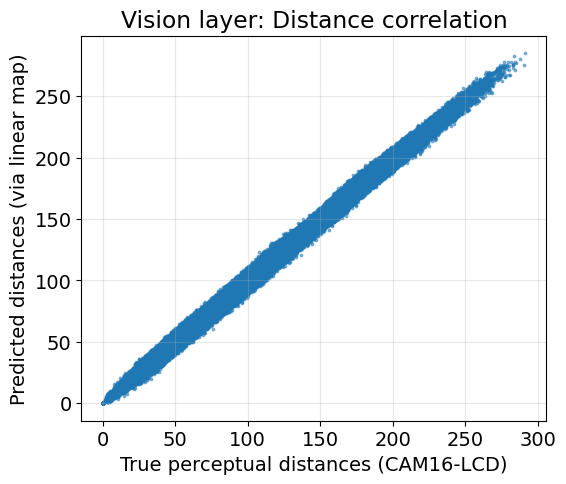

Vision layer: Matrix W shape = (3, 3584), Bias b shape = (3,)
Correlation between LM and Vision predicted colors:
  Pearson = 0.9999
  Spearman = 0.9998


In [246]:
# === LM layer ===
y_pred_lm, W_lm, b_lm = linear_color_mapping(lm_matrix_all, colors_xyY_all, layer_name="LM")

# === Vision layer ===
y_pred_vl, W_vl, b_vl = linear_color_mapping(vision_matrix_all, colors_xyY_all, layer_name="Vision")

# === Корреляция между предсказанными цветами двух слоёв ===
pearson_between_layers = pearsonr(
    y_pred_lm.flatten(), y_pred_vl.flatten()
)[0]
spearman_between_layers = spearmanr(
    y_pred_lm.flatten(), y_pred_vl.flatten()
).correlation

print(f"Correlation between LM and Vision predicted colors:")
print(f"  Pearson = {pearson_between_layers:.4f}")
print(f"  Spearman = {spearman_between_layers:.4f}")

Starting color space calibration analysis...

LM layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9995 ± 0.0000
  Lasso: CV R² = 0.9966 ± 0.0004
  ElasticNet: CV R² = 0.9974 ± 0.0002
  Best model: Ridge

LM layer performance:
  Overall R² = 0.9996, RMSE = 0.9017, MAE = 0.6663
  R² per dimension: L=1.000, a=0.999, b=1.000

LM layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9998 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9998 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5157 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.5596 (p = 0.00e+00)
  Pearson(dist_emb, dist_pred)   = 0.5159 (p = 0.00e+00)
  Spearman(dist_emb, dist_pred)  = 0.5597 (p = 0.00e+00)
  k-NN preservation (k=5): 0.859
  k-NN preservation (k=10): 0.896
  k-NN preservation (k=20): 0.915
  Isotropy score: 0.994


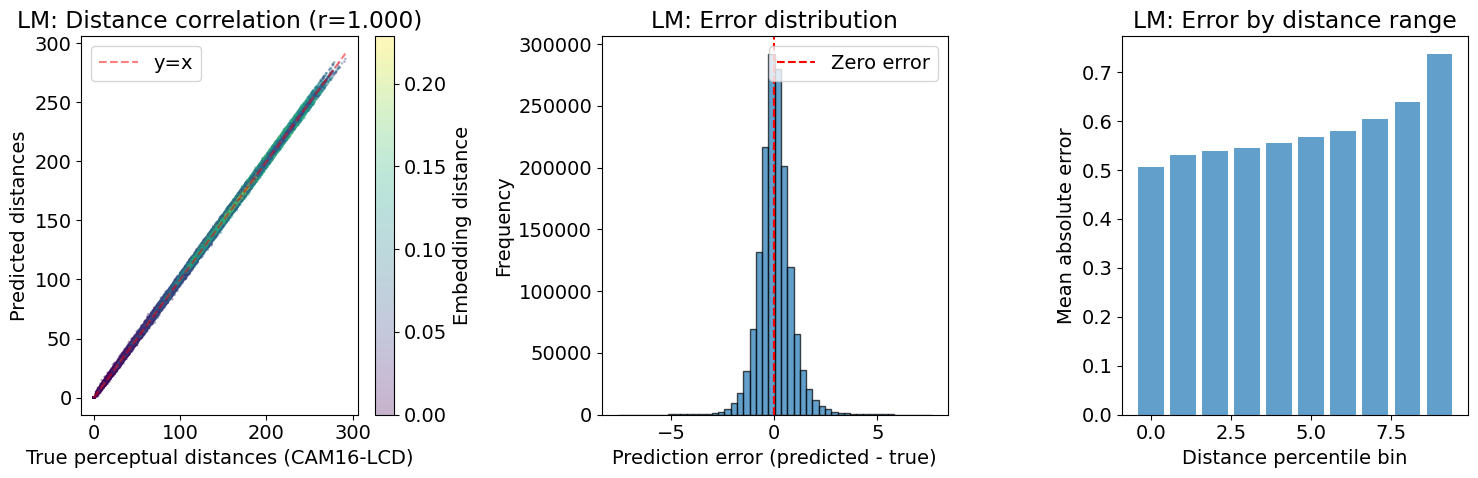

Size of singular values: (3,)

LM layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 1.97
  Top 3 singular values: [ 19.669308  13.477225  10.001116]

Vision layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9985 ± 0.0002
  Lasso: CV R² = 0.9800 ± 0.0017
  ElasticNet: CV R² = 0.9717 ± 0.0021
  Best model: Ridge

Vision layer performance:
  Overall R² = 0.9989, RMSE = 1.4439, MAE = 1.0518
  R² per dimension: L=0.999, a=0.999, b=0.999

Vision layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9986 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9986 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5288 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.6081 (p = 0.00e+00)
  Pearson(dist_emb, dist_pred)   = 0.5277 (p = 0.00e+00)
  Spearman(dist_emb, dist_pred)  = 0.6080 (p = 0.00e+00)
  k-NN preservation (k=5): 0.744
  k-NN preservation (k=10): 0.803
  k-NN preservation (k=20): 0.8

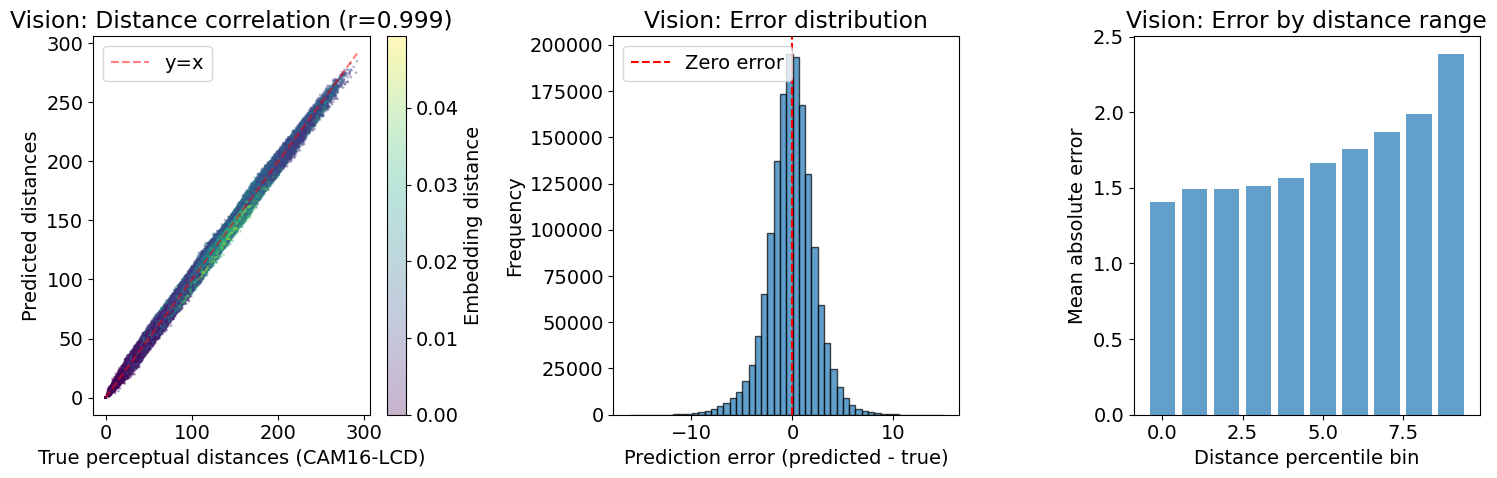

Size of singular values: (3,)

Vision layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 2.36
  Top 3 singular values: [ 91.111755  58.29886   38.640556]

Cross-layer comparison:
  Correlation between LM and Vision predictions:
    Pearson = 0.9999
    Spearman = 0.9998
  Distance preservation between layers: 0.9987


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ
from colour.models import XYZ_to_CAM16LCD
import seaborn as sns

def linear_color_mapping(embeddings, colors_xyY, layer_name="LM", alpha=1.0):
    # Преобразуем xyY → CAM16-LCD (векторизованно)
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    print(f"\n{'='*60}")
    print(f"{layer_name} layer: Converted to CAM16-LCD shape: {colors_cam.shape}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, colors_cam, test_size=0.2, random_state=42
    )

    print(f"\nTrain size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

    # Сравнение разных моделей регрессии
    models = {
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha/10, max_iter=2000),
        'ElasticNet': ElasticNet(alpha=alpha/10, l1_ratio=0.5, max_iter=2000)
    }
    
    best_model = None
    best_score = -np.inf
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                   scoring='r2', n_jobs=-1)
        mean_cv_score = np.mean(cv_scores)
        print(f"  {name}: CV R² = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_model = model
            best_model_name = name
    
    # Обучаем лучшую модель
    reg = best_model
    reg.fit(X_train, y_train)
    print(f"  Best model: {best_model_name}")
    
    y_pred_test = reg.predict(X_test)
    y_pred_all = reg.predict(embeddings)

    # Расширенная оценка точности
    r2 = r2_score(y_test, y_pred_test, multioutput='variance_weighted')
    r2_per_dim = r2_score(y_test, y_pred_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"\n{layer_name} layer performance:")
    print(f"  Overall R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    print(f"  R² per dimension: L={r2_per_dim[0]:.3f}, a={r2_per_dim[1]:.3f}, b={r2_per_dim[2]:.3f}")

    # Вычисляем попарные расстояния (используем pdist для эффективности)
    # pdist возвращает только верхний треугольник матрицы расстояний
    v_emb = pdist(embeddings, metric='cosine')
    v_true = pdist(colors_cam, metric='euclidean')
    v_pred = pdist(y_pred_test, metric='euclidean')
    
    # Дополнительные метрики расстояний
    # v_true_deltaE = pdist(colors_cam, metric='euclidean')  # ΔE в CAM16-LCD
    
    # Корреляции между расстояниями
    correlations = {}
    
    # True vs Predicted
    pearson_r, pearson_p = pearsonr(v_true, v_pred)
    spearman_r, spearman_p = spearmanr(v_true, v_pred)
    correlations['true_pred'] = {
        'pearson': (pearson_r, pearson_p),
        'spearman': (spearman_r, spearman_p)
    }
    
    # Embedding vs True
    emb_true_pr, emb_true_pp = pearsonr(v_emb, v_true)
    emb_true_sr, emb_true_sp = spearmanr(v_emb, v_true)
    correlations['emb_true'] = {
        'pearson': (emb_true_pr, emb_true_pp),
        'spearman': (emb_true_sr, emb_true_sp)
    }
    
    # Embedding vs Predicted
    emb_pred_pr, emb_pred_pp = pearsonr(v_emb, v_pred)
    emb_pred_sr, emb_pred_sp = spearmanr(v_emb, v_pred)
    correlations['emb_pred'] = {
        'pearson': (emb_pred_pr, emb_pred_pp),
        'spearman': (emb_pred_sr, emb_pred_sp)
    }
    
    print(f"\n{layer_name} layer distance correlations:")
    print(f"  Pearson(dist_true, dist_pred)  = {pearson_r:.4f} (p = {pearson_p:.2e})")
    print(f"  Spearman(dist_true, dist_pred) = {spearman_r:.4f} (p = {spearman_p:.2e})")
    print(f"  Pearson(dist_emb, dist_true)   = {emb_true_pr:.4f} (p = {emb_true_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_true)  = {emb_true_sr:.4f} (p = {emb_true_sp:.2e})")
    print(f"  Pearson(dist_emb, dist_pred)   = {emb_pred_pr:.4f} (p = {emb_pred_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_pred)  = {emb_pred_sr:.4f} (p = {emb_pred_sp:.2e})")
    
    # Анализ сохранения локальной структуры (k-NN consistency)
    k_neighbors = [5, 10, 20]
    for k in k_neighbors:
        knn_accuracy = compute_knn_preservation(embeddings, colors_cam, y_pred_all, k)
        print(f"  k-NN preservation (k={k}): {knn_accuracy:.3f}")
    
    # Анализ изотропности (проверка искажений в разных направлениях)
    isotropy_score = analyze_isotropy(v_true, v_pred)
    print(f"  Isotropy score: {isotropy_score:.3f}")
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Scatter plot расстояний
    ax1 = axes[0]
    scatter = ax1.scatter(v_true, v_pred, s=1, alpha=0.3, c=v_emb, cmap='viridis')
    ax1.plot([0, max(v_true)], [0, max(v_true)], 'r--', alpha=0.5, label='y=x')
    ax1.set_xlabel('True perceptual distances (CAM16-LCD)')
    ax1.set_ylabel('Predicted distances')
    ax1.set_title(f'{layer_name}: Distance correlation (r={pearson_r:.3f})')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Embedding distance')
    
    # 2. Распределение ошибок
    ax2 = axes[1]
    errors = v_pred - v_true
    ax2.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='Zero error')
    ax2.set_xlabel('Prediction error (predicted - true)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{layer_name}: Error distribution')
    ax2.legend()
    
    # 3. Heatmap ошибок по расстояниям
    ax3 = axes[2]
    # Биннинг для анализа ошибок
    bins = np.percentile(v_true, np.linspace(0, 100, 11))
    bin_indices = np.digitize(v_true, bins) - 1
    mean_errors = [np.mean(np.abs(errors[bin_indices == i])) 
                   for i in range(len(bins)-1)]
    
    ax3.bar(range(len(mean_errors)), mean_errors, alpha=0.7)
    ax3.set_xlabel('Distance percentile bin')
    ax3.set_ylabel('Mean absolute error')
    ax3.set_title(f'{layer_name}: Error by distance range')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ матрицы преобразования
    W = reg.coef_
    b = reg.intercept_
    
    # Singular value decomposition для анализа ранга
    U, s, Vt = np.linalg.svd(W)
    print(f'Size of singular values: {s.shape}')
    effective_rank = np.sum(s > 0.01 * s[0])  # Эффективный ранг
    condition_number = s[0] / s[-1] if s[-1] > 0 else np.inf
    
    print(f"\n{layer_name} layer transformation analysis:")
    print(f"  Matrix W shape: {W.shape}, Bias b shape: {b.shape}")
    print(f"  Effective rank: {effective_rank}/{min(W.shape)}")
    print(f"  Condition number: {condition_number:.2f}")
    print(f"  Top 3 singular values: {s[:3]}")
    
    return {
        'predictions': y_pred_all,
        'model': reg,
        'W': W,
        'b': b,
        'correlations': correlations,
        'metrics': {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'isotropy': isotropy_score
        }
    }

def compute_knn_preservation(embeddings, true_colors, pred_colors, k=10):
    """Проверяет, сохраняются ли k ближайших соседей после преобразования"""
    from sklearn.neighbors import NearestNeighbors
    
    nn_emb = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn_true = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn_pred = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    
    nn_emb.fit(embeddings)
    nn_true.fit(true_colors)
    nn_pred.fit(pred_colors)
    
    preservation_scores = []
    for i in range(len(embeddings)):
        # Находим k ближайших соседей (исключая сам элемент)
        emb_neighbors = set(nn_emb.kneighbors([embeddings[i]], return_distance=False)[0][1:])
        true_neighbors = set(nn_true.kneighbors([true_colors[i]], return_distance=False)[0][1:])
        pred_neighbors = set(nn_pred.kneighbors([pred_colors[i]], return_distance=False)[0][1:])
        
        # Jaccard similarity между true и predicted
        intersection = len(true_neighbors & pred_neighbors)
        union = len(true_neighbors | pred_neighbors)
        preservation_scores.append(intersection / union if union > 0 else 0)
    
    return np.mean(preservation_scores)

def analyze_isotropy(true_distances, pred_distances):
    """Анализирует изотропность преобразования"""
    # Разбиваем расстояния на квантили и проверяем дисперсию ошибок
    n_bins = 10
    bins = np.percentile(true_distances, np.linspace(0, 100, n_bins+1))
    bin_indices = np.digitize(true_distances, bins) - 1
    
    errors_by_bin = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            rel_errors = np.abs((pred_distances[mask] - true_distances[mask]) / 
                              (true_distances[mask] + 1e-6))
            errors_by_bin.append(np.std(rel_errors))
    
    # Низкая дисперсия дисперсий означает изотропность
    isotropy = 1.0 / (1.0 + np.std(errors_by_bin))
    return isotropy

# Запуск анализа
print("Starting color space calibration analysis...")

# LM layer
results_lm = linear_color_mapping(lm_matrix_all, colors_xyY_all, layer_name="LM", alpha=1.0)

# Vision layer  
results_vl = linear_color_mapping(vision_matrix_all, colors_xyY_all, layer_name="Vision", alpha=1.0)

# Сравнение между слоями
print(f"\n{'='*60}")
print("Cross-layer comparison:")

# Корреляция предсказаний
pred_corr_pearson = pearsonr(results_lm['predictions'].flatten(), 
                             results_vl['predictions'].flatten())[0]
pred_corr_spearman = spearmanr(results_lm['predictions'].flatten(), 
                               results_vl['predictions'].flatten())[0]

print(f"  Correlation between LM and Vision predictions:")
print(f"    Pearson = {pred_corr_pearson:.4f}")
print(f"    Spearman = {pred_corr_spearman:.4f}")

# Согласованность расстояний между слоями
v_pred_lm = pdist(results_lm['predictions'], metric='euclidean')
v_pred_vl = pdist(results_vl['predictions'], metric='euclidean')
dist_corr = pearsonr(v_pred_lm, v_pred_vl)[0]
print(f"  Distance preservation between layers: {dist_corr:.4f}")


Starting color space calibration analysis...

LM layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9995 ± 0.0000
  Lasso: CV R² = 0.9966 ± 0.0004
  ElasticNet: CV R² = 0.9974 ± 0.0002
  Best model: Ridge

LM layer performance:
  Overall R² = 0.9996, RMSE = 0.9017, MAE = 0.6663
  R² per dimension: L=1.000, a=0.999, b=1.000

LM layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9998 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9998 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5157 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.5596 (p = 0.00e+00)
  Pearson(dist_emb, dist_pred)   = 0.5159 (p = 0.00e+00)
  Spearman(dist_emb, dist_pred)  = 0.5597 (p = 0.00e+00)
  k-NN preservation (k=5): 0.859
  k-NN preservation (k=10): 0.896
  k-NN preservation (k=20): 0.915
  Isotropy score: 0.994


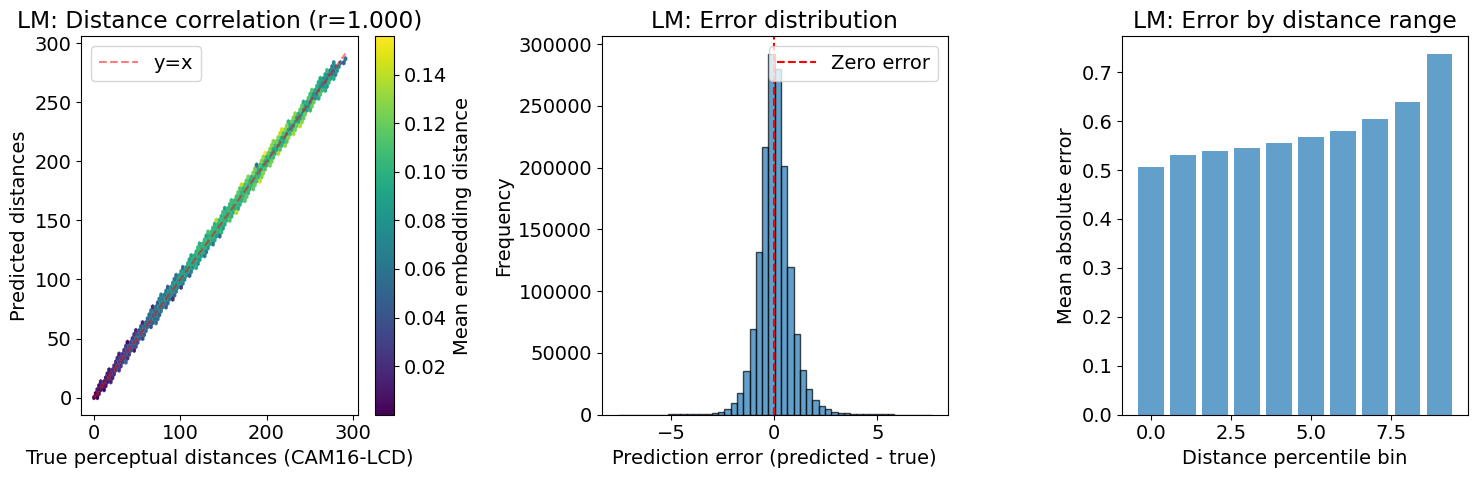

Size of singular values: (3,)

LM layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 1.97
  Top 3 singular values: [ 19.669308  13.477225  10.001116]

Vision layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9985 ± 0.0002
  Lasso: CV R² = 0.9800 ± 0.0017
  ElasticNet: CV R² = 0.9717 ± 0.0021
  Best model: Ridge

Vision layer performance:
  Overall R² = 0.9989, RMSE = 1.4439, MAE = 1.0518
  R² per dimension: L=0.999, a=0.999, b=0.999

Vision layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9986 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9986 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5288 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.6081 (p = 0.00e+00)
  Pearson(dist_emb, dist_pred)   = 0.5277 (p = 0.00e+00)
  Spearman(dist_emb, dist_pred)  = 0.6080 (p = 0.00e+00)
  k-NN preservation (k=5): 0.744
  k-NN preservation (k=10): 0.803
  k-NN preservation (k=20): 0.8

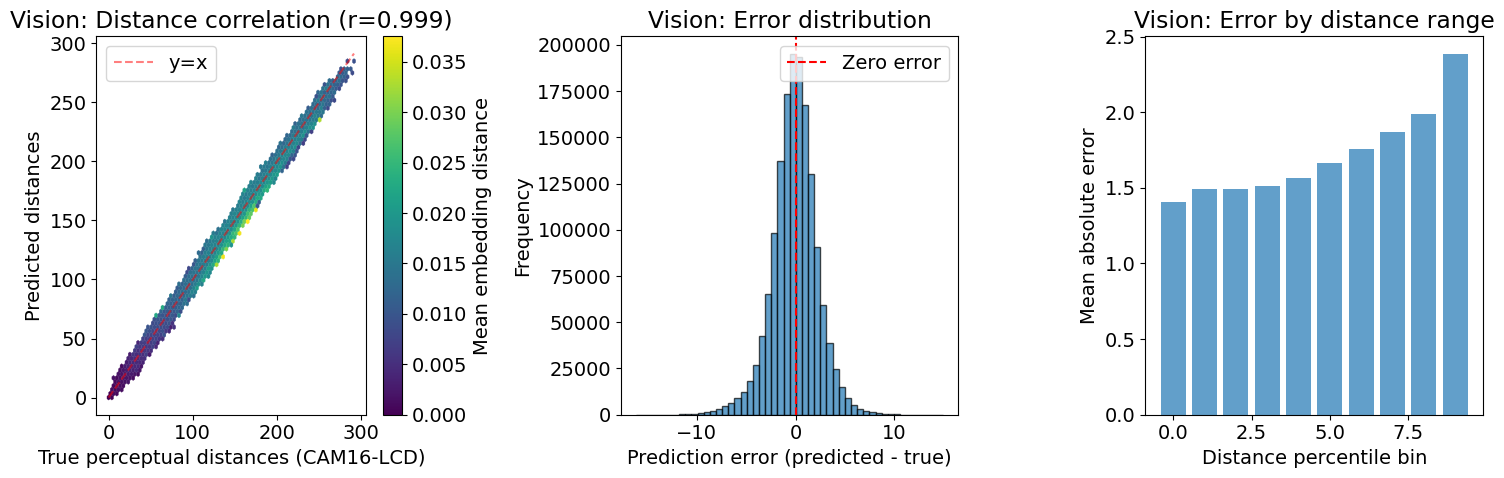

Size of singular values: (3,)

Vision layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 2.36
  Top 3 singular values: [ 91.111755  58.29886   38.640556]

Cross-layer comparison:
  Correlation between LM and Vision predictions:
    Pearson = 0.9999
    Spearman = 0.9998
  Distance preservation between layers: 0.9987


In [248]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ
from colour.models import XYZ_to_CAM16LCD
import seaborn as sns

def linear_color_mapping(embeddings, colors_xyY, layer_name="LM", alpha=1.0):
    # Преобразуем xyY → CAM16-LCD (векторизованно)
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    print(f"\n{'='*60}")
    print(f"{layer_name} layer: Converted to CAM16-LCD shape: {colors_cam.shape}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, colors_cam, test_size=0.2, random_state=42
    )

    # Сравнение разных моделей регрессии
    models = {
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha/10, max_iter=2000),
        'ElasticNet': ElasticNet(alpha=alpha/10, l1_ratio=0.5, max_iter=2000)
    }
    
    best_model = None
    best_score = -np.inf
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                   scoring='r2', n_jobs=-1)
        mean_cv_score = np.mean(cv_scores)
        print(f"  {name}: CV R² = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_model = model
            best_model_name = name
    
    # Обучаем лучшую модель
    reg = best_model
    reg.fit(X_train, y_train)
    print(f"  Best model: {best_model_name}")
    
    y_pred_test = reg.predict(X_test)
    y_pred_all = reg.predict(embeddings)

    # Расширенная оценка точности
    r2 = r2_score(y_test, y_pred_test, multioutput='variance_weighted')
    r2_per_dim = r2_score(y_test, y_pred_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"\n{layer_name} layer performance:")
    print(f"  Overall R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    print(f"  R² per dimension: L={r2_per_dim[0]:.3f}, a={r2_per_dim[1]:.3f}, b={r2_per_dim[2]:.3f}")

    # Вычисляем попарные расстояния (используем pdist для эффективности)
    # pdist возвращает только верхний треугольник матрицы расстояний
    v_emb = pdist(embeddings, metric='cosine')
    v_true = pdist(colors_cam, metric='euclidean')
    v_pred = pdist(y_pred_all, metric='euclidean')
    
    # Дополнительные метрики расстояний
    v_true_deltaE = pdist(colors_cam, metric='euclidean')  # ΔE в CAM16-LCD
    
    # Корреляции между расстояниями
    correlations = {}
    
    # True vs Predicted
    pearson_r, pearson_p = pearsonr(v_true, v_pred)
    spearman_r, spearman_p = spearmanr(v_true, v_pred)
    correlations['true_pred'] = {
        'pearson': (pearson_r, pearson_p),
        'spearman': (spearman_r, spearman_p)
    }
    
    # Embedding vs True
    emb_true_pr, emb_true_pp = pearsonr(v_emb, v_true)
    emb_true_sr, emb_true_sp = spearmanr(v_emb, v_true)
    correlations['emb_true'] = {
        'pearson': (emb_true_pr, emb_true_pp),
        'spearman': (emb_true_sr, emb_true_sp)
    }
    
    # Embedding vs Predicted
    emb_pred_pr, emb_pred_pp = pearsonr(v_emb, v_pred)
    emb_pred_sr, emb_pred_sp = spearmanr(v_emb, v_pred)
    correlations['emb_pred'] = {
        'pearson': (emb_pred_pr, emb_pred_pp),
        'spearman': (emb_pred_sr, emb_pred_sp)
    }
    
    print(f"\n{layer_name} layer distance correlations:")
    print(f"  Pearson(dist_true, dist_pred)  = {pearson_r:.4f} (p = {pearson_p:.2e})")
    print(f"  Spearman(dist_true, dist_pred) = {spearman_r:.4f} (p = {spearman_p:.2e})")
    print(f"  Pearson(dist_emb, dist_true)   = {emb_true_pr:.4f} (p = {emb_true_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_true)  = {emb_true_sr:.4f} (p = {emb_true_sp:.2e})")
    print(f"  Pearson(dist_emb, dist_pred)   = {emb_pred_pr:.4f} (p = {emb_pred_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_pred)  = {emb_pred_sr:.4f} (p = {emb_pred_sp:.2e})")
    
    # Анализ сохранения локальной структуры (k-NN consistency)
    k_neighbors = [5, 10, 20]
    for k in k_neighbors:
        knn_accuracy = compute_knn_preservation(embeddings, colors_cam, y_pred_all, k)
        print(f"  k-NN preservation (k={k}): {knn_accuracy:.3f}")
    
    # Анализ изотропности (проверка искажений в разных направлениях)
    isotropy_score = analyze_isotropy(v_true, v_pred)
    print(f"  Isotropy score: {isotropy_score:.3f}")
    
    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Scatter plot расстояний
    ax1 = axes[0]
    # scatter = ax1.scatter(v_true, v_pred, s=1, alpha=0.3, c=v_emb, cmap='viridis')
    # ax1.plot([0, max(v_true)], [0, max(v_true)], 'r--', alpha=0.5, label='y=x')
    # ax1.set_xlabel('True perceptual distances (CAM16-LCD)')
    # ax1.set_ylabel('Predicted distances')
    # ax1.set_title(f'{layer_name}: Distance correlation (r={pearson_r:.3f})')
    # ax1.legend()
    # plt.colorbar(scatter, ax=ax1, label='Embedding distance')
    h = ax1.hexbin(v_true, v_pred, C=v_emb, gridsize=75, 
                cmap='viridis', reduce_C_function=np.mean,
                linewidths=0.2, edgecolors='face')
    cb = plt.colorbar(h, ax=ax1, label='Mean embedding distance')
    ax1.plot([0, max(v_true)], [0, max(v_true)], 'r--', alpha=0.5, label='y=x')
    ax1.set_xlabel('True perceptual distances (CAM16-LCD)')
    ax1.set_ylabel('Predicted distances')
    ax1.set_title(f'{layer_name}: Distance correlation (r={pearson_r:.3f})')
    ax1.legend()

    # 2. Распределение ошибок
    ax2 = axes[1]
    errors = v_pred - v_true
    ax2.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='Zero error')
    ax2.set_xlabel('Prediction error (predicted - true)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{layer_name}: Error distribution')
    ax2.legend()
    
    # 3. Heatmap ошибок по расстояниям
    ax3 = axes[2]
    # Биннинг для анализа ошибок
    bins = np.percentile(v_true, np.linspace(0, 100, 11))
    bin_indices = np.digitize(v_true, bins) - 1
    mean_errors = [np.mean(np.abs(errors[bin_indices == i])) 
                   for i in range(len(bins)-1)]
    
    ax3.bar(range(len(mean_errors)), mean_errors, alpha=0.7)
    ax3.set_xlabel('Distance percentile bin')
    ax3.set_ylabel('Mean absolute error')
    ax3.set_title(f'{layer_name}: Error by distance range')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ матрицы преобразования
    W = reg.coef_
    b = reg.intercept_
    
    # Singular value decomposition для анализа ранга
    U, s, Vt = np.linalg.svd(W)
    print(f'Size of singular values: {s.shape}')
    effective_rank = np.sum(s > 0.01 * s[0])  # Эффективный ранг
    condition_number = s[0] / s[-1] if s[-1] > 0 else np.inf
    
    print(f"\n{layer_name} layer transformation analysis:")
    print(f"  Matrix W shape: {W.shape}, Bias b shape: {b.shape}")
    print(f"  Effective rank: {effective_rank}/{min(W.shape)}")
    print(f"  Condition number: {condition_number:.2f}")
    print(f"  Top 3 singular values: {s[:3]}")
    
    return {
        'predictions': y_pred_all,
        'model': reg,
        'W': W,
        'b': b,
        'correlations': correlations,
        'metrics': {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'isotropy': isotropy_score
        }
    }

def compute_knn_preservation(embeddings, true_colors, pred_colors, k=10):
    """Проверяет, сохраняются ли k ближайших соседей после преобразования"""
    from sklearn.neighbors import NearestNeighbors
    
    nn_emb = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn_true = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn_pred = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    
    nn_emb.fit(embeddings)
    nn_true.fit(true_colors)
    nn_pred.fit(pred_colors)
    
    preservation_scores = []
    for i in range(len(embeddings)):
        # Находим k ближайших соседей (исключая сам элемент)
        emb_neighbors = set(nn_emb.kneighbors([embeddings[i]], return_distance=False)[0][1:])
        true_neighbors = set(nn_true.kneighbors([true_colors[i]], return_distance=False)[0][1:])
        pred_neighbors = set(nn_pred.kneighbors([pred_colors[i]], return_distance=False)[0][1:])
        
        # Jaccard similarity между true и predicted
        intersection = len(true_neighbors & pred_neighbors)
        union = len(true_neighbors | pred_neighbors)
        preservation_scores.append(intersection / union if union > 0 else 0)
    
    return np.mean(preservation_scores)

def analyze_isotropy(true_distances, pred_distances):
    """Анализирует изотропность преобразования"""
    # Разбиваем расстояния на квантили и проверяем дисперсию ошибок
    n_bins = 10
    bins = np.percentile(true_distances, np.linspace(0, 100, n_bins+1))
    bin_indices = np.digitize(true_distances, bins) - 1
    
    errors_by_bin = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            rel_errors = np.abs((pred_distances[mask] - true_distances[mask]) / 
                              (true_distances[mask] + 1e-6))
            errors_by_bin.append(np.std(rel_errors))
    
    # Низкая дисперсия дисперсий означает изотропность
    isotropy = 1.0 / (1.0 + np.std(errors_by_bin))
    return isotropy

# Запуск анализа
print("Starting color space calibration analysis...")

# LM layer
results_lm = linear_color_mapping(lm_matrix_all, colors_xyY_all, layer_name="LM", alpha=1.0)

# Vision layer  
results_vl = linear_color_mapping(vision_matrix_all, colors_xyY_all, layer_name="Vision", alpha=1.0)

# Сравнение между слоями
print(f"\n{'='*60}")
print("Cross-layer comparison:")

# Корреляция предсказаний
pred_corr_pearson = pearsonr(results_lm['predictions'].flatten(), 
                             results_vl['predictions'].flatten())[0]
pred_corr_spearman = spearmanr(results_lm['predictions'].flatten(), 
                               results_vl['predictions'].flatten())[0]

print(f"  Correlation between LM and Vision predictions:")
print(f"    Pearson = {pred_corr_pearson:.4f}")
print(f"    Spearman = {pred_corr_spearman:.4f}")

# Согласованность расстояний между слоями
v_pred_lm = pdist(results_lm['predictions'], metric='euclidean')
v_pred_vl = pdist(results_vl['predictions'], metric='euclidean')
dist_corr = pearsonr(v_pred_lm, v_pred_vl)[0]
print(f"  Distance preservation between layers: {dist_corr:.4f}")


# Анализ свзависимости   ошибок предсказаний  от цветовых характеристик

Starting color space calibration analysis with HSV focus...

LM layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9995 ± 0.0000
  Lasso: CV R² = 0.9966 ± 0.0004
  ElasticNet: CV R² = 0.9974 ± 0.0002
  Best model: Ridge

LM layer performance:
  Overall R² = 0.9996, RMSE = 0.9017, MAE = 0.6663
  R² per dimension: L=1.000, a=0.999, b=1.000

LM layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9998 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9998 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5157 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.5596 (p = 0.00e+00)
  k-NN preservation (k=5): 0.859
  k-NN preservation (k=10): 0.896
  k-NN preservation (k=20): 0.915
  Isotropy score: 0.994


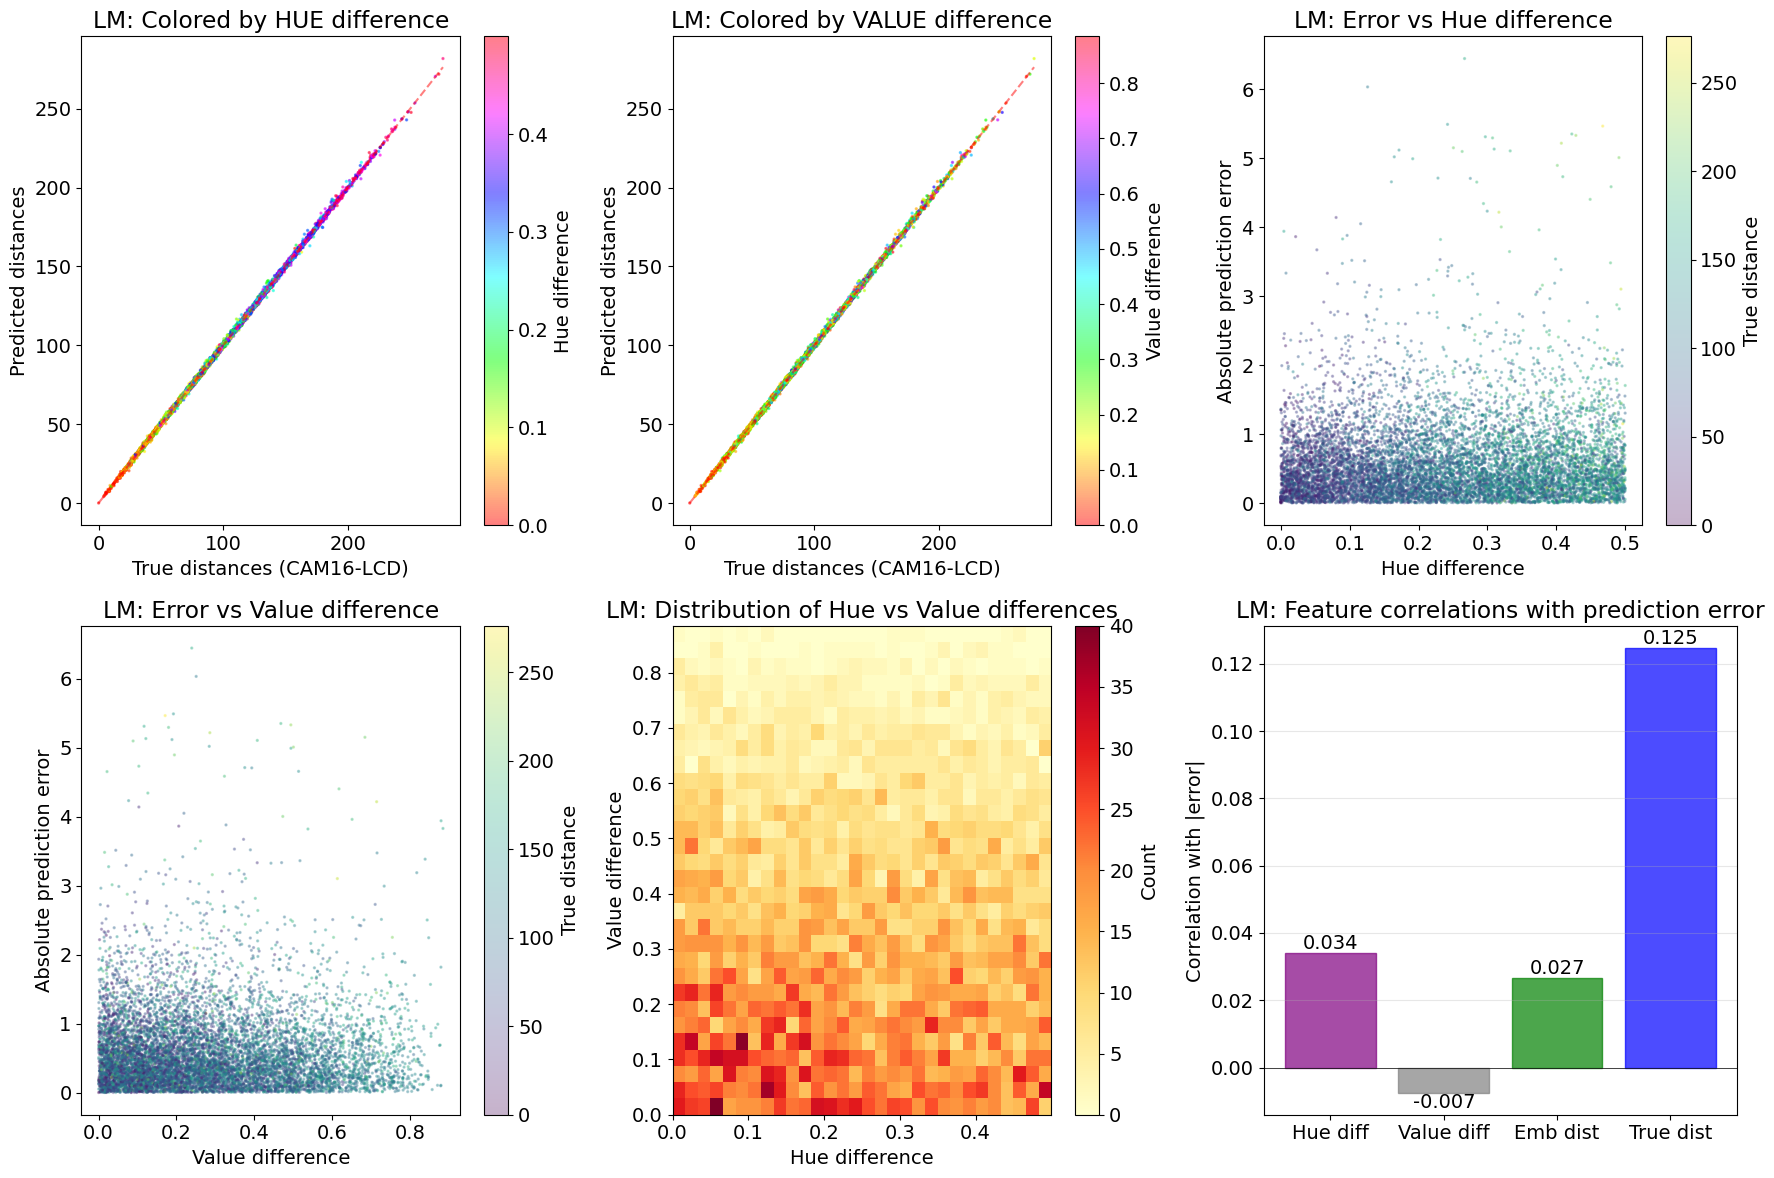

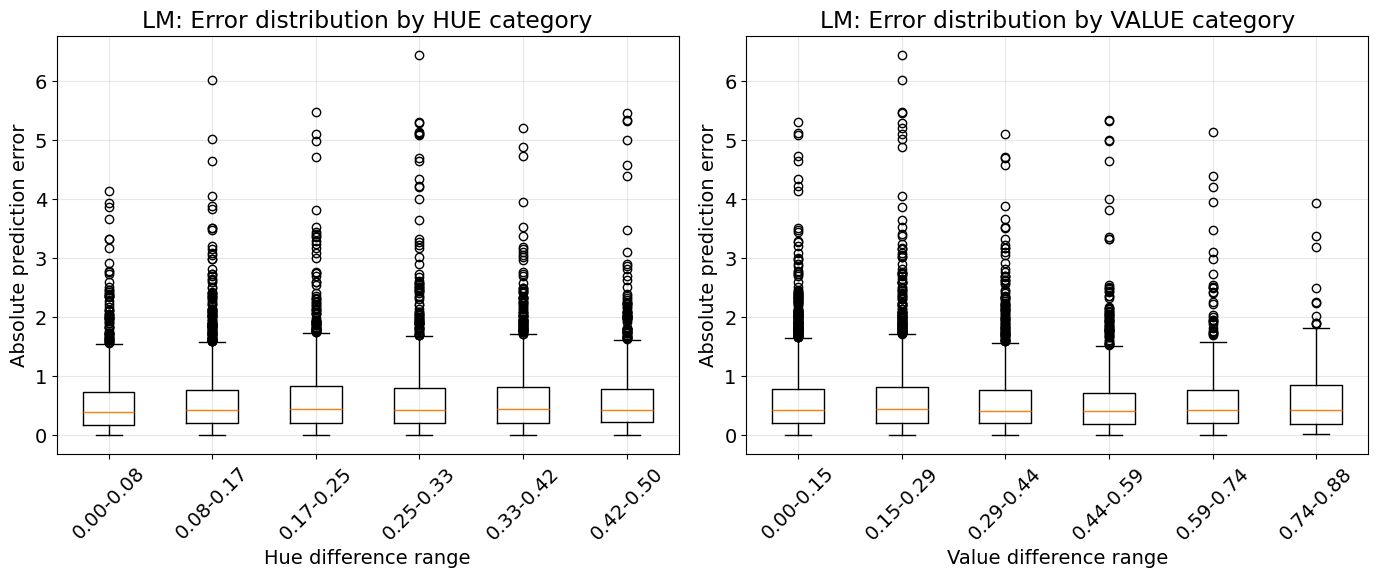


LM - HSV Analysis Summary:
  Hue difference range: [0.000, 0.500]
  Value difference range: [0.000, 0.885]
  Correlation(hue_diff, |error|): 0.034
  Correlation(value_diff, |error|): -0.007

LM layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 1.97
  Top 3 singular values: [ 19.669308  13.477225  10.001116]

Vision layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9985 ± 0.0002
  Lasso: CV R² = 0.9800 ± 0.0017
  ElasticNet: CV R² = 0.9717 ± 0.0021
  Best model: Ridge

Vision layer performance:
  Overall R² = 0.9989, RMSE = 1.4439, MAE = 1.0518
  R² per dimension: L=0.999, a=0.999, b=0.999

Vision layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9986 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9986 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5288 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.6081 (p = 0.00e+00)
  k-NN preservation (k=5): 0.744
  k-NN preservatio

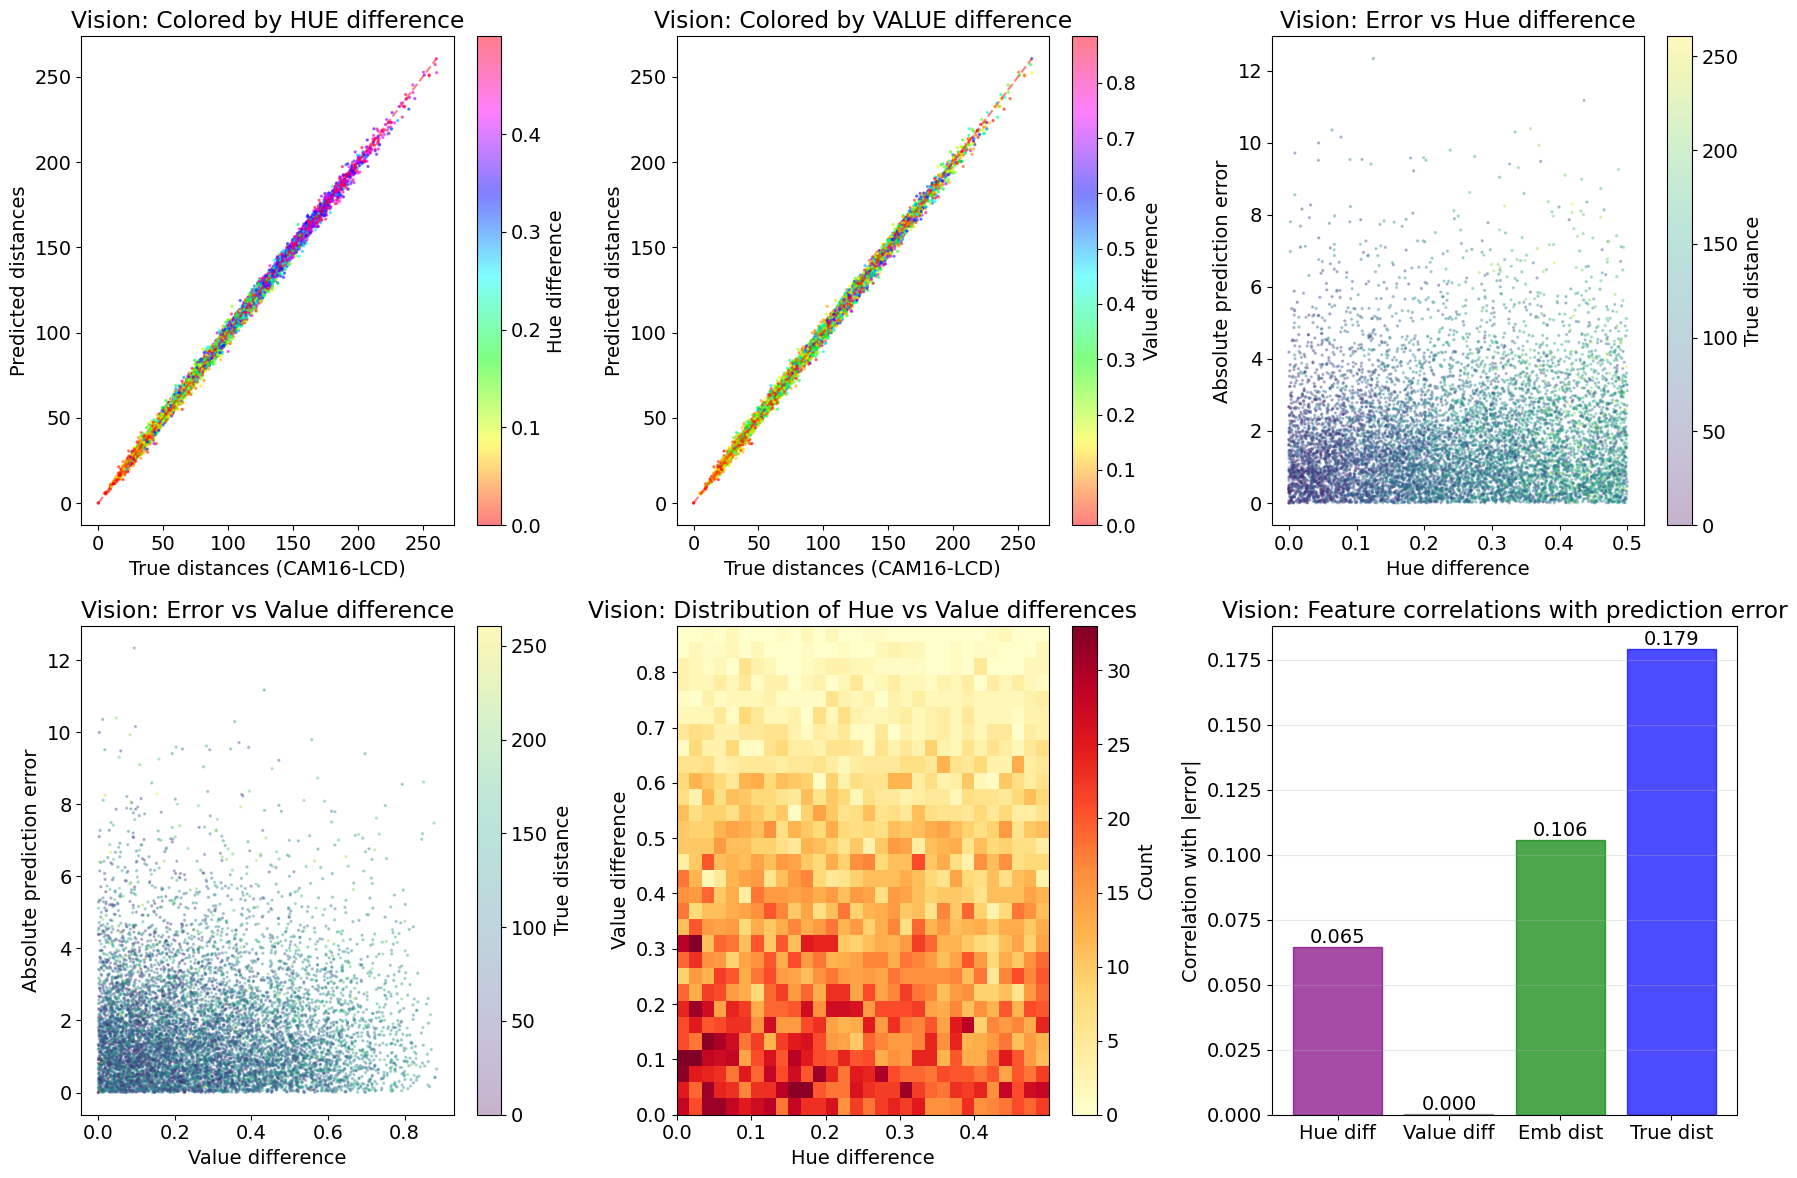

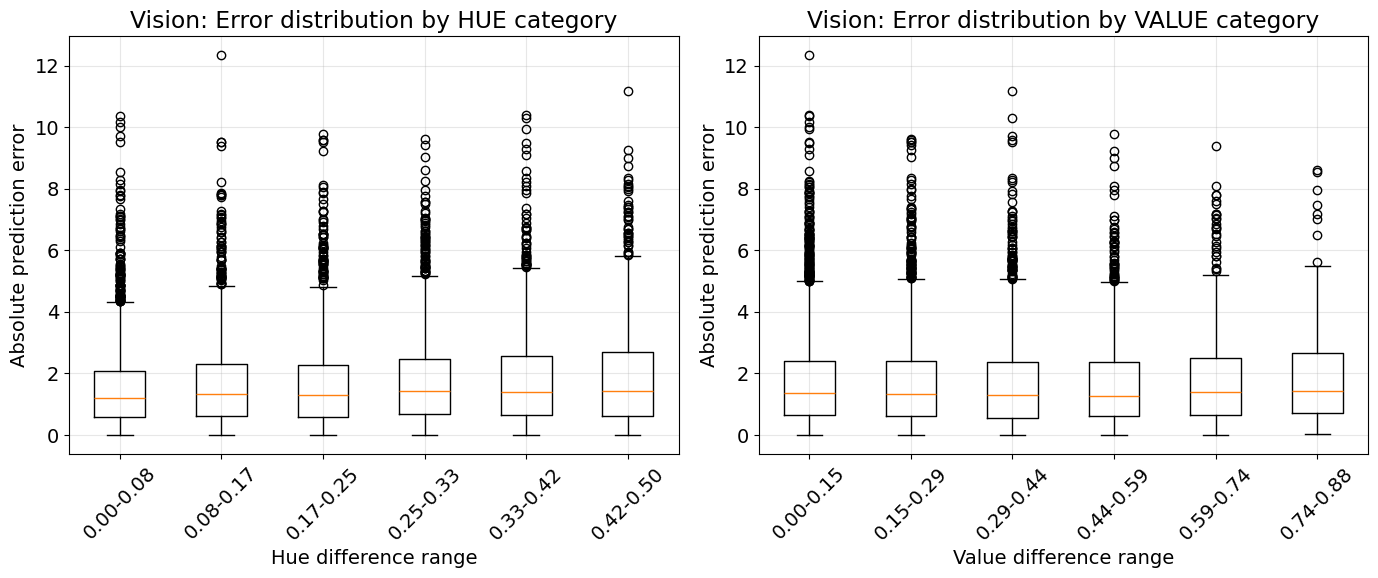


Vision - HSV Analysis Summary:
  Hue difference range: [0.000, 0.500]
  Value difference range: [0.000, 0.884]
  Correlation(hue_diff, |error|): 0.065
  Correlation(value_diff, |error|): 0.000

Vision layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 2.36
  Top 3 singular values: [ 91.111755  58.29886   38.640556]

Cross-layer comparison:
  Correlation between LM and Vision predictions:
    Pearson = 0.9999
    Spearman = 0.9998
  Distance preservation between layers: 0.9987


In [249]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ, XYZ_to_sRGB
from colour.models import XYZ_to_CAM16LCD
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv
import warnings
warnings.filterwarnings('ignore')

def get_rgb_colors_from_meta(color_meta_all):
    """Извлекает RGB цвета из метаданных"""
    keys = sorted(color_meta_all.keys(), key=lambda k: int(k))
    rgb_colors = np.array([
        [color_meta_all[k]['RGB']['R'],
         color_meta_all[k]['RGB']['G'],
         color_meta_all[k]['RGB']['B']]
        for k in keys
    ])
    # Клиппинг в диапазон [0, 1]
    rgb_colors = np.clip(rgb_colors, 0, 1)
    return rgb_colors

def compute_hsv_differences(rgb_colors, pair_indices):
    """Вычисляет различия в HSV пространстве для пар цветов"""
    hue_diffs = []
    value_diffs = []
    
    for i, j in pair_indices:
        hsv1 = rgb_to_hsv(rgb_colors[i])
        hsv2 = rgb_to_hsv(rgb_colors[j])
        
        # Hue difference (circular)
        h_diff = np.abs(hsv1[0] - hsv2[0])
        if h_diff > 0.5:
            h_diff = 1.0 - h_diff
        hue_diffs.append(h_diff)
        
        # Value difference
        v_diff = np.abs(hsv1[2] - hsv2[2])
        value_diffs.append(v_diff)
    
    return np.array(hue_diffs), np.array(value_diffs)

def linear_color_mapping(embeddings, colors_xyY, color_meta_all=None, layer_name="LM", alpha=1.0):
    # Преобразуем xyY → CAM16-LCD (векторизованно)
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    print(f"\n{'='*60}")
    print(f"{layer_name} layer: Converted to CAM16-LCD shape: {colors_cam.shape}")
    
    # Получаем RGB цвета если есть метаданные
    rgb_colors = None
    if color_meta_all is not None:
        rgb_colors = get_rgb_colors_from_meta(color_meta_all)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, colors_cam, test_size=0.2, random_state=42
    )

    # Сравнение разных моделей регрессии
    models = {
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha/10, max_iter=2000),
        'ElasticNet': ElasticNet(alpha=alpha/10, l1_ratio=0.5, max_iter=2000)
    }
    
    best_model = None
    best_score = -np.inf
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                   scoring='r2', n_jobs=-1)
        mean_cv_score = np.mean(cv_scores)
        print(f"  {name}: CV R² = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_model = model
            best_model_name = name
    
    # Обучаем лучшую модель
    reg = best_model
    reg.fit(X_train, y_train)
    print(f"  Best model: {best_model_name}")
    
    y_pred_test = reg.predict(X_test)
    y_pred_all = reg.predict(embeddings)

    # Расширенная оценка точности
    r2 = r2_score(y_test, y_pred_test, multioutput='variance_weighted')
    r2_per_dim = r2_score(y_test, y_pred_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"\n{layer_name} layer performance:")
    print(f"  Overall R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    print(f"  R² per dimension: L={r2_per_dim[0]:.3f}, a={r2_per_dim[1]:.3f}, b={r2_per_dim[2]:.3f}")

    # Вычисляем попарные расстояния
    v_emb = pdist(embeddings, metric='cosine')
    v_true = pdist(colors_cam, metric='euclidean')
    v_pred = pdist(y_pred_all, metric='euclidean')
    
    # Корреляции между расстояниями
    correlations = {}
    
    # True vs Predicted
    pearson_r, pearson_p = pearsonr(v_true, v_pred)
    spearman_r, spearman_p = spearmanr(v_true, v_pred)
    correlations['true_pred'] = {
        'pearson': (pearson_r, pearson_p),
        'spearman': (spearman_r, spearman_p)
    }
    
    # Embedding vs True
    emb_true_pr, emb_true_pp = pearsonr(v_emb, v_true)
    emb_true_sr, emb_true_sp = spearmanr(v_emb, v_true)
    correlations['emb_true'] = {
        'pearson': (emb_true_pr, emb_true_pp),
        'spearman': (emb_true_sr, emb_true_sp)
    }
    
    print(f"\n{layer_name} layer distance correlations:")
    print(f"  Pearson(dist_true, dist_pred)  = {pearson_r:.4f} (p = {pearson_p:.2e})")
    print(f"  Spearman(dist_true, dist_pred) = {spearman_r:.4f} (p = {spearman_p:.2e})")
    print(f"  Pearson(dist_emb, dist_true)   = {emb_true_pr:.4f} (p = {emb_true_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_true)  = {emb_true_sr:.4f} (p = {emb_true_sp:.2e})")
    
    # Анализ сохранения локальной структуры
    k_neighbors = [5, 10, 20]
    for k in k_neighbors:
        knn_accuracy = compute_knn_preservation(embeddings, colors_cam, y_pred_all, k)
        print(f"  k-NN preservation (k={k}): {knn_accuracy:.3f}")
    
    # Анализ изотропности
    isotropy_score = analyze_isotropy(v_true, v_pred)
    print(f"  Isotropy score: {isotropy_score:.3f}")
    
    # === ВИЗУАЛИЗАЦИЯ ТОЛЬКО HUE И VALUE РАЗЛИЧИЙ ===
    
    if rgb_colors is not None:
        # Подготовка пар точек
        n = len(rgb_colors)
        pair_indices = np.array([(i, j) for i in range(n) for j in range(i+1, n)])
        
        # Семплируем для визуализации
        max_points = 10000
        if len(pair_indices) > max_points:
            sample_idx = np.random.choice(len(pair_indices), max_points, replace=False)
            sampled_pairs = pair_indices[sample_idx]
            sampled_v_true = v_true[sample_idx]
            sampled_v_pred = v_pred[sample_idx]
            sampled_v_emb = v_emb[sample_idx]
            sampled_errors = sampled_v_pred - sampled_v_true
        else:
            sampled_pairs = pair_indices
            sampled_v_true = v_true
            sampled_v_pred = v_pred
            sampled_v_emb = v_emb
            sampled_errors = v_pred - v_true
        
        # Вычисляем HSV различия
        hue_diffs, value_diffs = compute_hsv_differences(rgb_colors, sampled_pairs)
        
        # === ОСНОВНЫЕ ГРАФИКИ HUE И VALUE ===
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Расстояния с цветом по HUE difference
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(sampled_v_true, sampled_v_pred, s=2, alpha=0.5,
                              c=hue_diffs, cmap='hsv')
        ax1.plot([0, max(sampled_v_true)], [0, max(sampled_v_true)], 'r--', alpha=0.5)
        ax1.set_xlabel('True distances (CAM16-LCD)')
        ax1.set_ylabel('Predicted distances')
        ax1.set_title(f'{layer_name}: Colored by HUE difference')
        plt.colorbar(scatter1, ax=ax1, label='Hue difference')
        
        # 2. Расстояния с цветом по VALUE difference
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(sampled_v_true, sampled_v_pred, s=2, alpha=0.5,
                              c=value_diffs, cmap='hsv')
        ax2.plot([0, max(sampled_v_true)], [0, max(sampled_v_true)], 'r--', alpha=0.5)
        ax2.set_xlabel('True distances (CAM16-LCD)')
        ax2.set_ylabel('Predicted distances')
        ax2.set_title(f'{layer_name}: Colored by VALUE difference')
        plt.colorbar(scatter2, ax=ax2, label='Value difference')
        
        # 3. Ошибки vs HUE difference
        ax3 = axes[0, 2]
        scatter3 = ax3.scatter(hue_diffs, np.abs(sampled_errors), s=2, alpha=0.3,
                              c=sampled_v_true, cmap='viridis')
        ax3.set_xlabel('Hue difference')
        ax3.set_ylabel('Absolute prediction error')
        ax3.set_title(f'{layer_name}: Error vs Hue difference')
        plt.colorbar(scatter3, ax=ax3, label='True distance')
        
        # 4. Ошибки vs VALUE difference
        ax4 = axes[1, 0]
        scatter4 = ax4.scatter(value_diffs, np.abs(sampled_errors), s=2, alpha=0.3,
                              c=sampled_v_true, cmap='viridis')
        ax4.set_xlabel('Value difference')
        ax4.set_ylabel('Absolute prediction error')
        ax4.set_title(f'{layer_name}: Error vs Value difference')
        plt.colorbar(scatter4, ax=ax4, label='True distance')
        
        # 5. 2D histogram: Hue vs Value differences
        ax5 = axes[1, 1]
        h = ax5.hist2d(hue_diffs, value_diffs, bins=30, cmap='YlOrRd')
        ax5.set_xlabel('Hue difference')
        ax5.set_ylabel('Value difference')
        ax5.set_title(f'{layer_name}: Distribution of Hue vs Value differences')
        plt.colorbar(h[3], ax=ax5, label='Count')
        
        # 6. Корреляции с ошибкой
        ax6 = axes[1, 2]
        correlations_with_error = {
            'Hue diff': pearsonr(hue_diffs, np.abs(sampled_errors))[0],
            'Value diff': pearsonr(value_diffs, np.abs(sampled_errors))[0],
            'Emb dist': pearsonr(sampled_v_emb, np.abs(sampled_errors))[0],
            'True dist': pearsonr(sampled_v_true, np.abs(sampled_errors))[0],
        }
        
        bars = ax6.bar(range(len(correlations_with_error)), 
                       list(correlations_with_error.values()),
                       tick_label=list(correlations_with_error.keys()))
        ax6.set_ylabel('Correlation with |error|')
        ax6.set_title(f'{layer_name}: Feature correlations with prediction error')
        ax6.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Цветовая кодировка баров
        colors_bars = ['purple', 'gray', 'green', 'blue']
        for bar, color in zip(bars, colors_bars):
            bar.set_color(color)
            bar.set_alpha(0.7)
        
        # Добавляем значения на бары
        for bar, val in zip(bars, correlations_with_error.values()):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top')
        
        plt.tight_layout()
        plt.show()
        
        # === ДЕТАЛЬНЫЙ АНАЛИЗ ПО КАТЕГОРИЯМ ===
        fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
        
        # Анализ ошибок по категориям HUE
        ax1 = axes2[0]
        n_hue_bins = 6
        hue_bins = np.linspace(0, hue_diffs.max(), n_hue_bins+1)
        hue_categories = np.digitize(hue_diffs, hue_bins) - 1
        
        hue_errors = []
        hue_labels = []
        for cat in range(n_hue_bins):
            mask = hue_categories == cat
            if np.sum(mask) > 10:  # Минимум 10 точек в категории
                hue_errors.append(np.abs(sampled_errors[mask]))
                hue_labels.append(f'{hue_bins[cat]:.2f}-{hue_bins[cat+1]:.2f}')
        
        bp1 = ax1.boxplot(hue_errors, labels=hue_labels)
        ax1.set_xlabel('Hue difference range')
        ax1.set_ylabel('Absolute prediction error')
        ax1.set_title(f'{layer_name}: Error distribution by HUE category')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Анализ ошибок по категориям VALUE
        ax2 = axes2[1]
        n_value_bins = 6
        value_bins = np.linspace(0, value_diffs.max(), n_value_bins+1)
        value_categories = np.digitize(value_diffs, value_bins) - 1
        
        value_errors = []
        value_labels = []
        for cat in range(n_value_bins):
            mask = value_categories == cat
            if np.sum(mask) > 10:  # Минимум 10 точек в категории
                value_errors.append(np.abs(sampled_errors[mask]))
                value_labels.append(f'{value_bins[cat]:.2f}-{value_bins[cat+1]:.2f}')
        
        bp2 = ax2.boxplot(value_errors, labels=value_labels)
        ax2.set_xlabel('Value difference range')
        ax2.set_ylabel('Absolute prediction error')
        ax2.set_title(f'{layer_name}: Error distribution by VALUE category')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Печать статистики
        print(f"\n{layer_name} - HSV Analysis Summary:")
        print(f"  Hue difference range: [{hue_diffs.min():.3f}, {hue_diffs.max():.3f}]")
        print(f"  Value difference range: [{value_diffs.min():.3f}, {value_diffs.max():.3f}]")
        print(f"  Correlation(hue_diff, |error|): {correlations_with_error['Hue diff']:.3f}")
        print(f"  Correlation(value_diff, |error|): {correlations_with_error['Value diff']:.3f}")
    
    # Анализ матрицы преобразования
    W = reg.coef_
    b = reg.intercept_
    
    # Singular value decomposition
    U, s, Vt = np.linalg.svd(W)
    effective_rank = np.sum(s > 0.01 * s[0])
    condition_number = s[0] / s[-1] if s[-1] > 0 else np.inf
    
    print(f"\n{layer_name} layer transformation analysis:")
    print(f"  Matrix W shape: {W.shape}, Bias b shape: {b.shape}")
    print(f"  Effective rank: {effective_rank}/{min(W.shape)}")
    print(f"  Condition number: {condition_number:.2f}")
    print(f"  Top 3 singular values: {s[:3]}")
    
    return {
        'predictions': y_pred_all,
        'model': reg,
        'W': W,
        'b': b,
        'correlations': correlations,
        'metrics': {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'isotropy': isotropy_score
        }
    }

# Остальные функции остаются без изменений
def compute_knn_preservation(embeddings, true_colors, pred_colors, k=10):
    """Проверяет, сохраняются ли k ближайших соседей после преобразования"""
    from sklearn.neighbors import NearestNeighbors
    
    nn_emb = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn_true = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn_pred = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    
    nn_emb.fit(embeddings)
    nn_true.fit(true_colors)
    nn_pred.fit(pred_colors)
    
    preservation_scores = []
    for i in range(len(embeddings)):
        emb_neighbors = set(nn_emb.kneighbors([embeddings[i]], return_distance=False)[0][1:])
        true_neighbors = set(nn_true.kneighbors([true_colors[i]], return_distance=False)[0][1:])
        pred_neighbors = set(nn_pred.kneighbors([pred_colors[i]], return_distance=False)[0][1:])
        
        intersection = len(true_neighbors & pred_neighbors)
        union = len(true_neighbors | pred_neighbors)
        preservation_scores.append(intersection / union if union > 0 else 0)
    
    return np.mean(preservation_scores)

def analyze_isotropy(true_distances, pred_distances):
    """Анализирует изотропность преобразования"""
    n_bins = 10
    bins = np.percentile(true_distances, np.linspace(0, 100, n_bins+1))
    bin_indices = np.digitize(true_distances, bins) - 1
    
    errors_by_bin = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            rel_errors = np.abs((pred_distances[mask] - true_distances[mask]) / 
                              (true_distances[mask] + 1e-6))
            errors_by_bin.append(np.std(rel_errors))
    
    isotropy = 1.0 / (1.0 + np.std(errors_by_bin))
    return isotropy

# Запуск анализа
print("Starting color space calibration analysis with HSV focus...")

# LM layer с цветовой информацией
results_lm = linear_color_mapping(lm_matrix_all, colors_xyY_all, 
                                 color_meta_all=color_meta_all,
                                 layer_name="LM", alpha=1.0)

# Vision layer с цветовой информацией
results_vl = linear_color_mapping(vision_matrix_all, colors_xyY_all,
                                 color_meta_all=color_meta_all, 
                                 layer_name="Vision", alpha=1.0)

# Сравнение между слоями
print(f"\n{'='*60}")
print("Cross-layer comparison:")

pred_corr_pearson = pearsonr(results_lm['predictions'].flatten(), 
                             results_vl['predictions'].flatten())[0]
pred_corr_spearman = spearmanr(results_lm['predictions'].flatten(), 
                               results_vl['predictions'].flatten())[0]

print(f"  Correlation between LM and Vision predictions:")
print(f"    Pearson = {pred_corr_pearson:.4f}")
print(f"    Spearman = {pred_corr_spearman:.4f}")

v_pred_lm = pdist(results_lm['predictions'], metric='euclidean')
v_pred_vl = pdist(results_vl['predictions'], metric='euclidean')
dist_corr = pearsonr(v_pred_lm, v_pred_vl)[0]
print(f"  Distance preservation between layers: {dist_corr:.4f}")


Starting color space calibration analysis with HSV focus...

LM layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9995 ± 0.0000
  Lasso: CV R² = 0.9966 ± 0.0004
  ElasticNet: CV R² = 0.9974 ± 0.0002
  Best model: Ridge

LM layer performance:
  Overall R² = 0.9996, RMSE = 0.9017, MAE = 0.6663
  R² per dimension: L=1.000, a=0.999, b=1.000

LM layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9998 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9998 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5157 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.5596 (p = 0.00e+00)
  k-NN preservation (k=5): 0.859
  k-NN preservation (k=10): 0.896
  k-NN preservation (k=20): 0.915
  Isotropy score: 0.994


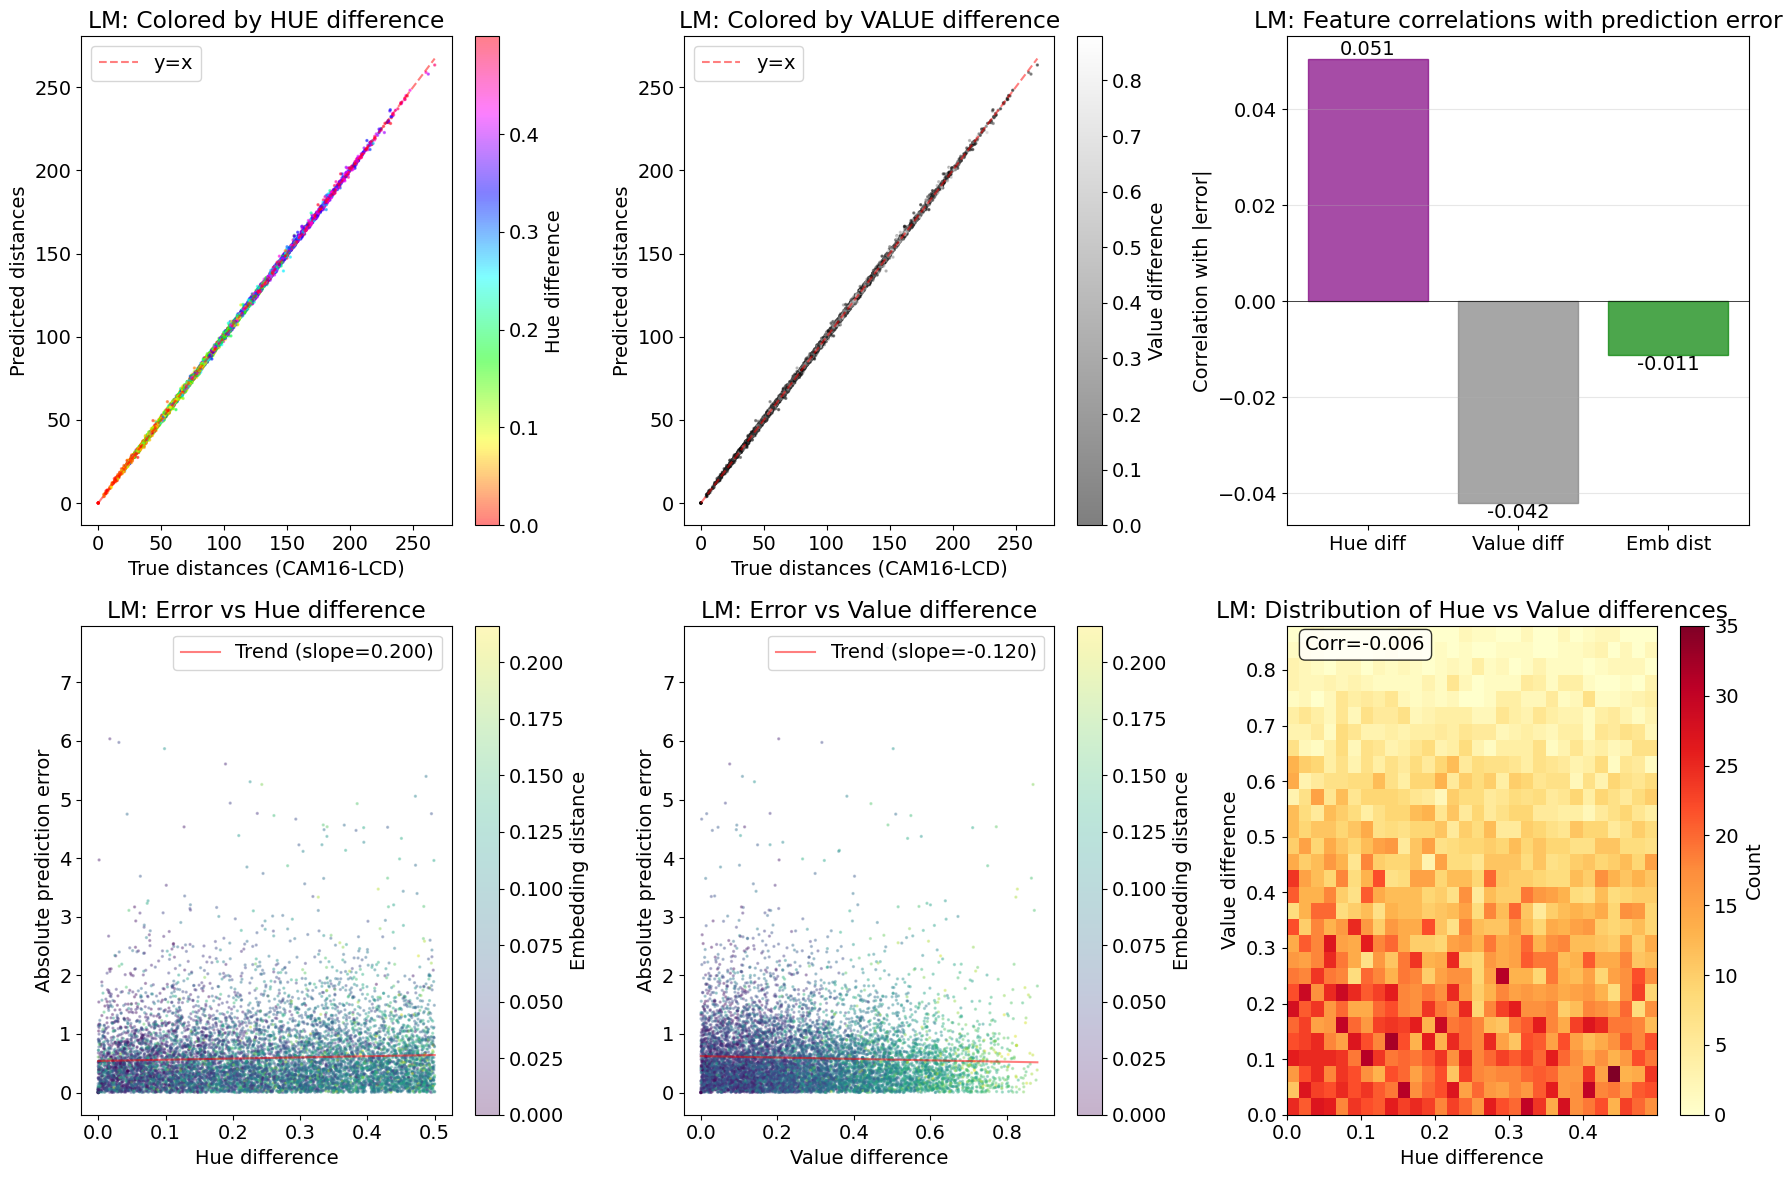


LM - HSV Analysis Summary:
  Hue difference range: [0.000, 0.500]
  Value difference range: [0.000, 0.879]
  Correlation(hue_diff, |error|): 0.051
  Correlation(value_diff, |error|): -0.042
  Correlation(hue_diff, value_diff): -0.006

LM layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 1.97
  Top 3 singular values: [ 19.669308  13.477225  10.001116]

Vision layer: Converted to CAM16-LCD shape: (1755, 3)
  Ridge: CV R² = 0.9985 ± 0.0002
  Lasso: CV R² = 0.9800 ± 0.0017
  ElasticNet: CV R² = 0.9717 ± 0.0021
  Best model: Ridge

Vision layer performance:
  Overall R² = 0.9989, RMSE = 1.4439, MAE = 1.0518
  R² per dimension: L=0.999, a=0.999, b=0.999

Vision layer distance correlations:
  Pearson(dist_true, dist_pred)  = 0.9986 (p = 0.00e+00)
  Spearman(dist_true, dist_pred) = 0.9986 (p = 0.00e+00)
  Pearson(dist_emb, dist_true)   = 0.5288 (p = 0.00e+00)
  Spearman(dist_emb, dist_true)  = 0.6081 (p = 0.00e+00)
  k-NN 

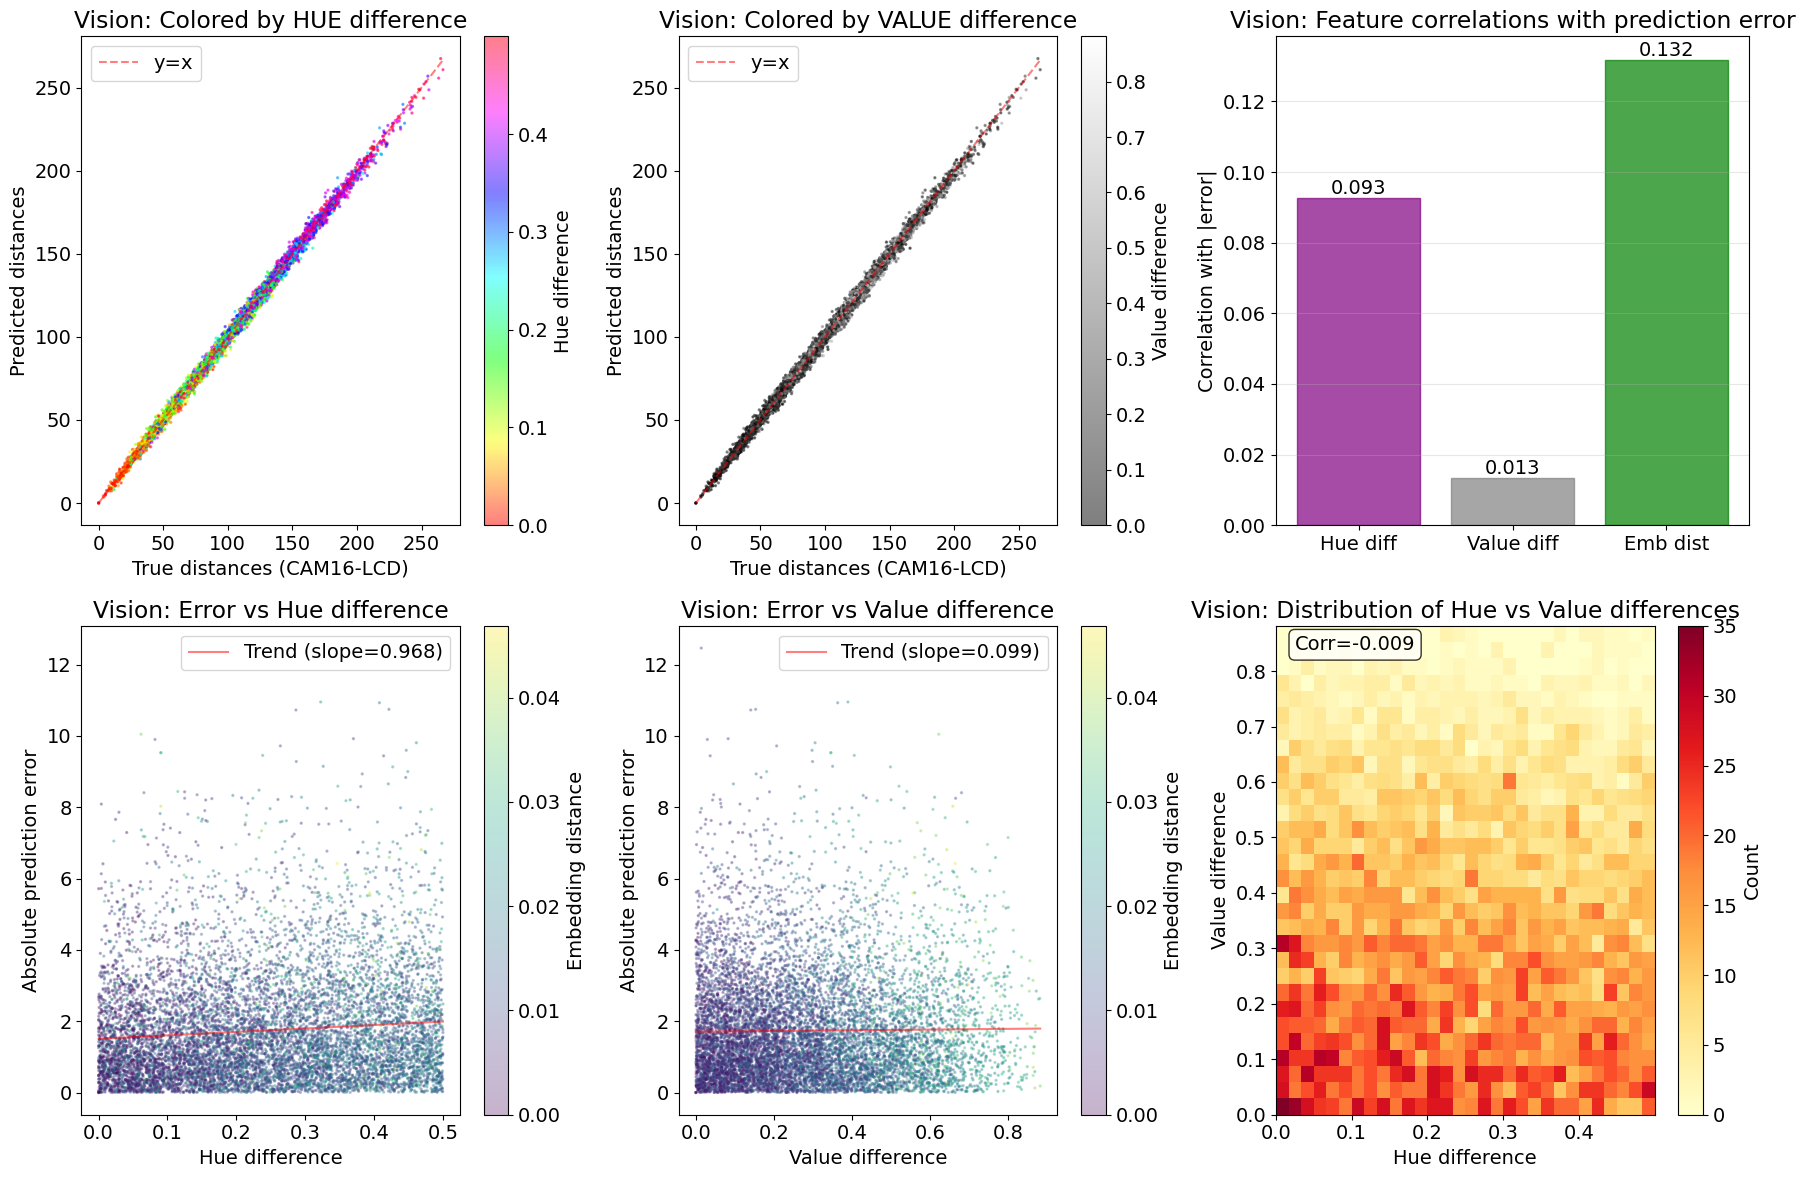


Vision - HSV Analysis Summary:
  Hue difference range: [0.000, 0.500]
  Value difference range: [0.000, 0.882]
  Correlation(hue_diff, |error|): 0.093
  Correlation(value_diff, |error|): 0.013
  Correlation(hue_diff, value_diff): -0.009

Vision layer transformation analysis:
  Matrix W shape: (3, 3584), Bias b shape: (3,)
  Effective rank: 3/3
  Condition number: 2.36
  Top 3 singular values: [ 91.111755  58.29886   38.640556]

Cross-layer comparison:
  Correlation between LM and Vision predictions:
    Pearson = 0.9999
    Spearman = 0.9998
  Distance preservation between layers: 0.9987


In [250]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ, XYZ_to_sRGB
from colour.models import XYZ_to_CAM16LCD
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv
import warnings
warnings.filterwarnings('ignore')

def get_rgb_colors_from_meta(color_meta_all):
    """Извлекает RGB цвета из метаданных"""
    keys = sorted(color_meta_all.keys(), key=lambda k: int(k))
    rgb_colors = np.array([
        [color_meta_all[k]['RGB']['R'],
         color_meta_all[k]['RGB']['G'],
         color_meta_all[k]['RGB']['B']]
        for k in keys
    ])
    # Клиппинг в диапазон [0, 1]
    rgb_colors = np.clip(rgb_colors, 0, 1)
    return rgb_colors

def compute_hsv_differences(rgb_colors, pair_indices):
    """Вычисляет различия в HSV пространстве для пар цветов"""
    hue_diffs = []
    value_diffs = []
    
    for i, j in pair_indices:
        hsv1 = rgb_to_hsv(rgb_colors[i])
        hsv2 = rgb_to_hsv(rgb_colors[j])
        
        # Hue difference (circular)
        h_diff = np.abs(hsv1[0] - hsv2[0])
        if h_diff > 0.5:
            h_diff = 1.0 - h_diff
        hue_diffs.append(h_diff)
        
        # Value difference
        v_diff = np.abs(hsv1[2] - hsv2[2])
        value_diffs.append(v_diff)
    
    return np.array(hue_diffs), np.array(value_diffs)

def linear_color_mapping(embeddings, colors_xyY, color_meta_all=None, layer_name="LM", alpha=1.0):
    # Преобразуем xyY → CAM16-LCD (векторизованно)
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    print(f"\n{'='*60}")
    print(f"{layer_name} layer: Converted to CAM16-LCD shape: {colors_cam.shape}")
    
    # Получаем RGB цвета если есть метаданные
    rgb_colors = None
    if color_meta_all is not None:
        rgb_colors = get_rgb_colors_from_meta(color_meta_all)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, colors_cam, test_size=0.2, random_state=42
    )

    # Сравнение разных моделей регрессии
    models = {
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha/10, max_iter=2000),
        'ElasticNet': ElasticNet(alpha=alpha/10, l1_ratio=0.5, max_iter=2000)
    }
    
    best_model = None
    best_score = -np.inf
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                   scoring='r2', n_jobs=-1)
        mean_cv_score = np.mean(cv_scores)
        print(f"  {name}: CV R² = {mean_cv_score:.4f} ± {np.std(cv_scores):.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_model = model
            best_model_name = name
    
    # Обучаем лучшую модель
    reg = best_model
    reg.fit(X_train, y_train)
    print(f"  Best model: {best_model_name}")
    
    y_pred_test = reg.predict(X_test)
    y_pred_all = reg.predict(embeddings)

    # Расширенная оценка точности
    r2 = r2_score(y_test, y_pred_test, multioutput='variance_weighted')
    r2_per_dim = r2_score(y_test, y_pred_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"\n{layer_name} layer performance:")
    print(f"  Overall R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    print(f"  R² per dimension: L={r2_per_dim[0]:.3f}, a={r2_per_dim[1]:.3f}, b={r2_per_dim[2]:.3f}")

    # Вычисляем попарные расстояния
    v_emb = pdist(embeddings, metric='cosine')
    v_true = pdist(colors_cam, metric='euclidean')
    v_pred = pdist(y_pred_all, metric='euclidean')
    
    # Корреляции между расстояниями
    correlations = {}
    
    # True vs Predicted
    pearson_r, pearson_p = pearsonr(v_true, v_pred)
    spearman_r, spearman_p = spearmanr(v_true, v_pred)
    correlations['true_pred'] = {
        'pearson': (pearson_r, pearson_p),
        'spearman': (spearman_r, spearman_p)
    }
    
    # Embedding vs True
    emb_true_pr, emb_true_pp = pearsonr(v_emb, v_true)
    emb_true_sr, emb_true_sp = spearmanr(v_emb, v_true)
    correlations['emb_true'] = {
        'pearson': (emb_true_pr, emb_true_pp),
        'spearman': (emb_true_sr, emb_true_sp)
    }
    
    print(f"\n{layer_name} layer distance correlations:")
    print(f"  Pearson(dist_true, dist_pred)  = {pearson_r:.4f} (p = {pearson_p:.2e})")
    print(f"  Spearman(dist_true, dist_pred) = {spearman_r:.4f} (p = {spearman_p:.2e})")
    print(f"  Pearson(dist_emb, dist_true)   = {emb_true_pr:.4f} (p = {emb_true_pp:.2e})")
    print(f"  Spearman(dist_emb, dist_true)  = {emb_true_sr:.4f} (p = {emb_true_sp:.2e})")
    
    # Анализ сохранения локальной структуры
    k_neighbors = [5, 10, 20]
    for k in k_neighbors:
        knn_accuracy = compute_knn_preservation(embeddings, colors_cam, y_pred_all, k)
        print(f"  k-NN preservation (k={k}): {knn_accuracy:.3f}")
    
    # Анализ изотропности
    isotropy_score = analyze_isotropy(v_true, v_pred)
    print(f"  Isotropy score: {isotropy_score:.3f}")
    
    # === ВИЗУАЛИЗАЦИЯ HUE И VALUE (ТОЛЬКО НУЖНЫЕ ГРАФИКИ) ===
    
    if rgb_colors is not None:
        # Подготовка пар точек
        n = len(rgb_colors)
        pair_indices = np.array([(i, j) for i in range(n) for j in range(i+1, n)])
        
        # Семплируем для визуализации
        max_points = 10000
        if len(pair_indices) > max_points:
            sample_idx = np.random.choice(len(pair_indices), max_points, replace=False)
            sampled_pairs = pair_indices[sample_idx]
            sampled_v_true = v_true[sample_idx]
            sampled_v_pred = v_pred[sample_idx]
            sampled_v_emb = v_emb[sample_idx]
            sampled_errors = sampled_v_pred - sampled_v_true
        else:
            sampled_pairs = pair_indices
            sampled_v_true = v_true
            sampled_v_pred = v_pred
            sampled_v_emb = v_emb
            sampled_errors = v_pred - v_true
        
        # Вычисляем HSV различия
        hue_diffs, value_diffs = compute_hsv_differences(rgb_colors, sampled_pairs)
        
        # === КОМПАКТНАЯ ВИЗУАЛИЗАЦИЯ (2x3) ===
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Расстояния с цветом по HUE difference
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(sampled_v_true, sampled_v_pred, s=2, alpha=0.5,
                              c=hue_diffs, cmap='hsv')
        ax1.plot([0, max(sampled_v_true)], [0, max(sampled_v_true)], 'r--', alpha=0.5, label='y=x')
        ax1.set_xlabel('True distances (CAM16-LCD)')
        ax1.set_ylabel('Predicted distances')
        ax1.set_title(f'{layer_name}: Colored by HUE difference')
        ax1.legend()
        plt.colorbar(scatter1, ax=ax1, label='Hue difference')
        
        # 2. Расстояния с цветом по VALUE difference
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(sampled_v_true, sampled_v_pred, s=2, alpha=0.5,
                              c=value_diffs, cmap='gray')
        ax2.plot([0, max(sampled_v_true)], [0, max(sampled_v_true)], 'r--', alpha=0.5, label='y=x')
        ax2.set_xlabel('True distances (CAM16-LCD)')
        ax2.set_ylabel('Predicted distances')
        ax2.set_title(f'{layer_name}: Colored by VALUE difference')
        ax2.legend()
        plt.colorbar(scatter2, ax=ax2, label='Value difference')
        
        # 3. Feature correlations with error (без true dist)
        ax3 = axes[0, 2]
        correlations_with_error = {
            'Hue diff': pearsonr(hue_diffs, np.abs(sampled_errors))[0],
            'Value diff': pearsonr(value_diffs, np.abs(sampled_errors))[0],
            'Emb dist': pearsonr(sampled_v_emb, np.abs(sampled_errors))[0],
        }
        
        bars = ax3.bar(range(len(correlations_with_error)), 
                       list(correlations_with_error.values()),
                       tick_label=list(correlations_with_error.keys()))
        ax3.set_ylabel('Correlation with |error|')
        ax3.set_title(f'{layer_name}: Feature correlations with prediction error')
        ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Цветовая кодировка баров
        colors_bars = ['purple', 'gray', 'green']
        for bar, color in zip(bars, colors_bars):
            bar.set_color(color)
            bar.set_alpha(0.7)
        
        # Добавляем значения на бары
        for bar, val in zip(bars, correlations_with_error.values()):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top')
        
        # 4. Ошибки vs HUE difference
        ax4 = axes[1, 0]
        scatter4 = ax4.scatter(hue_diffs, np.abs(sampled_errors), s=2, alpha=0.3,
                              c=sampled_v_emb, cmap='viridis')
        ax4.set_xlabel('Hue difference')
        ax4.set_ylabel('Absolute prediction error')
        ax4.set_title(f'{layer_name}: Error vs Hue difference')
        plt.colorbar(scatter4, ax=ax4, label='Embedding distance')
        
        # Добавляем линию тренда
        z = np.polyfit(hue_diffs, np.abs(sampled_errors), 1)
        p = np.poly1d(z)
        ax4.plot(np.sort(hue_diffs), p(np.sort(hue_diffs)), "r-", alpha=0.5, label=f'Trend (slope={z[0]:.3f})')
        ax4.legend()
        
        # 5. Ошибки vs VALUE difference
        ax5 = axes[1, 1]
        scatter5 = ax5.scatter(value_diffs, np.abs(sampled_errors), s=2, alpha=0.3,
                              c=sampled_v_emb, cmap='viridis')
        ax5.set_xlabel('Value difference')
        ax5.set_ylabel('Absolute prediction error')
        ax5.set_title(f'{layer_name}: Error vs Value difference')
        plt.colorbar(scatter5, ax=ax5, label='Embedding distance')
        
        # Добавляем линию тренда
        z = np.polyfit(value_diffs, np.abs(sampled_errors), 1)
        p = np.poly1d(z)
        ax5.plot(np.sort(value_diffs), p(np.sort(value_diffs)), "r-", alpha=0.5, label=f'Trend (slope={z[0]:.3f})')
        ax5.legend()
        
        # 6. 2D histogram: Hue vs Value differences
        ax6 = axes[1, 2]
        h = ax6.hist2d(hue_diffs, value_diffs, bins=30, cmap='YlOrRd')
        ax6.set_xlabel('Hue difference')
        ax6.set_ylabel('Value difference')
        ax6.set_title(f'{layer_name}: Distribution of Hue vs Value differences')
        plt.colorbar(h[3], ax=ax6, label='Count')
        
        # Добавляем корреляцию
        hv_corr = pearsonr(hue_diffs, value_diffs)[0]
        ax6.text(0.05, 0.95, f'Corr={hv_corr:.3f}', transform=ax6.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Печать статистики
        print(f"\n{layer_name} - HSV Analysis Summary:")
        print(f"  Hue difference range: [{hue_diffs.min():.3f}, {hue_diffs.max():.3f}]")
        print(f"  Value difference range: [{value_diffs.min():.3f}, {value_diffs.max():.3f}]")
        print(f"  Correlation(hue_diff, |error|): {correlations_with_error['Hue diff']:.3f}")
        print(f"  Correlation(value_diff, |error|): {correlations_with_error['Value diff']:.3f}")
        print(f"  Correlation(hue_diff, value_diff): {hv_corr:.3f}")
    
    # Анализ матрицы преобразования
    W = reg.coef_
    b = reg.intercept_
    
    # Singular value decomposition
    U, s, Vt = np.linalg.svd(W)
    effective_rank = np.sum(s > 0.01 * s[0])
    condition_number = s[0] / s[-1] if s[-1] > 0 else np.inf
    
    print(f"\n{layer_name} layer transformation analysis:")
    print(f"  Matrix W shape: {W.shape}, Bias b shape: {b.shape}")
    print(f"  Effective rank: {effective_rank}/{min(W.shape)}")
    print(f"  Condition number: {condition_number:.2f}")
    print(f"  Top 3 singular values: {s[:3]}")
    
    return {
        'predictions': y_pred_all,
        'model': reg,
        'W': W,
        'b': b,
        'correlations': correlations,
        'metrics': {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'isotropy': isotropy_score
        }
    }

# Остальные функции остаются без изменений
def compute_knn_preservation(embeddings, true_colors, pred_colors, k=10):
    """Проверяет, сохраняются ли k ближайших соседей после преобразования"""
    from sklearn.neighbors import NearestNeighbors
    
    nn_emb = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn_true = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn_pred = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    
    nn_emb.fit(embeddings)
    nn_true.fit(true_colors)
    nn_pred.fit(pred_colors)
    
    preservation_scores = []
    for i in range(len(embeddings)):
        emb_neighbors = set(nn_emb.kneighbors([embeddings[i]], return_distance=False)[0][1:])
        true_neighbors = set(nn_true.kneighbors([true_colors[i]], return_distance=False)[0][1:])
        pred_neighbors = set(nn_pred.kneighbors([pred_colors[i]], return_distance=False)[0][1:])
        
        intersection = len(true_neighbors & pred_neighbors)
        union = len(true_neighbors | pred_neighbors)
        preservation_scores.append(intersection / union if union > 0 else 0)
    
    return np.mean(preservation_scores)

def analyze_isotropy(true_distances, pred_distances):
    """Анализирует изотропность преобразования"""
    n_bins = 10
    bins = np.percentile(true_distances, np.linspace(0, 100, n_bins+1))
    bin_indices = np.digitize(true_distances, bins) - 1
    
    errors_by_bin = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            rel_errors = np.abs((pred_distances[mask] - true_distances[mask]) / 
                              (true_distances[mask] + 1e-6))
            errors_by_bin.append(np.std(rel_errors))
    
    isotropy = 1.0 / (1.0 + np.std(errors_by_bin))
    return isotropy

# Запуск анализа
print("Starting color space calibration analysis with HSV focus...")

# LM layer с цветовой информацией
results_lm = linear_color_mapping(lm_matrix_all, colors_xyY_all, 
                                 color_meta_all=color_meta_all,
                                 layer_name="LM", alpha=1.0)

# Vision layer с цветовой информацией
results_vl = linear_color_mapping(vision_matrix_all, colors_xyY_all,
                                 color_meta_all=color_meta_all, 
                                 layer_name="Vision", alpha=1.0)

# Сравнение между слоями
print(f"\n{'='*60}")
print("Cross-layer comparison:")

pred_corr_pearson = pearsonr(results_lm['predictions'].flatten(), 
                             results_vl['predictions'].flatten())[0]
pred_corr_spearman = spearmanr(results_lm['predictions'].flatten(), 
                               results_vl['predictions'].flatten())[0]

print(f"  Correlation between LM and Vision predictions:")
print(f"    Pearson = {pred_corr_pearson:.4f}")
print(f"    Spearman = {pred_corr_spearman:.4f}")

v_pred_lm = pdist(results_lm['predictions'], metric='euclidean')
v_pred_vl = pdist(results_vl['predictions'], metric='euclidean')
dist_corr = pearsonr(v_pred_lm, v_pred_vl)[0]
print(f"  Distance preservation between layers: {dist_corr:.4f}")


# Аналогичное для сниженной размерности с помощью PCA

OVERFITTING ANALYSIS FOR COLOR CALIBRATION

LM - OVERFITTING CHECK
Original embedding shape: (1755, 3584)
Number of samples: 1755
Number of features: 3584
Feature/Sample ratio: 2.04

Train size: 1404, Test size: 351

1. BASELINE (Full dimensionality)
Train R²: 0.9999, RMSE: 0.4346
Test R²:  0.9996, RMSE: 0.8866
Overfitting gap (R²): 0.0003
Train distance correlation: 0.9999
Test distance correlation:  0.9995
Correlation gap: 0.0004

2. PCA ANALYSIS

Components needed for:
  90% variance: 9
  95% variance: 14
  99% variance: 33

PCA with 9 components (explains 0.906 variance):
  Train R²: 0.9130, Test R²: 0.9120, Gap: 0.0009
  Train Corr: 0.8261, Test Corr: 0.8243, Gap: 0.0017

PCA with 10 components (explains 0.921 variance):
  Train R²: 0.9269, Test R²: 0.9272, Gap: -0.0003
  Train Corr: 0.8659, Test Corr: 0.8617, Gap: 0.0042

PCA with 14 components (explains 0.954 variance):
  Train R²: 0.9628, Test R²: 0.9662, Gap: -0.0034
  Train Corr: 0.9309, Test Corr: 0.9381, Gap: -0.0072

PCA w

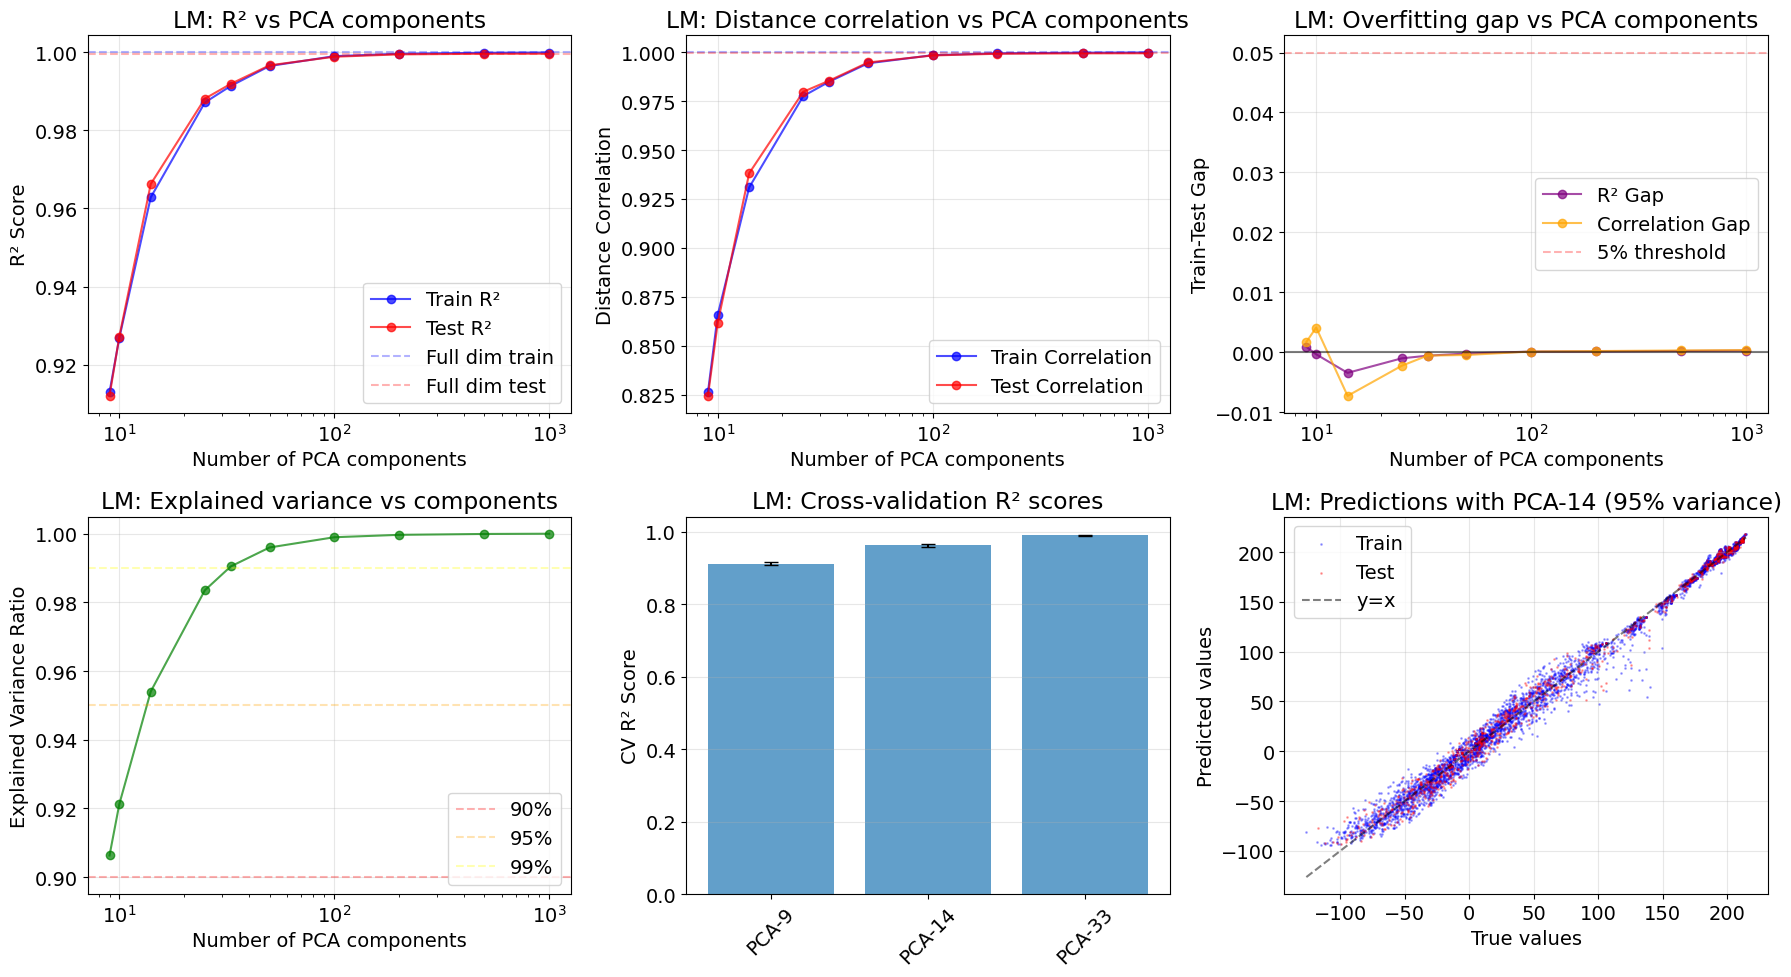


CONCLUSIONS

1. Overfitting Analysis:
   - Full model gap (R²): 0.0003
   - Best PCA gap (R²): -0.0034 with 14 components
   ✅ No significant overfitting detected

2. Optimal dimensionality:
   - For 90% variance: 9 components
   - For 95% variance: 14 components
   - For 99% variance: 33 components
   - Recommended: 14 components (95% variance)

3. Model stability:
   - Best CV score: 0.9904 ± 0.0013
   - Configuration: PCA-33

Vision - OVERFITTING CHECK
Original embedding shape: (1755, 3584)
Number of samples: 1755
Number of features: 3584
Feature/Sample ratio: 2.04

Train size: 1404, Test size: 351

1. BASELINE (Full dimensionality)
Train R²: 0.9999, RMSE: 0.4161
Test R²:  0.9993, RMSE: 1.1363
Overfitting gap (R²): 0.0006
Train distance correlation: 0.9999
Test distance correlation:  0.9992
Correlation gap: 0.0007

2. PCA ANALYSIS

Components needed for:
  90% variance: 6
  95% variance: 9
  99% variance: 19

PCA with 6 components (explains 0.915 variance):
  Train R²: 0.8714, Test

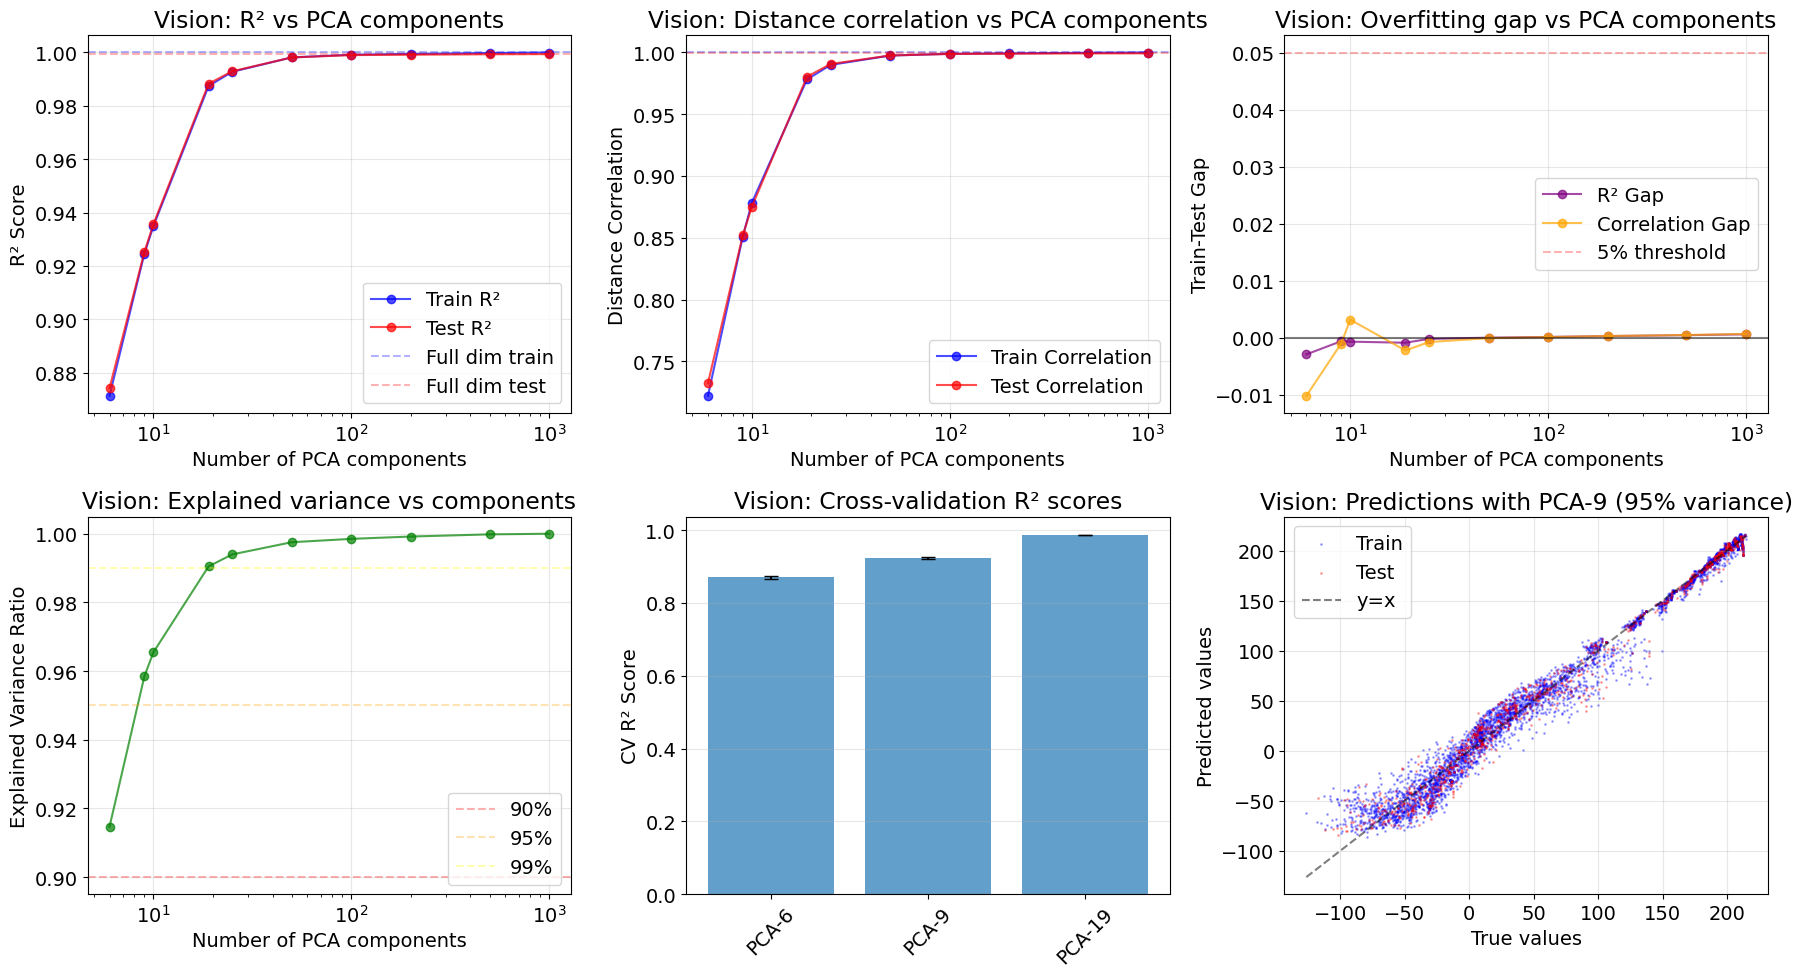


CONCLUSIONS

1. Overfitting Analysis:
   - Full model gap (R²): 0.0006
   - Best PCA gap (R²): -0.0029 with 6 components
   ✅ No significant overfitting detected

2. Optimal dimensionality:
   - For 90% variance: 6 components
   - For 95% variance: 9 components
   - For 99% variance: 19 components
   - Recommended: 9 components (95% variance)

3. Model stability:
   - Best CV score: 0.9870 ± 0.0010
   - Configuration: PCA-19

COMPARATIVE ANALYSIS
✅ LM layer: No significant overfitting
✅ Vision layer: No significant overfitting


In [251]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ
from colour.models import XYZ_to_CAM16LCD
import warnings
warnings.filterwarnings('ignore')

def check_overfitting_with_pca(embeddings, colors_xyY, layer_name="LM", test_size=0.2):
    """
    Проверка на переобучение с использованием PCA для снижения размерности
    """
    # Преобразуем цвета
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    
    print(f"\n{'='*60}")
    print(f"{layer_name} - OVERFITTING CHECK")
    print(f"{'='*60}")
    print(f"Original embedding shape: {embeddings.shape}")
    print(f"Number of samples: {embeddings.shape[0]}")
    print(f"Number of features: {embeddings.shape[1]}")
    print(f"Feature/Sample ratio: {embeddings.shape[1]/embeddings.shape[0]:.2f}")
    
    # Стандартизация данных перед PCA
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Train/test split ПЕРЕД любыми преобразованиями
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings_scaled, colors_cam, test_size=test_size, random_state=42
    )
    
    print(f"\nTrain size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    
    # Словарь для хранения результатов
    results = {}
    
    # === 1. BASELINE: Полная размерность ===
    print(f"\n{'='*40}")
    print("1. BASELINE (Full dimensionality)")
    print(f"{'='*40}")
    
    # Обучаем модель
    ridge_full = Ridge(alpha=1.0)
    ridge_full.fit(X_train, y_train)
    
    # Предсказания
    y_pred_train_full = ridge_full.predict(X_train)
    y_pred_test_full = ridge_full.predict(X_test)
    
    # Метрики
    train_r2_full = r2_score(y_train, y_pred_train_full)
    test_r2_full = r2_score(y_test, y_pred_test_full)
    train_rmse_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
    test_rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
    
    print(f"Train R²: {train_r2_full:.4f}, RMSE: {train_rmse_full:.4f}")
    print(f"Test R²:  {test_r2_full:.4f}, RMSE: {test_rmse_full:.4f}")
    print(f"Overfitting gap (R²): {train_r2_full - test_r2_full:.4f}")
    
    # Корреляции расстояний
    train_dist_true = pdist(y_train, metric='euclidean')
    train_dist_pred = pdist(y_pred_train_full, metric='euclidean')
    test_dist_true = pdist(y_test, metric='euclidean')
    test_dist_pred = pdist(y_pred_test_full, metric='euclidean')
    
    train_corr_full = pearsonr(train_dist_true, train_dist_pred)[0]
    test_corr_full = pearsonr(test_dist_true, test_dist_pred)[0]
    
    print(f"Train distance correlation: {train_corr_full:.4f}")
    print(f"Test distance correlation:  {test_corr_full:.4f}")
    print(f"Correlation gap: {train_corr_full - test_corr_full:.4f}")
    
    results['full'] = {
        'train_r2': train_r2_full,
        'test_r2': test_r2_full,
        'train_corr': train_corr_full,
        'test_corr': test_corr_full,
        'n_components': X_train.shape[1]
    }
    
    # === 2. PCA с разным числом компонент ===
    print(f"\n{'='*40}")
    print("2. PCA ANALYSIS")
    print(f"{'='*40}")
    
    # Определяем диапазон компонент для тестирования
    max_components = min(X_train.shape[0], X_train.shape[1])
    n_components_list = [10, 25, 50, 100, 200, 500, 1000, 1500]
    n_components_list = [n for n in n_components_list if n < max_components]
    
    # Сначала fit PCA на train данных для анализа explained variance
    pca_full = PCA(n_components=min(max_components-1, X_train.shape[1]))
    pca_full.fit(X_train)
    
    # Находим число компонент для разных уровней explained variance
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp_90 = np.argmax(cumsum_var >= 0.90) + 1
    n_comp_95 = np.argmax(cumsum_var >= 0.95) + 1
    n_comp_99 = np.argmax(cumsum_var >= 0.99) + 1
    
    print(f"\nComponents needed for:")
    print(f"  90% variance: {n_comp_90}")
    print(f"  95% variance: {n_comp_95}")
    print(f"  99% variance: {n_comp_99}")
    
    # Добавляем эти значения в список для тестирования
    n_components_list.extend([n_comp_90, n_comp_95, n_comp_99])
    n_components_list = sorted(list(set([n for n in n_components_list if n < max_components])))
    
    pca_results = []
    
    for n_comp in n_components_list:
        # Fit PCA только на train данных
        pca = PCA(n_components=n_comp)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)  # Transform test с параметрами от train
        
        # Обучаем Ridge
        ridge_pca = Ridge(alpha=1.0)
        ridge_pca.fit(X_train_pca, y_train)
        
        # Предсказания
        y_pred_train_pca = ridge_pca.predict(X_train_pca)
        y_pred_test_pca = ridge_pca.predict(X_test_pca)
        
        # Метрики
        train_r2 = r2_score(y_train, y_pred_train_pca)
        test_r2 = r2_score(y_test, y_pred_test_pca)
        
        # Корреляции расстояний
        train_dist_pred_pca = pdist(y_pred_train_pca, metric='euclidean')
        test_dist_pred_pca = pdist(y_pred_test_pca, metric='euclidean')
        
        train_corr = pearsonr(train_dist_true, train_dist_pred_pca)[0]
        test_corr = pearsonr(test_dist_true, test_dist_pred_pca)[0]
        
        explained_var = pca.explained_variance_ratio_.sum()
        
        pca_results.append({
            'n_components': n_comp,
            'explained_variance': explained_var,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_corr': train_corr,
            'test_corr': test_corr,
            'overfitting_gap_r2': train_r2 - test_r2,
            'overfitting_gap_corr': train_corr - test_corr
        })
        
        print(f"\nPCA with {n_comp} components (explains {explained_var:.3f} variance):")
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Gap: {train_r2 - test_r2:.4f}")
        print(f"  Train Corr: {train_corr:.4f}, Test Corr: {test_corr:.4f}, Gap: {train_corr - test_corr:.4f}")
    
    # === 3. Cross-validation для лучшей оценки ===
    print(f"\n{'='*40}")
    print("3. CROSS-VALIDATION ANALYSIS")
    print(f"{'='*40}")
    
    # Для нескольких ключевых размерностей
    key_dimensions = [n_comp_90, n_comp_95, n_comp_99, X_train.shape[1]]
    key_dimensions = [d for d in key_dimensions if d < max_components]
    
    cv_results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for n_comp in key_dimensions:
        if n_comp == X_train.shape[1]:
            # Полная размерность
            X_cv = embeddings_scaled
            label = "Full"
        else:
            # PCA
            pca_cv = PCA(n_components=n_comp)
            X_cv = pca_cv.fit_transform(embeddings_scaled)
            label = f"PCA-{n_comp}"
        
        # Cross-validation scores
        cv_scores = []
        cv_corrs = []
        
        for train_idx, val_idx in kfold.split(X_cv):
            X_fold_train, X_fold_val = X_cv[train_idx], X_cv[val_idx]
            y_fold_train, y_fold_val = colors_cam[train_idx], colors_cam[val_idx]
            
            ridge_cv = Ridge(alpha=1.0)
            ridge_cv.fit(X_fold_train, y_fold_train)
            
            y_pred_val = ridge_cv.predict(X_fold_val)
            cv_scores.append(r2_score(y_fold_val, y_pred_val))
            
            # Корреляция расстояний
            val_dist_true = pdist(y_fold_val, metric='euclidean')
            val_dist_pred = pdist(y_pred_val, metric='euclidean')
            cv_corrs.append(pearsonr(val_dist_true, val_dist_pred)[0])
        
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)
        mean_cv_corr = np.mean(cv_corrs)
        std_cv_corr = np.std(cv_corrs)
        
        print(f"\n{label}:")
        print(f"  CV R²: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
        print(f"  CV Correlation: {mean_cv_corr:.4f} ± {std_cv_corr:.4f}")
        
        cv_results.append({
            'label': label,
            'n_components': n_comp,
            'cv_r2_mean': mean_cv_score,
            'cv_r2_std': std_cv_score,
            'cv_corr_mean': mean_cv_corr,
            'cv_corr_std': std_cv_corr
        })
    
    # === 4. ВИЗУАЛИЗАЦИЯ ===
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # График 1: R² vs число компонент
    ax1 = axes[0, 0]
    n_comps = [r['n_components'] for r in pca_results]
    train_r2s = [r['train_r2'] for r in pca_results]
    test_r2s = [r['test_r2'] for r in pca_results]
    
    ax1.plot(n_comps, train_r2s, 'o-', label='Train R²', color='blue', alpha=0.7)
    ax1.plot(n_comps, test_r2s, 'o-', label='Test R²', color='red', alpha=0.7)
    ax1.axhline(y=train_r2_full, color='blue', linestyle='--', alpha=0.3, label='Full dim train')
    ax1.axhline(y=test_r2_full, color='red', linestyle='--', alpha=0.3, label='Full dim test')
    ax1.set_xlabel('Number of PCA components')
    ax1.set_ylabel('R² Score')
    ax1.set_title(f'{layer_name}: R² vs PCA components')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    
    # График 2: Correlation vs число компонент
    ax2 = axes[0, 1]
    train_corrs = [r['train_corr'] for r in pca_results]
    test_corrs = [r['test_corr'] for r in pca_results]
    
    ax2.plot(n_comps, train_corrs, 'o-', label='Train Correlation', color='blue', alpha=0.7)
    ax2.plot(n_comps, test_corrs, 'o-', label='Test Correlation', color='red', alpha=0.7)
    ax2.axhline(y=train_corr_full, color='blue', linestyle='--', alpha=0.3)
    ax2.axhline(y=test_corr_full, color='red', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Number of PCA components')
    ax2.set_ylabel('Distance Correlation')
    ax2.set_title(f'{layer_name}: Distance correlation vs PCA components')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')
    
    # График 3: Overfitting gap
    ax3 = axes[0, 2]
    overfitting_gaps_r2 = [r['overfitting_gap_r2'] for r in pca_results]
    overfitting_gaps_corr = [r['overfitting_gap_corr'] for r in pca_results]
    
    ax3.plot(n_comps, overfitting_gaps_r2, 'o-', label='R² Gap', color='purple', alpha=0.7)
    ax3.plot(n_comps, overfitting_gaps_corr, 'o-', label='Correlation Gap', color='orange', alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.3, label='5% threshold')
    ax3.set_xlabel('Number of PCA components')
    ax3.set_ylabel('Train-Test Gap')
    ax3.set_title(f'{layer_name}: Overfitting gap vs PCA components')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xscale('log')
    
    # График 4: Explained variance
    ax4 = axes[1, 0]
    explained_vars = [r['explained_variance'] for r in pca_results]
    ax4.plot(n_comps, explained_vars, 'o-', color='green', alpha=0.7)
    ax4.axhline(y=0.90, color='red', linestyle='--', alpha=0.3, label='90%')
    ax4.axhline(y=0.95, color='orange', linestyle='--', alpha=0.3, label='95%')
    ax4.axhline(y=0.99, color='yellow', linestyle='--', alpha=0.3, label='99%')
    ax4.set_xlabel('Number of PCA components')
    ax4.set_ylabel('Explained Variance Ratio')
    ax4.set_title(f'{layer_name}: Explained variance vs components')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xscale('log')
    
    # График 5: CV результаты
    ax5 = axes[1, 1]
    cv_labels = [r['label'] for r in cv_results]
    cv_r2_means = [r['cv_r2_mean'] for r in cv_results]
    cv_r2_stds = [r['cv_r2_std'] for r in cv_results]
    
    x_pos = np.arange(len(cv_labels))
    ax5.bar(x_pos, cv_r2_means, yerr=cv_r2_stds, capsize=5, alpha=0.7)
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(cv_labels, rotation=45)
    ax5.set_ylabel('CV R² Score')
    ax5.set_title(f'{layer_name}: Cross-validation R² scores')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # График 6: Train vs Test scatter для лучшей PCA
    ax6 = axes[1, 2]
    # Используем PCA с 95% variance
    pca_best = PCA(n_components=n_comp_95)
    X_train_best = pca_best.fit_transform(X_train)
    X_test_best = pca_best.transform(X_test)
    
    ridge_best = Ridge(alpha=1.0)
    ridge_best.fit(X_train_best, y_train)
    
    y_pred_train_best = ridge_best.predict(X_train_best)
    y_pred_test_best = ridge_best.predict(X_test_best)
    
    # Scatter plot
    ax6.scatter(y_train.flatten(), y_pred_train_best.flatten(), 
               alpha=0.3, s=1, label='Train', color='blue')
    ax6.scatter(y_test.flatten(), y_pred_test_best.flatten(), 
               alpha=0.3, s=1, label='Test', color='red')
    
    # Диагональная линия
    all_values = np.concatenate([y_train.flatten(), y_test.flatten()])
    ax6.plot([all_values.min(), all_values.max()], 
            [all_values.min(), all_values.max()], 
            'k--', alpha=0.5, label='y=x')
    
    ax6.set_xlabel('True values')
    ax6.set_ylabel('Predicted values')
    ax6.set_title(f'{layer_name}: Predictions with PCA-{n_comp_95} (95% variance)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # === 5. ВЫВОДЫ ===
    print(f"\n{'='*40}")
    print("CONCLUSIONS")
    print(f"{'='*40}")
    
    # Находим оптимальное число компонент
    best_pca = min(pca_results, key=lambda x: x['overfitting_gap_r2'])
    
    print(f"\n1. Overfitting Analysis:")
    print(f"   - Full model gap (R²): {train_r2_full - test_r2_full:.4f}")
    print(f"   - Best PCA gap (R²): {best_pca['overfitting_gap_r2']:.4f} with {best_pca['n_components']} components")
    
    if train_r2_full - test_r2_full > 0.05:
        print(f"   ⚠️ WARNING: Significant overfitting detected (gap > 5%)")
        print(f"   📊 Recommendation: Use PCA with {best_pca['n_components']} components")
    else:
        print(f"   ✅ No significant overfitting detected")
    
    print(f"\n2. Optimal dimensionality:")
    print(f"   - For 90% variance: {n_comp_90} components")
    print(f"   - For 95% variance: {n_comp_95} components")
    print(f"   - For 99% variance: {n_comp_99} components")
    print(f"   - Recommended: {n_comp_95} components (95% variance)")
    
    print(f"\n3. Model stability:")
    best_cv = max(cv_results, key=lambda x: x['cv_r2_mean'])
    print(f"   - Best CV score: {best_cv['cv_r2_mean']:.4f} ± {best_cv['cv_r2_std']:.4f}")
    print(f"   - Configuration: {best_cv['label']}")
    
    return {
        'full_results': results,
        'pca_results': pca_results,
        'cv_results': cv_results,
        'optimal_components': best_pca['n_components'],
        'overfitting_detected': train_r2_full - test_r2_full > 0.05
    }

# Запуск проверки на переобучение
print("="*60)
print("OVERFITTING ANALYSIS FOR COLOR CALIBRATION")
print("="*60)

# Анализ LM слоя
lm_overfit = check_overfitting_with_pca(
    lm_matrix_all, 
    colors_xyY_all, 
    layer_name="LM"
)

# Анализ Vision слоя
vision_overfit = check_overfitting_with_pca(
    vision_matrix_all, 
    colors_xyY_all, 
    layer_name="Vision"
)

# Сравнительный анализ
print("\n" + "="*60)
print("COMPARATIVE ANALYSIS")
print("="*60)

if lm_overfit['overfitting_detected']:
    print("⚠️ LM layer shows signs of overfitting")
    print(f"   Recommended: Use PCA with {lm_overfit['optimal_components']} components")
else:
    print("✅ LM layer: No significant overfitting")

if vision_overfit['overfitting_detected']:
    print("⚠️ Vision layer shows signs of overfitting")
    print(f"   Recommended: Use PCA with {vision_overfit['optimal_components']} components")
else:
    print("✅ Vision layer: No significant overfitting")


PCA ANALYSIS FOR COLOR CALIBRATION

LM PCA 14 - PCA DIMENSIONALITY REDUCTION AND REGRESSION
Original shape: (1755, 3584)
Train size: 1404, Test size: 351

Components needed for:
  90% variance: 9
  95% variance: 14
  99% variance: 33

Using PCA with 100 components (95% variance)
Train R²: 0.9989, RMSE: 1.4623
Test R²: 0.9988, RMSE: 1.5167
Train distance correlation: 0.9985
Test distance correlation: 0.9984


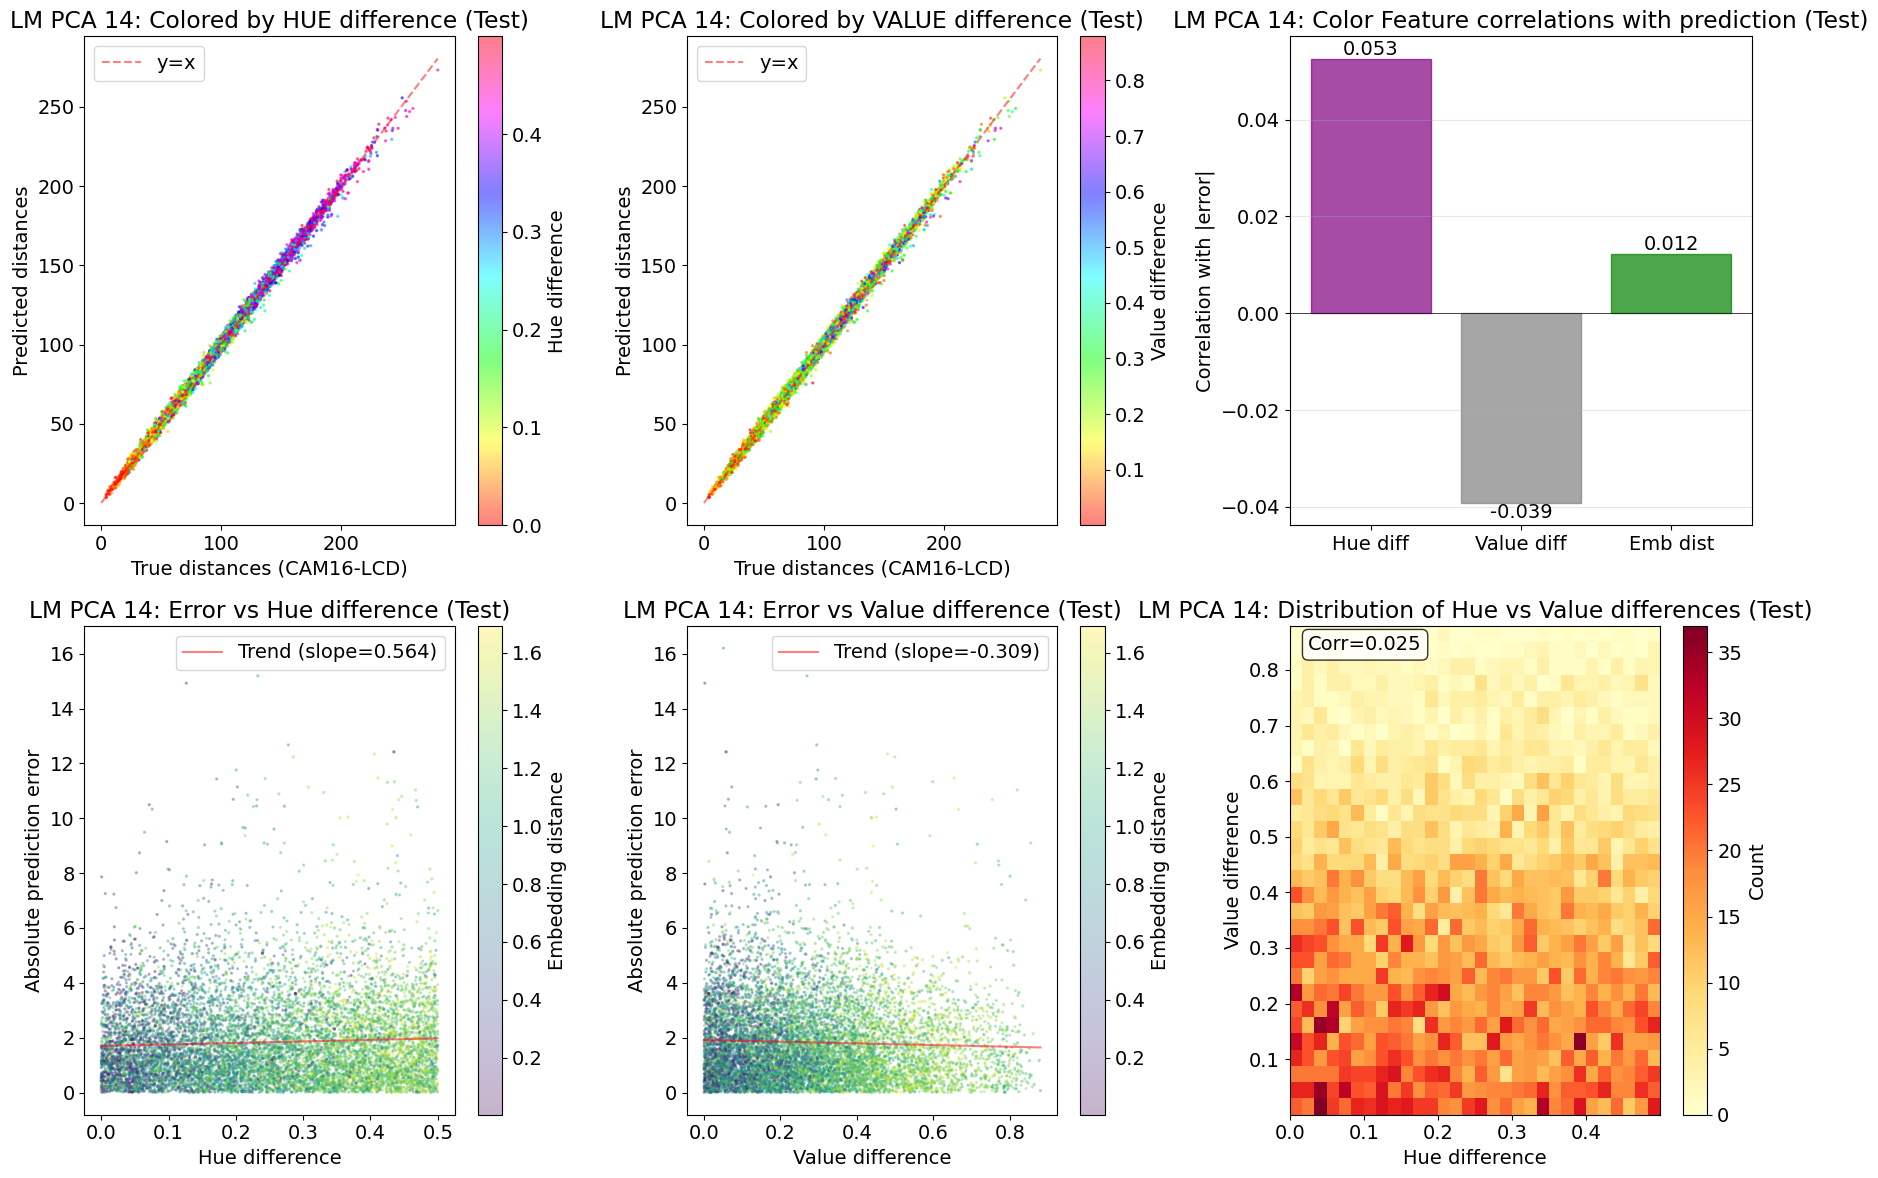


LM PCA 14 - HSV Analysis Summary (Test):
  Hue difference range: [0.000, 0.500]
  Value difference range: [0.000, 0.879]
  Correlation(hue_diff, |error|): 0.053
  Correlation(value_diff, |error|): -0.039
  Correlation(hue_diff, value_diff): 0.025

Vs PCA 9 - PCA DIMENSIONALITY REDUCTION AND REGRESSION
Original shape: (1755, 3584)
Train size: 1404, Test size: 351

Components needed for:
  90% variance: 6
  95% variance: 9
  99% variance: 19

Using PCA with 100 components (95% variance)
Train R²: 0.9990, RMSE: 1.3462
Test R²: 0.9989, RMSE: 1.4077
Train distance correlation: 0.9988
Test distance correlation: 0.9986


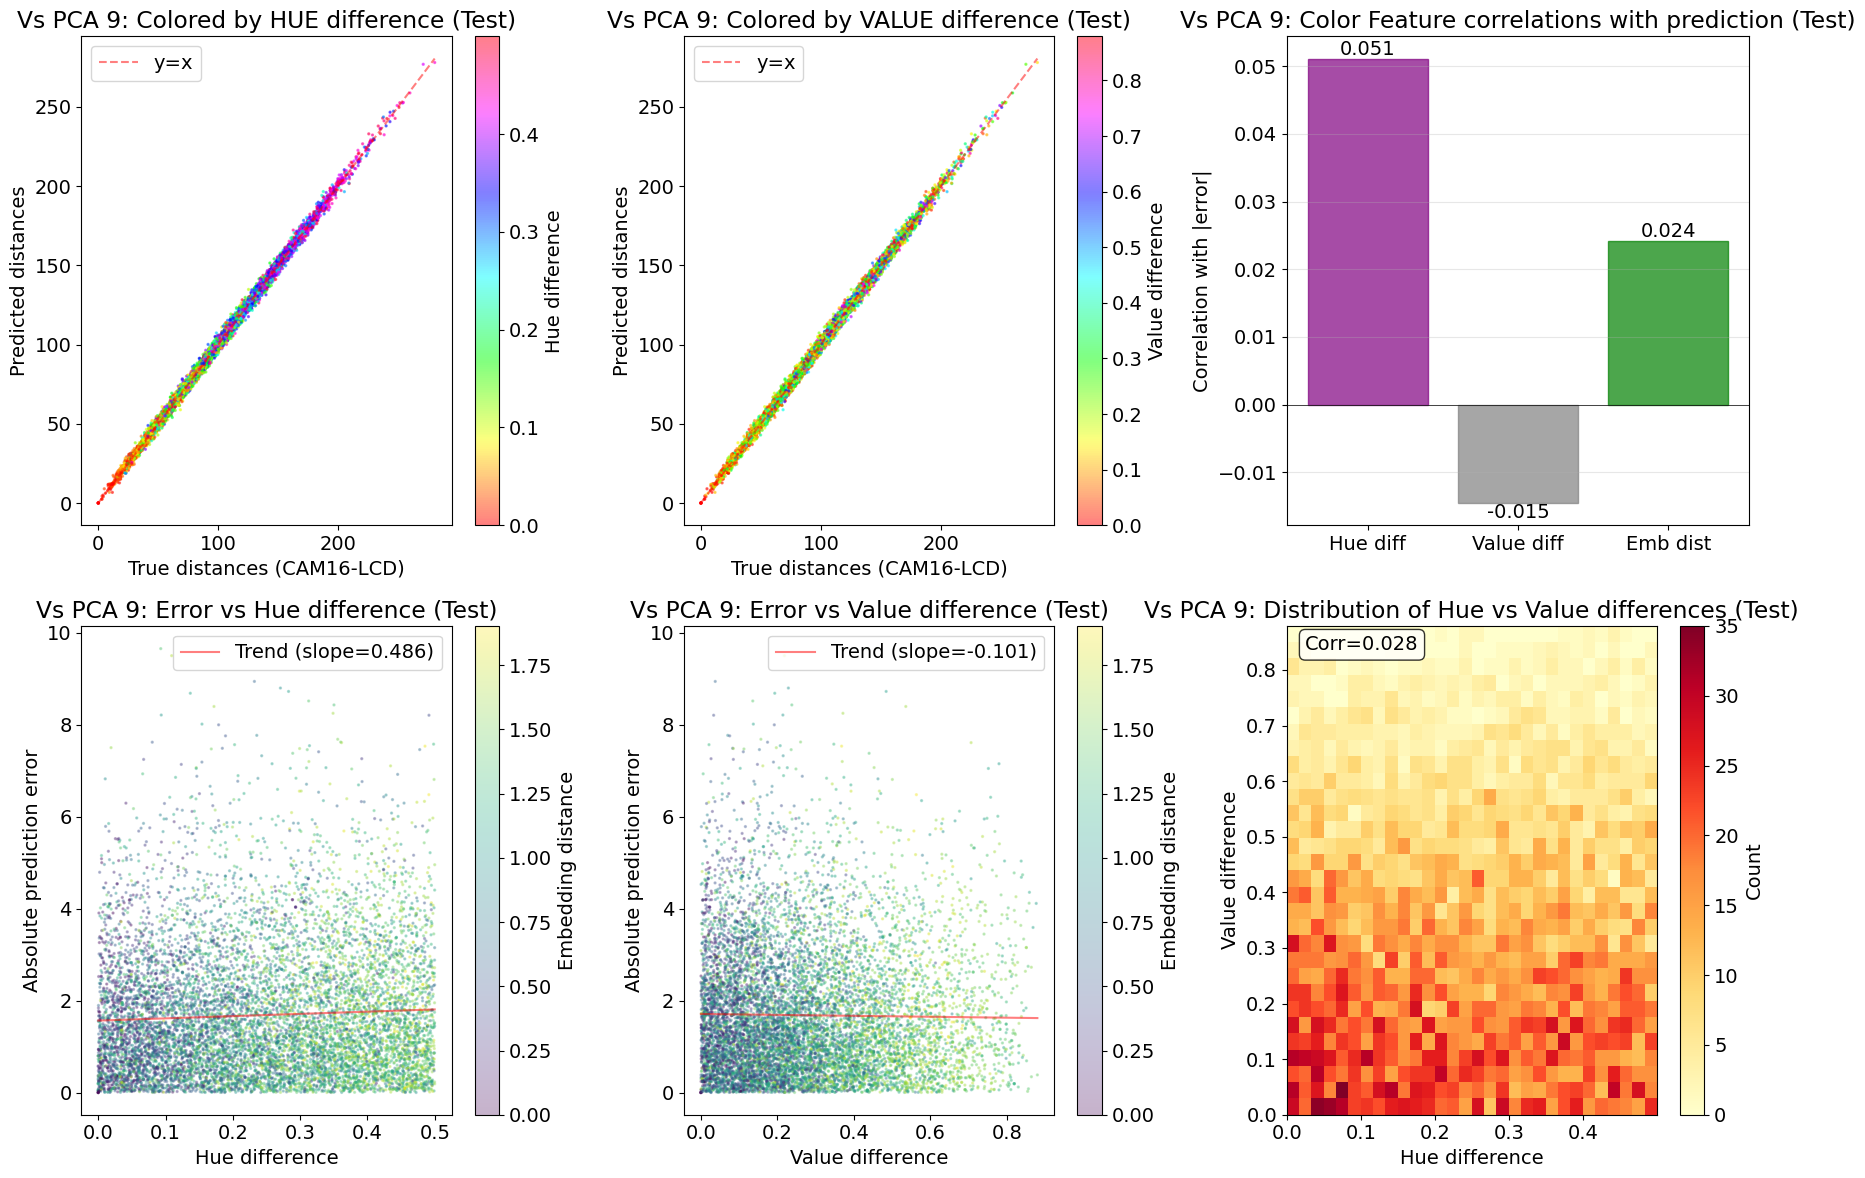


Vs PCA 9 - HSV Analysis Summary (Test):
  Hue difference range: [0.000, 0.500]
  Value difference range: [0.000, 0.879]
  Correlation(hue_diff, |error|): 0.051
  Correlation(value_diff, |error|): -0.015
  Correlation(hue_diff, value_diff): 0.028


In [256]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from colour import xyY_to_XYZ
from colour.models import XYZ_to_CAM16LCD
from matplotlib.colors import rgb_to_hsv
import warnings
warnings.filterwarnings('ignore')

def get_rgb_colors_from_meta(color_meta_all):
    """Извлекает RGB цвета из метаданных"""
    keys = sorted(color_meta_all.keys(), key=lambda k: int(k))
    rgb_colors = np.array([
        [color_meta_all[k]['RGB']['R'],
         color_meta_all[k]['RGB']['G'],
         color_meta_all[k]['RGB']['B']]
        for k in keys
    ])
    # Клиппинг в диапазон [0, 1]
    rgb_colors = np.clip(rgb_colors, 0, 1)
    return rgb_colors

def compute_hsv_differences(rgb_colors, pair_indices):
    """Вычисляет различия в HSV пространстве для пар цветов"""
    hue_diffs = []
    value_diffs = []
    
    for i, j in pair_indices:
        hsv1 = rgb_to_hsv(rgb_colors[i])
        hsv2 = rgb_to_hsv(rgb_colors[j])
        
        # Hue difference (circular)
        h_diff = np.abs(hsv1[0] - hsv2[0])
        if h_diff > 0.5:
            h_diff = 1.0 - h_diff
        hue_diffs.append(h_diff)
        
        # Value difference
        v_diff = np.abs(hsv1[2] - hsv2[2])
        value_diffs.append(v_diff)
    
    return np.array(hue_diffs), np.array(value_diffs)

def color_mapping_with_pca(embeddings, colors_xyY, color_meta_all, layer_name="LM", test_size=0.2):
    # Преобразуем цвета в CAM16-LCD
    colors_cam = np.array([XYZ_to_CAM16LCD(xyY_to_XYZ(c)) for c in colors_xyY])
    
    # Получаем RGB цвета
    rgb_colors = get_rgb_colors_from_meta(color_meta_all)
    
    # Стандартизация embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Train/test split
    X_train, X_test, y_train, y_test, rgb_train, rgb_test = train_test_split(
        embeddings_scaled, colors_cam, rgb_colors, test_size=test_size, random_state=42
    )
    
    print(f"\n{'='*60}")
    print(f"{layer_name} - PCA DIMENSIONALITY REDUCTION AND REGRESSION")
    print(f"{'='*60}")
    print(f"Original shape: {embeddings.shape}")
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    
    # PCA analysis on train
    pca_full = PCA()
    pca_full.fit(X_train)
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp_90 = np.argmax(cumsum_var >= 0.90) + 1
    n_comp_95 = np.argmax(cumsum_var >= 0.95) + 1
    n_comp_99 = np.argmax(cumsum_var >= 0.99) + 1
    
    print(f"\nComponents needed for:")
    print(f"  90% variance: {n_comp_90}")
    print(f"  95% variance: {n_comp_95}")
    print(f"  99% variance: {n_comp_99}")
    
    # Use 95% variance for analysis
    n_comp = 100
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    print(f"\nUsing PCA with {n_comp} components (95% variance)")
    
    # Linear regression (Ridge)
    reg = Ridge(alpha=1.0)
    reg.fit(X_train_pca, y_train)
    
    # Predictions
    y_pred_train = reg.predict(X_train_pca)
    y_pred_test = reg.predict(X_test_pca)
    
    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"Train R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
    
    # Distance correlations
    train_dist_true = pdist(y_train, metric='euclidean')
    train_dist_pred = pdist(y_pred_train, metric='euclidean')
    train_corr = pearsonr(train_dist_true, train_dist_pred)[0]
    
    test_dist_true = pdist(y_test, metric='euclidean')
    test_dist_pred = pdist(y_pred_test, metric='euclidean')
    test_corr = pearsonr(test_dist_true, test_dist_pred)[0]
    
    print(f"Train distance correlation: {train_corr:.4f}")
    print(f"Test distance correlation: {test_corr:.4f}")
    
    # Visualizations on test set
    n_test = len(y_test)
    pair_indices = np.array([(i, j) for i in range(n_test) for j in range(i+1, n_test)])
    
    v_true = test_dist_true
    v_pred = test_dist_pred
    v_emb = pdist(X_test, metric='cosine')
    errors = v_pred - v_true
    
    # Sample if too many
    max_points = 10000
    if len(pair_indices) > max_points:
        sample_idx = np.random.choice(len(pair_indices), max_points, replace=False)
        sampled_pairs = pair_indices[sample_idx]
        sampled_v_true = v_true[sample_idx]
        sampled_v_pred = v_pred[sample_idx]
        sampled_v_emb = v_emb[sample_idx]
        sampled_errors = errors[sample_idx]
    else:
        sampled_pairs = pair_indices
        sampled_v_true = v_true
        sampled_v_pred = v_pred
        sampled_v_emb = v_emb
        sampled_errors = errors
    
    # Compute HSV diffs
    hue_diffs, value_diffs = compute_hsv_differences(rgb_test, sampled_pairs)
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Distances colored by HUE difference
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(sampled_v_true, sampled_v_pred, s=2, alpha=0.5, c=hue_diffs, cmap='hsv')
    ax1.plot([0, max(sampled_v_true)], [0, max(sampled_v_true)], 'r--', alpha=0.5, label='y=x')
    ax1.set_xlabel('True distances (CAM16-LCD)')
    ax1.set_ylabel('Predicted distances')
    ax1.set_title(f'{layer_name}: Colored by HUE difference (Test)')
    ax1.legend()
    plt.colorbar(scatter1, ax=ax1, label='Hue difference')
    
    # 2. Distances colored by VALUE difference
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(sampled_v_true, sampled_v_pred, s=2, alpha=0.5, c=value_diffs, cmap='hsv')
    ax2.plot([0, max(sampled_v_true)], [0, max(sampled_v_true)], 'r--', alpha=0.5, label='y=x')
    ax2.set_xlabel('True distances (CAM16-LCD)')
    ax2.set_ylabel('Predicted distances')
    ax2.set_title(f'{layer_name}: Colored by VALUE difference (Test)')
    ax2.legend()
    plt.colorbar(scatter2, ax=ax2, label='Value difference')
    
    # 3. Feature correlations with error
    ax3 = axes[0, 2]
    correlations_with_error = {
        'Hue diff': pearsonr(hue_diffs, np.abs(sampled_errors))[0],
        'Value diff': pearsonr(value_diffs, np.abs(sampled_errors))[0],
        'Emb dist': pearsonr(sampled_v_emb, np.abs(sampled_errors))[0],
    }
    
    bars = ax3.bar(range(len(correlations_with_error)), list(correlations_with_error.values()), tick_label=list(correlations_with_error.keys()))
    ax3.set_ylabel('Correlation with |error|')
    ax3.set_title(f'{layer_name}: Color Feature correlations with prediction (Test)')
    ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax3.grid(True, alpha=0.3, axis='y')
    
    colors_bars = ['purple', 'gray', 'green']
    for bar, color in zip(bars, colors_bars):
        bar.set_color(color)
        bar.set_alpha(0.7)
    
    for bar, val in zip(bars, correlations_with_error.values()):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top')
    
    # 4. Error vs HUE difference
    ax4 = axes[1, 0]
    scatter4 = ax4.scatter(hue_diffs, np.abs(sampled_errors), s=2, alpha=0.3, c=sampled_v_emb, cmap='viridis')
    ax4.set_xlabel('Hue difference')
    ax4.set_ylabel('Absolute prediction error')
    ax4.set_title(f'{layer_name}: Error vs Hue difference (Test)')
    plt.colorbar(scatter4, ax=ax4, label='Embedding distance')
    
    z = np.polyfit(hue_diffs, np.abs(sampled_errors), 1)
    p = np.poly1d(z)
    ax4.plot(np.sort(hue_diffs), p(np.sort(hue_diffs)), "r-", alpha=0.5, label=f'Trend (slope={z[0]:.3f})')
    ax4.legend()
    
    # 5. Error vs VALUE difference
    ax5 = axes[1, 1]
    scatter5 = ax5.scatter(value_diffs, np.abs(sampled_errors), s=2, alpha=0.3, c=sampled_v_emb, cmap='viridis')
    ax5.set_xlabel('Value difference')
    ax5.set_ylabel('Absolute prediction error')
    ax5.set_title(f'{layer_name}: Error vs Value difference (Test)')
    plt.colorbar(scatter5, ax=ax5, label='Embedding distance')
    
    z = np.polyfit(value_diffs, np.abs(sampled_errors), 1)
    p = np.poly1d(z)
    ax5.plot(np.sort(value_diffs), p(np.sort(value_diffs)), "r-", alpha=0.5, label=f'Trend (slope={z[0]:.3f})')
    ax5.legend()
    
    # 6. 2D histogram: Hue vs Value differences
    ax6 = axes[1, 2]
    h = ax6.hist2d(hue_diffs, value_diffs, bins=30, cmap='YlOrRd')
    ax6.set_xlabel('Hue difference')
    ax6.set_ylabel('Value difference')
    ax6.set_title(f'{layer_name}: Distribution of Hue vs Value differences (Test)')
    plt.colorbar(h[3], ax=ax6, label='Count')
    
    hv_corr = pearsonr(hue_diffs, value_diffs)[0]
    ax6.text(0.05, 0.95, f'Corr={hv_corr:.3f}', transform=ax6.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print HSV summary
    print(f"\n{layer_name} - HSV Analysis Summary (Test):")
    print(f"  Hue difference range: [{hue_diffs.min():.3f}, {hue_diffs.max():.3f}]")
    print(f"  Value difference range: [{value_diffs.min():.3f}, {value_diffs.max():.3f}]")
    print(f"  Correlation(hue_diff, |error|): {correlations_with_error['Hue diff']:.3f}")
    print(f"  Correlation(value_diff, |error|): {correlations_with_error['Value diff']:.3f}")
    print(f"  Correlation(hue_diff, value_diff): {hv_corr:.3f}")

# Запуск анализа
print("="*60)
print("PCA ANALYSIS FOR COLOR CALIBRATION")
print("="*60)

# LM layer
color_mapping_with_pca(lm_matrix_all, colors_xyY_all, color_meta_all, layer_name="LM PCA 14")

# Vision layer
color_mapping_with_pca(vision_matrix_all, colors_xyY_all, color_meta_all, layer_name="Vs PCA 9")

## Выводы
#### 1. **Хорошее качество линейного отображения**
- **R² ≈ 0.999** для обоих слоев показывает, что линейное преобразование практически идеально восстанавливает перцептивное цветовое пространство человека
- RMSE < 1.5 единиц ΔE в CAM16-LCD - это ниже порога различимости человеческого глаза
- VLM кодирует цветовую информацию линейно относительно человеческого восприятия

#### 2. **Умеренная корреляция исходных расстояний**
- Pearson(emb, true) ≈ 0.52-0.53, Spearman ≈ 0.56-0.61
- **Интерпретация**: 
  - VLM использует ~50-60% информации для кодирования перцептивных различий
  - После линейной проекции корреляция расстояний достигает 0.9998

#### 3. **Сравнение слоев LM vs Vision**

**LM слой превосходит Vision:**
- Выше R² (0.9996 vs 0.9989)
- Ниже RMSE (0.90 vs 1.44)
- Лучше k-NN preservation (86-92% vs 74-83%)
- Меньше condition number (1.97 vs 2.36) = более стабильное преобразование

**Вывод**: Language Model слой лучше кодирует цветовую информацию, чем Vision слой

#### 4. **Анализ матрицы преобразования**
- **Эффективный ранг = 3** - соответствует 3D цветовому пространству (L, a, b)
- **Низкий condition number** (< 2.5) - численно стабильное преобразование
- **Сингулярные значения** убывают плавно - нет доминирующих компонент

#### 5. **Изотропность ≈ 0.99**
- Преобразование равномерно во всех направлениях цветового пространства
- Нет систематических искажений для определенных цветовых регионов

#### 6. **k-NN preservation**
- LM: 86-92% соседей сохраняются
- Vision: 74-83% соседей сохраняются
- **Вывод**: Локальная структура цветового пространства хорошо сохраняется

### Интерпретация графиков:

#### **Error by Distance Range (график 3)**
Показывает зависимость ошибки от величины расстояния:
- **Равномерная высота столбцов** = ошибка не зависит от масштаба (хорошо!)
- **Рост ошибки с расстоянием** = модель хуже работает на далеких цветах
- **U-образная форма** = проблемы на очень близких и очень далеких цветах
